In [16]:
import os
import xarray as xr
from dask.distributed import Client
import matplotlib.pyplot as plt
from os import listdir
import rioxarray as rxr
import glob
#import seaborn as sns
from shapely.geometry import MultiPoint
import geopandas as gpd
import cartopy.crs as ccrs
import pandas as pd
import numpy as np

In [2]:
# Create a path to the code file
codeDir = os.path.dirname(os.path.abspath(os.getcwd()))
parentDir = os.path.dirname(codeDir)

In [ ]:
gage_folder = os.path.join(parentDir,"precip_gage")

# grizzly
grizzly = get_grizzly(gage_folder)
# cpf
cpf = get_cpf(gage_folder+'\\cpf google drive')
# disdrometer
disdrom = get_disdrom(gage_folder)
# coagmet
coag = get_coagmet(gage_folder)
# other gages
other = get_usgs_other(gage_folder)

new_usgs = get_usgsnew(gage_folder)

# bring everything together
gage = {**grizzly, **cpf, **disdrom, **coag, **other, **new_usgs}
#gage = {**grizzly, **cpf, **disdrom, **coag, **other}

# get list of keys (lat/lon)
coord = [i for i in gage.keys()]

In [111]:
gage_raw = pd.read_feather(data_folder+'\\coagmet_5min_01apr21_01oct22')
gage_location = pd.read_feather(data_folder+'\\coagmet_5min_metadata')
#gage_location = gage_location.drop([59])
gage_location = gage_location.loc[gage_location['Longitude (degE)']<=-104]
gage_location = gage_location.loc[gage_location.Station.isin(gage_raw.Station)]

gage_raw = [gage_raw.loc[gage_raw.Station==i] for i in gage_location.Station]

# get rid of -999 values
''''''
for i in range(len(gage_raw)):
    gage_raw[i].loc[gage_raw[i].Precip<0] = 0

# remove gages not recording anything
gage_sum = [gage_raw[i].Precip.sum() for i in range(len(gage_raw))]
gage_location['sum']=gage_sum
gage_location=gage_location.loc[gage_location['sum']!=0]

gage_raw = pd.concat(gage_raw)
gage_raw = [gage_raw.loc[gage_raw.Station==i] for i in gage_location.Station]

gage_raw = [gage_raw[i].set_index('datetime') for i in range(len(gage_raw))]
gage_raw = [gage_raw[i].resample('1Min').asfreq().fillna(0) for i in range(len(gage_raw))]
#gage_raw = [gage_raw[i].resample('1Min').asfreq() for i in range(len(gage_raw))]

gage_raw = [gage_raw[i].drop(['Station'],axis=1) for i in range(len(gage_raw))]

gage_raw = [gage_raw[i].rename(columns={"Precip": "accum"}) for i in range(len(gage_raw))]

for i in range(len(gage_raw)):
    # calculate desired intensity by summing 1min accum with rolling desired intensity window, 
    # then divide by desired intensity (min) and convert to mm/hr
    rate = gage_raw[i].accum.rolling(15,min_periods=1).sum()
    rate = (rate*(60/15))
    gage_raw[i]['15_int'] = rate

lat = gage_location['Latitude (degN)']
lon = gage_location['Longitude (degE)']+360

gage_raw = [gage_raw[i].iloc[(gage_raw[i].index.year<=2022) & (gage_raw[i].index.year>=2021)&
            (gage_raw[i].index.month>=4) & (gage_raw[i].index.month<11)] for i in range(len(gage_raw))]

coord = zip(lat,lon)

coagmet = dict(zip(coord, gage_raw))

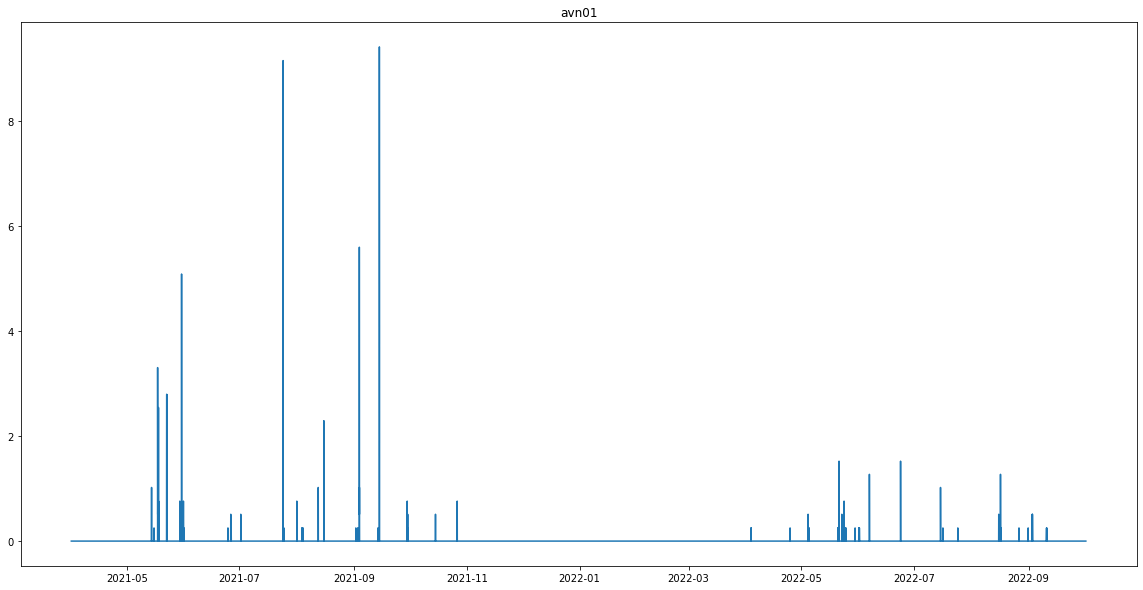

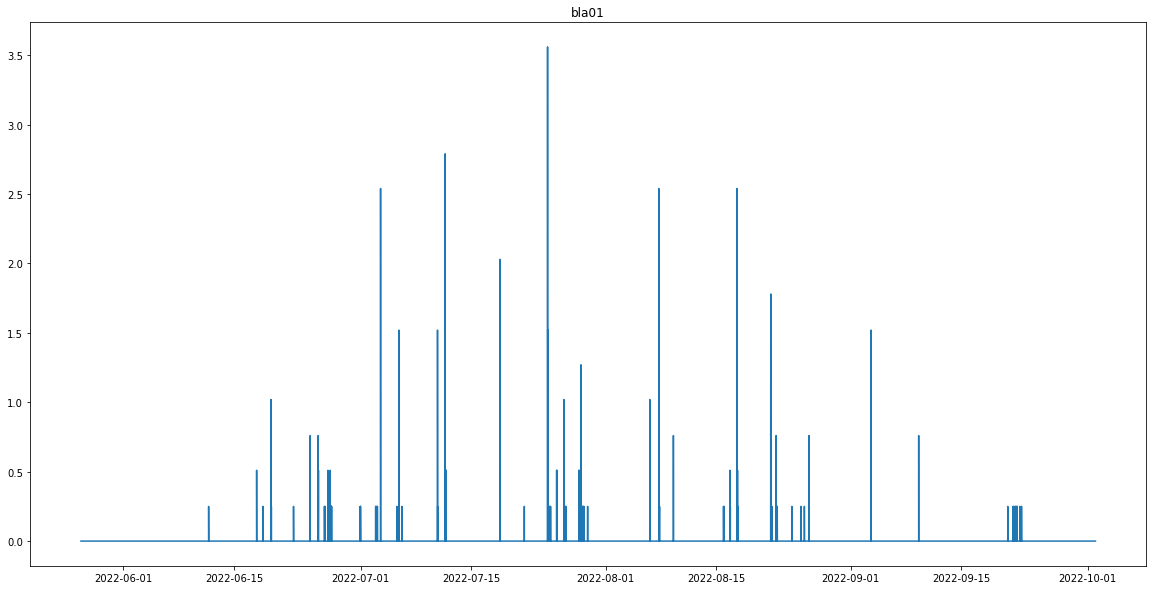

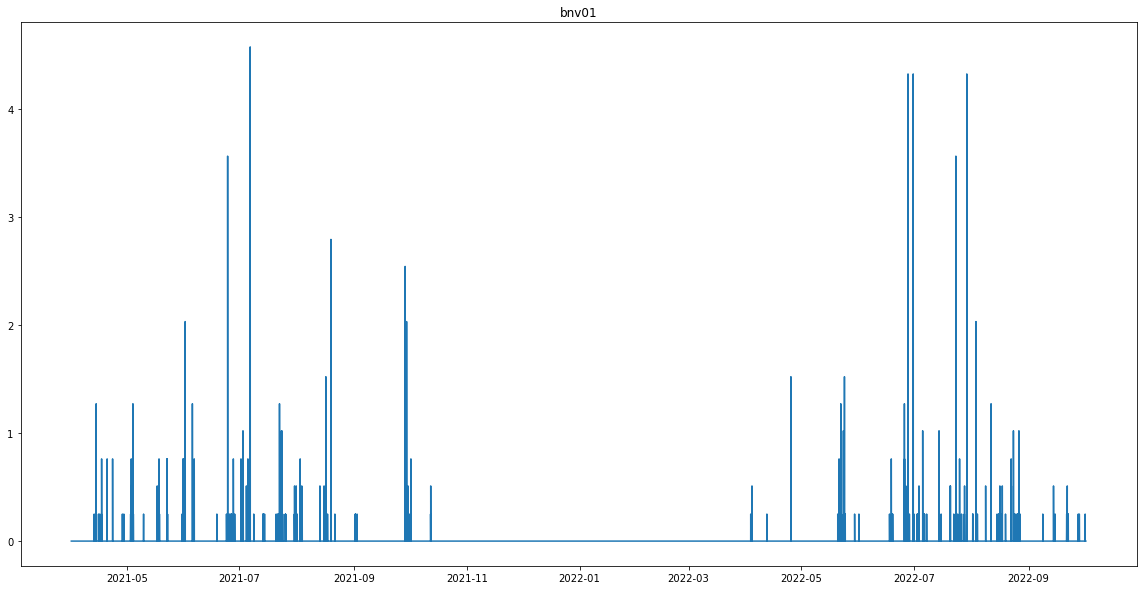

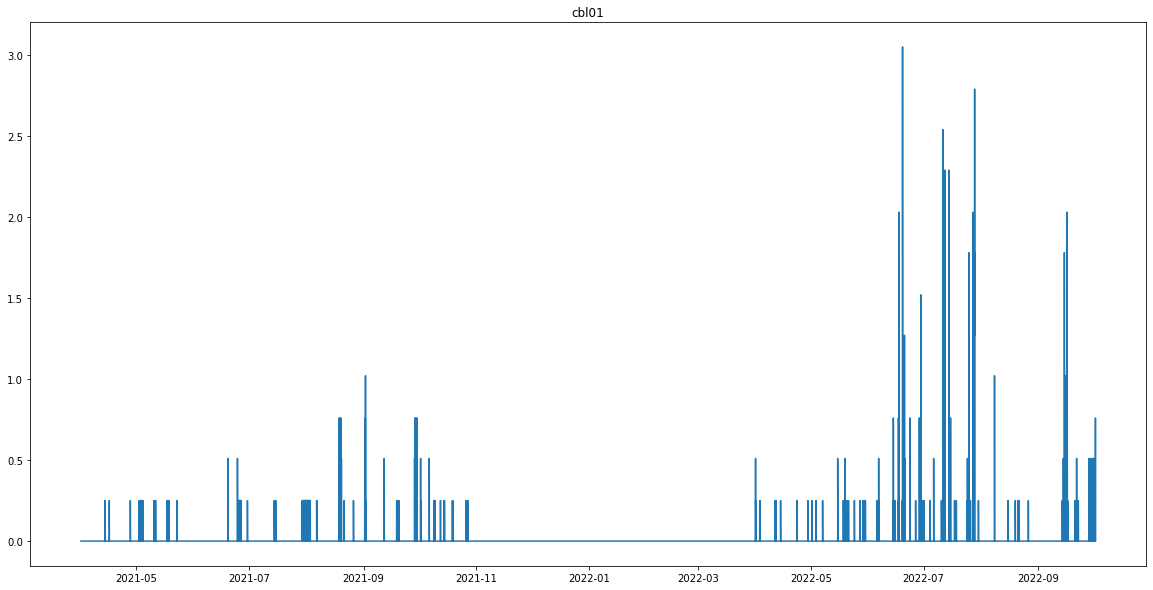

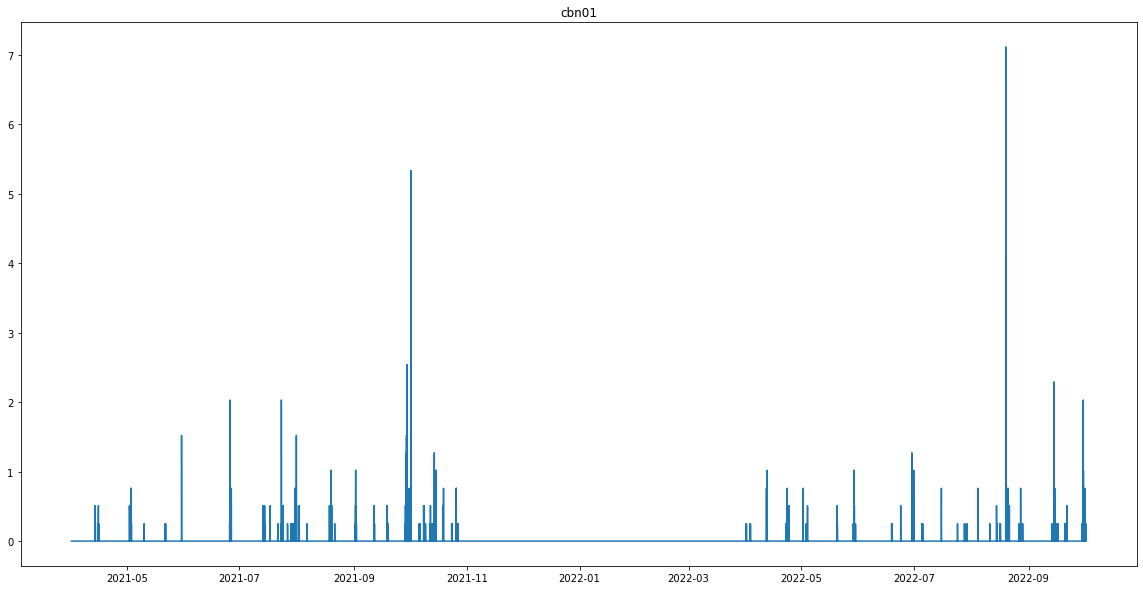

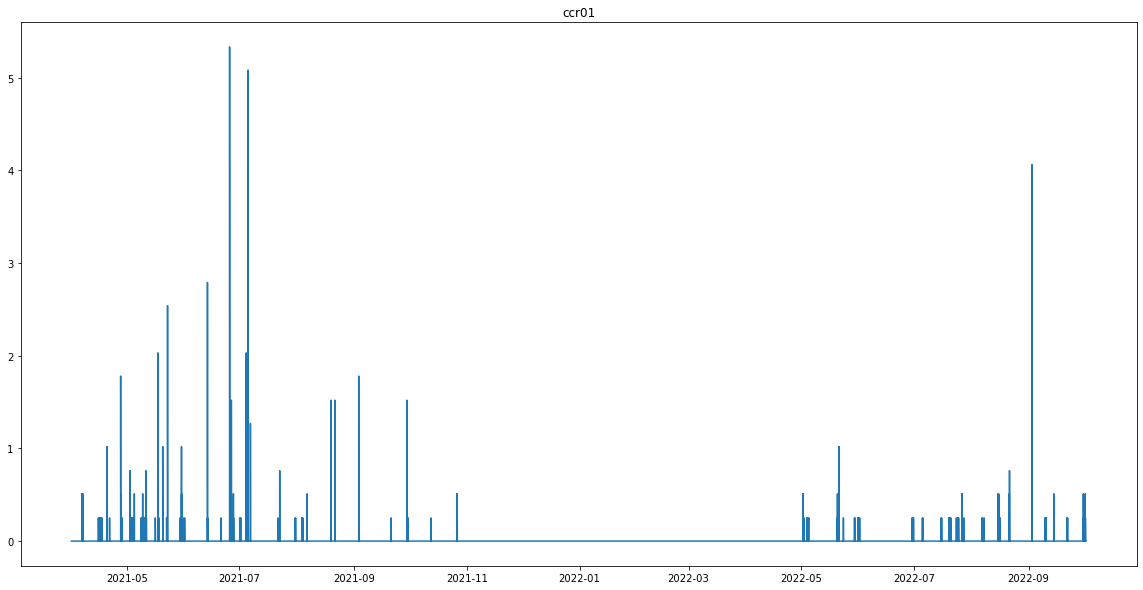

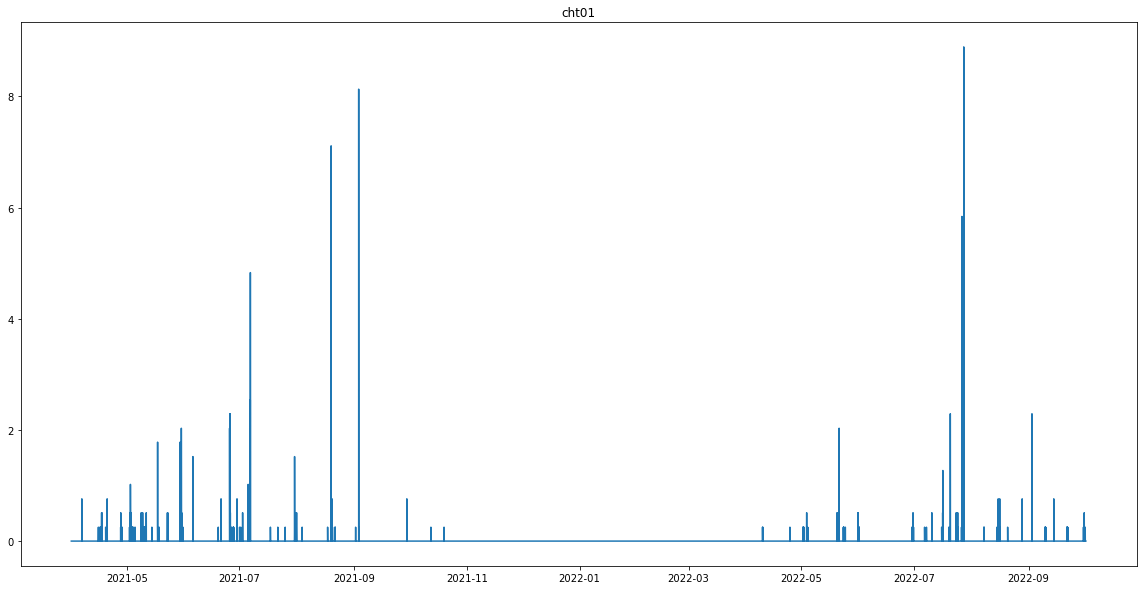

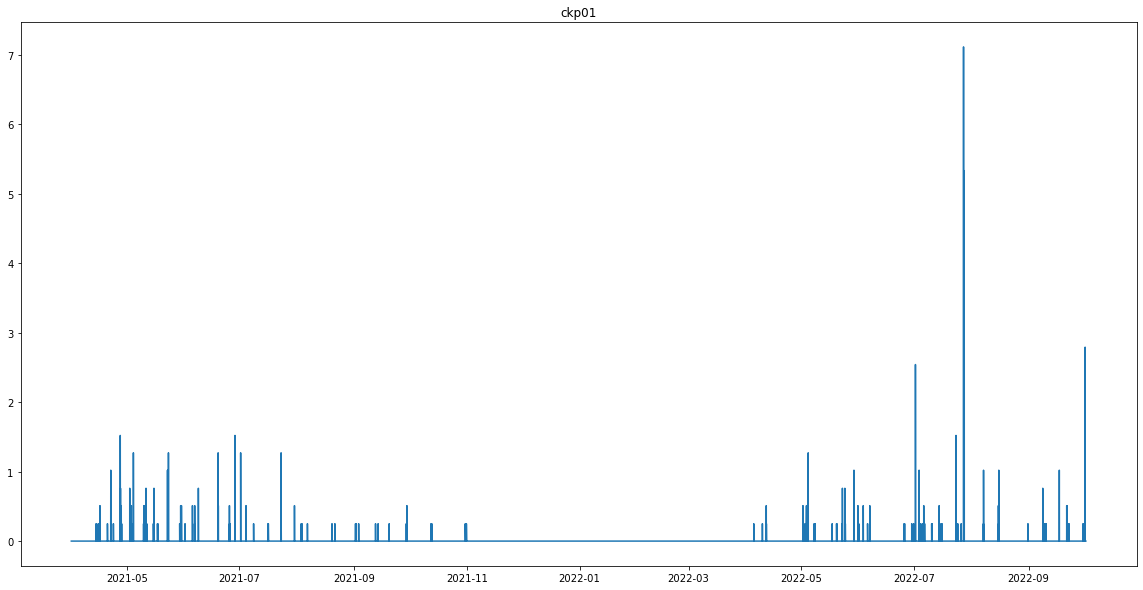

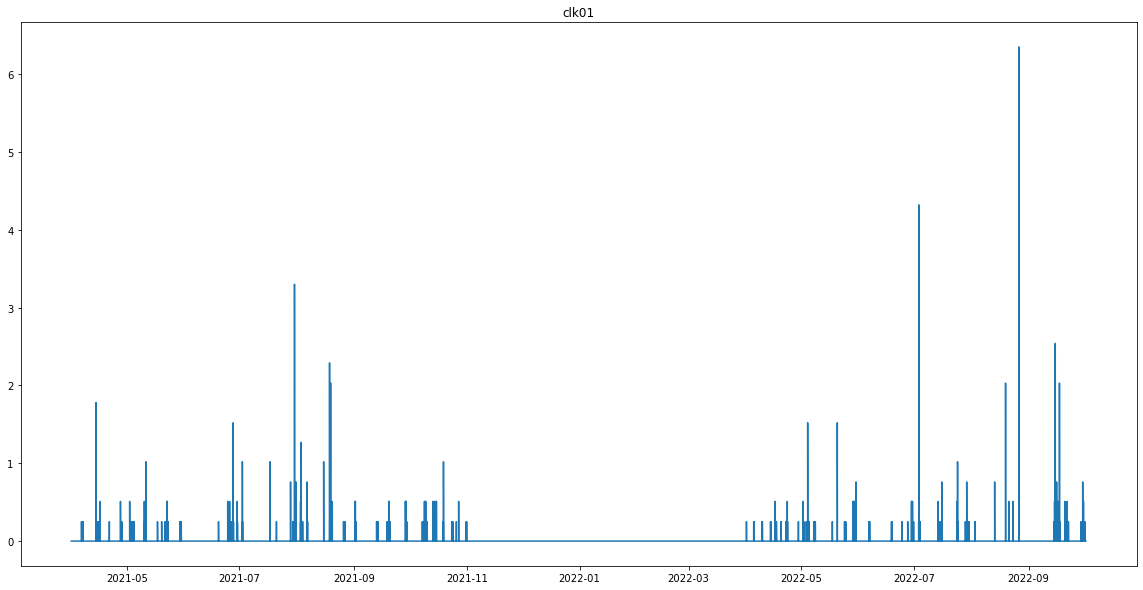

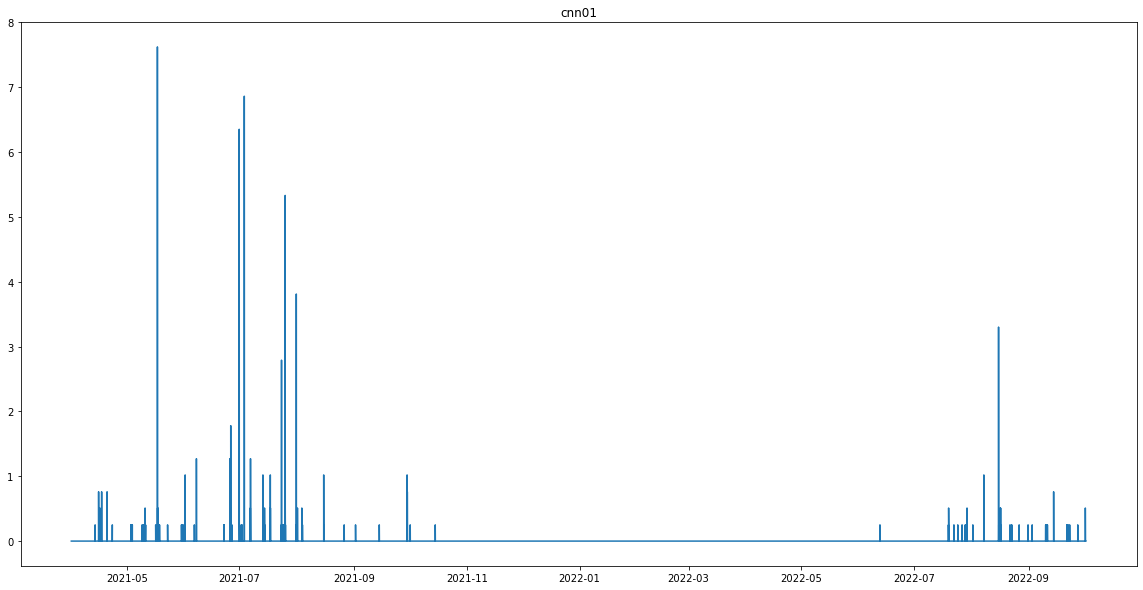

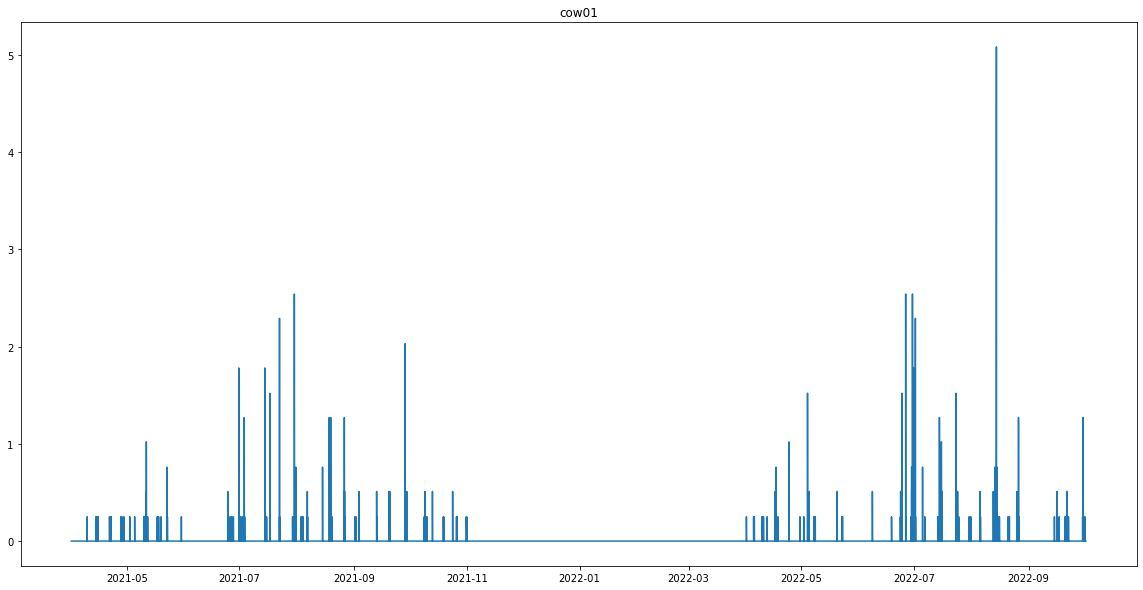

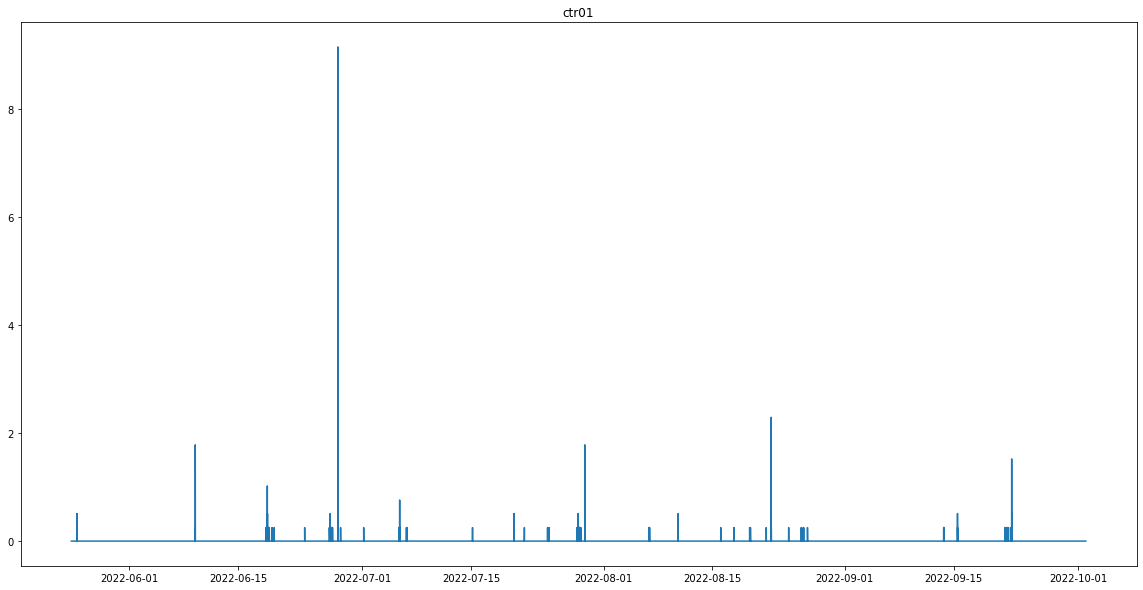

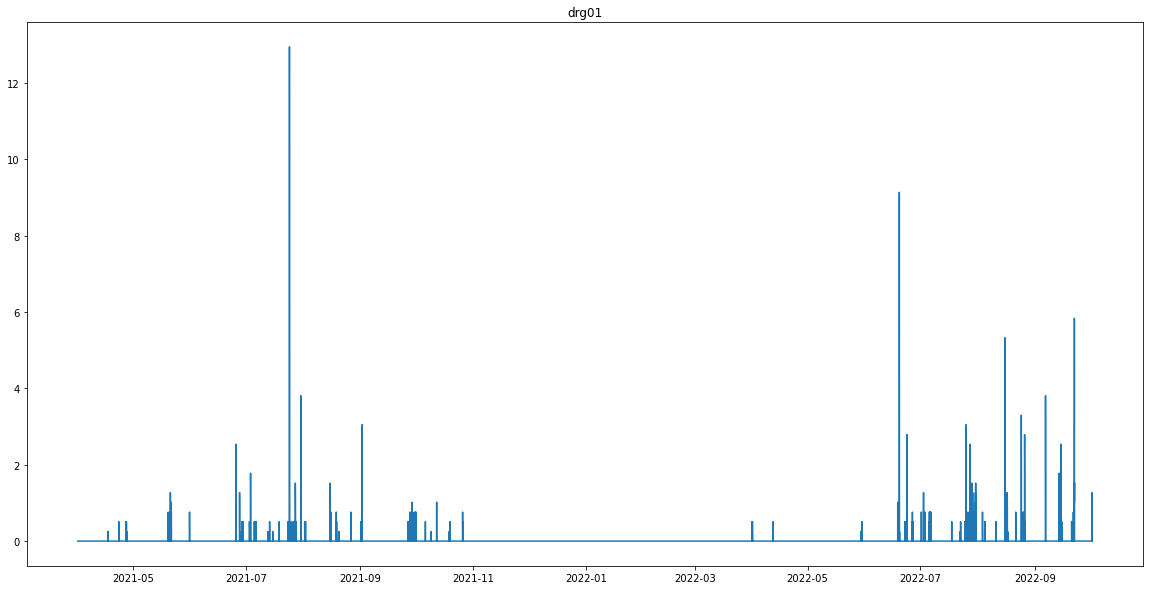

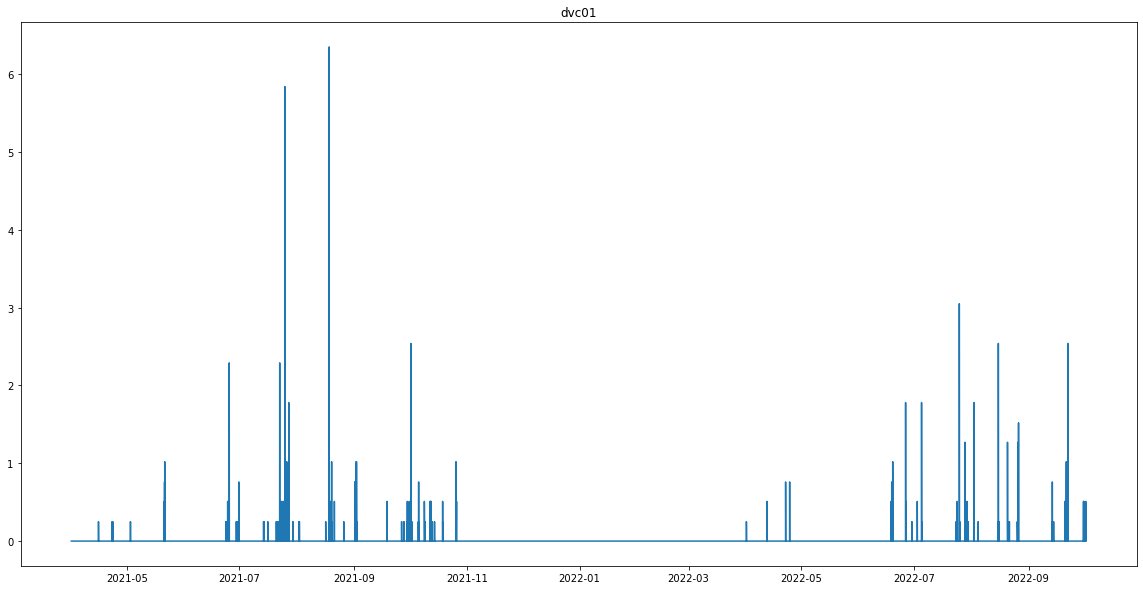

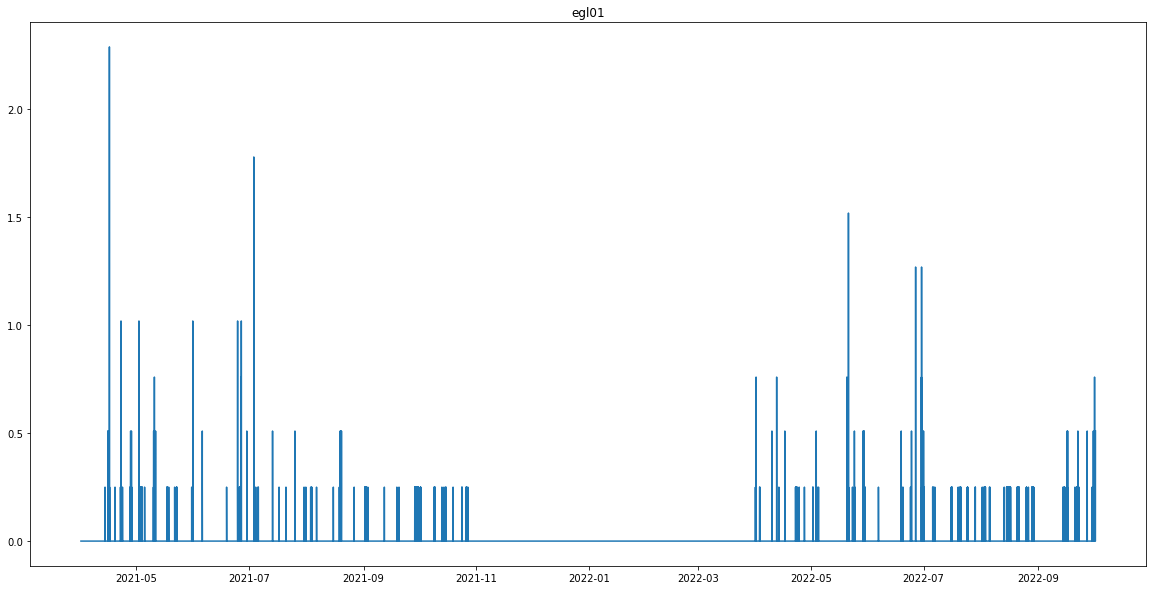

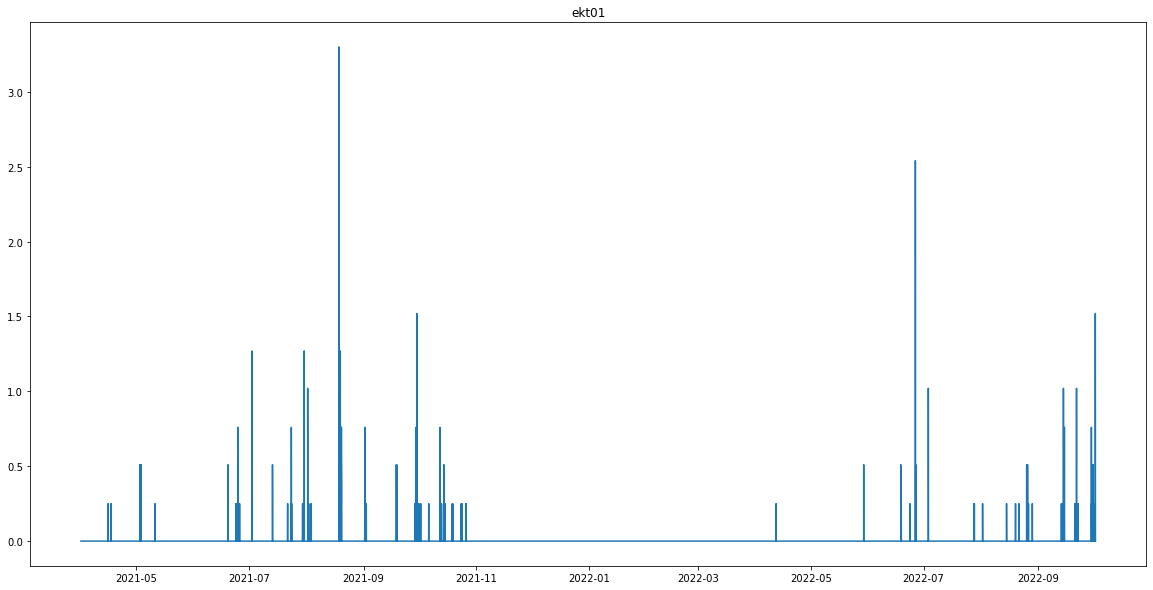

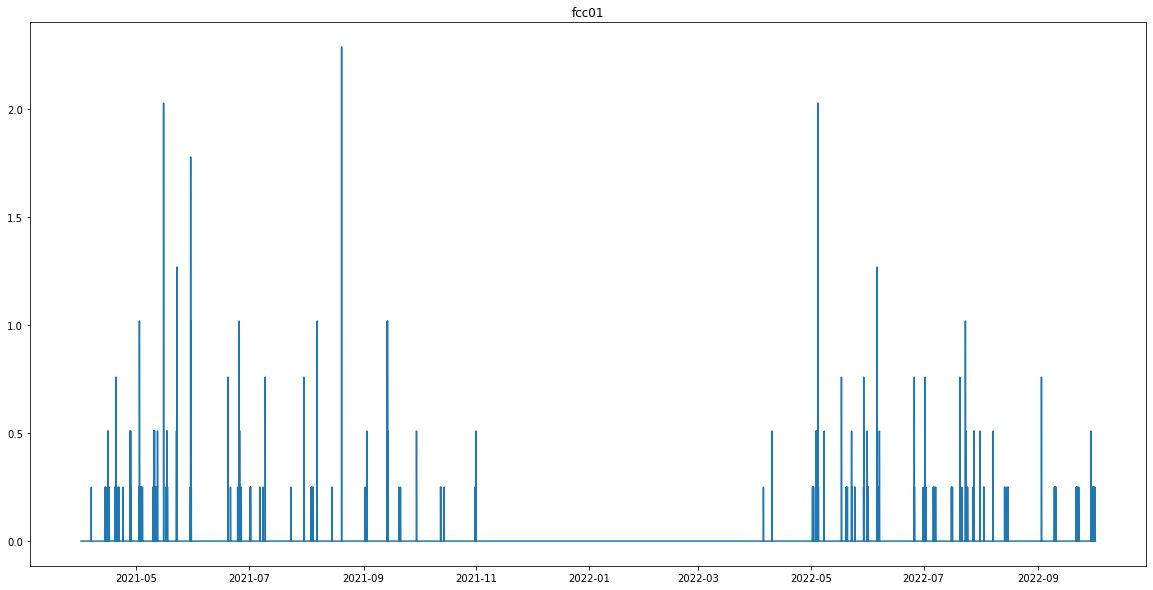

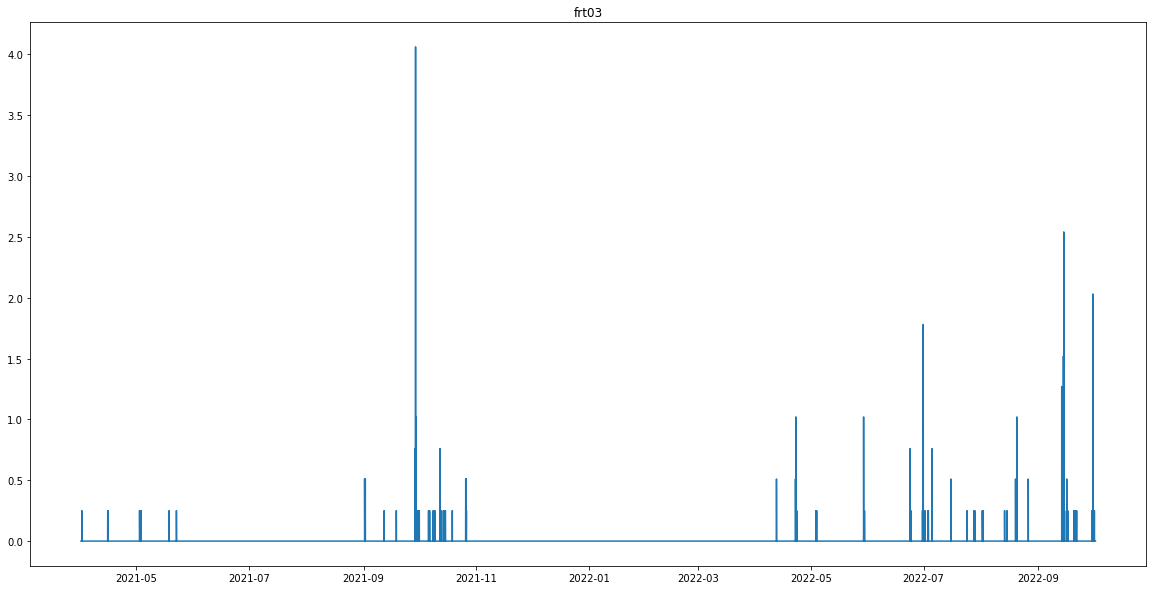

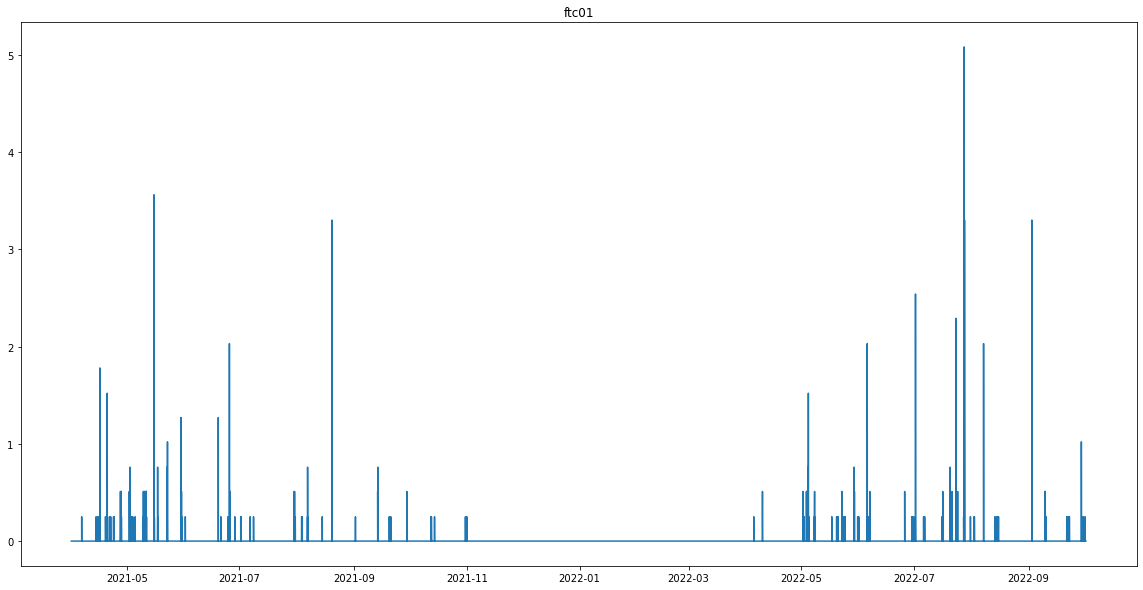

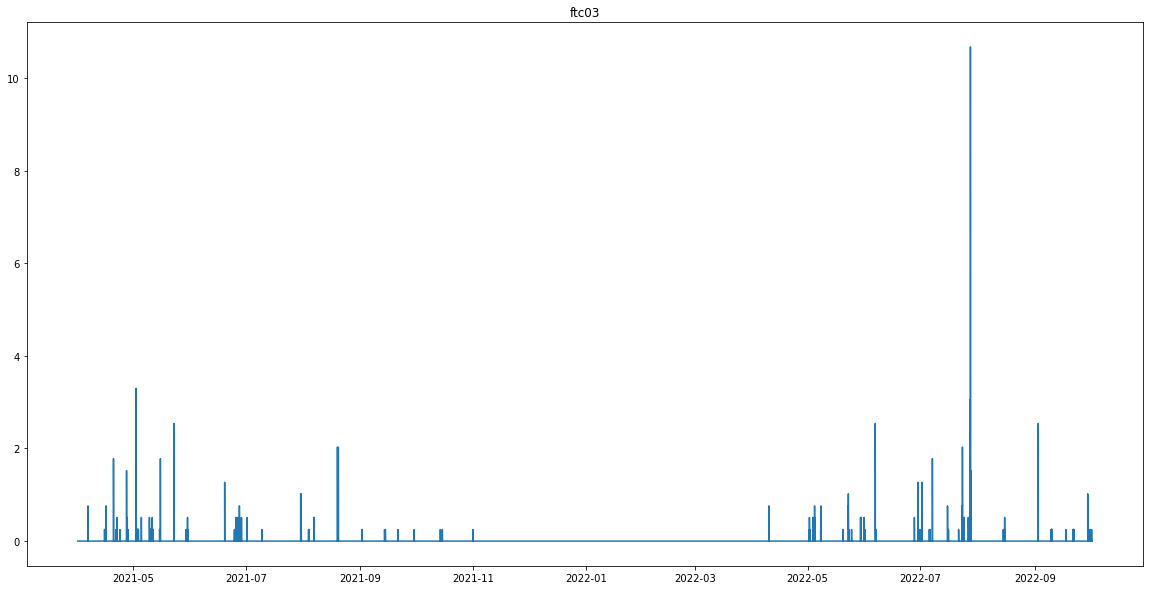

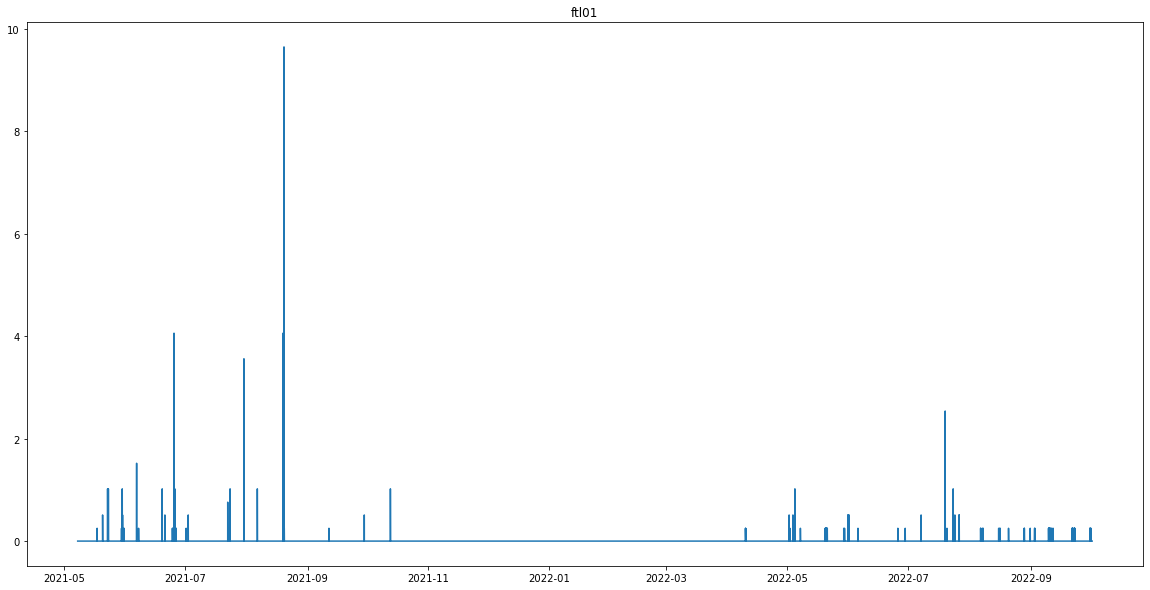

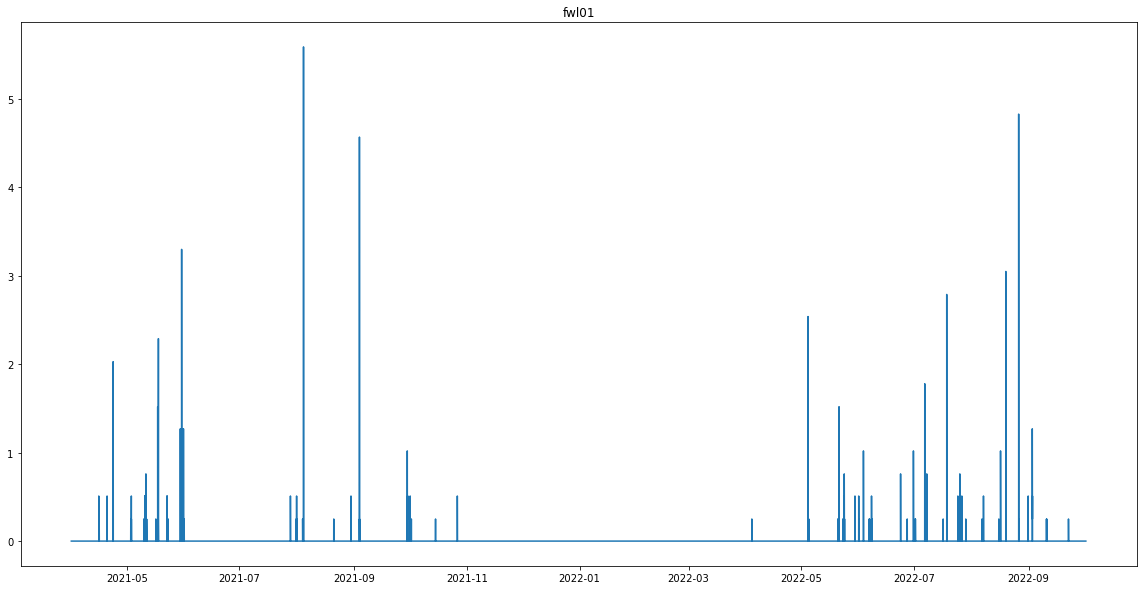

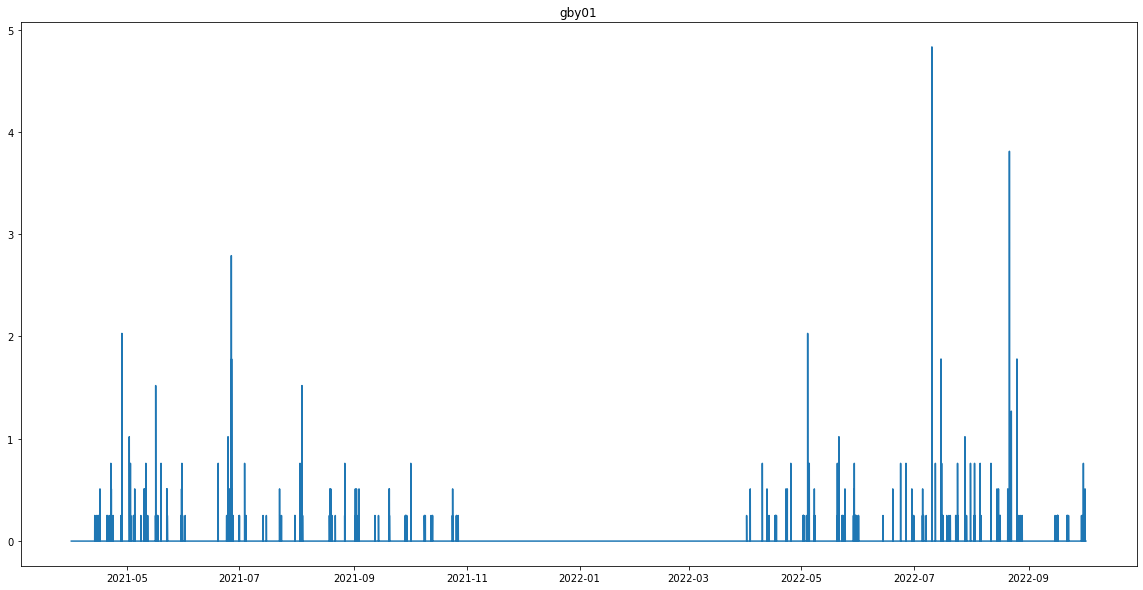

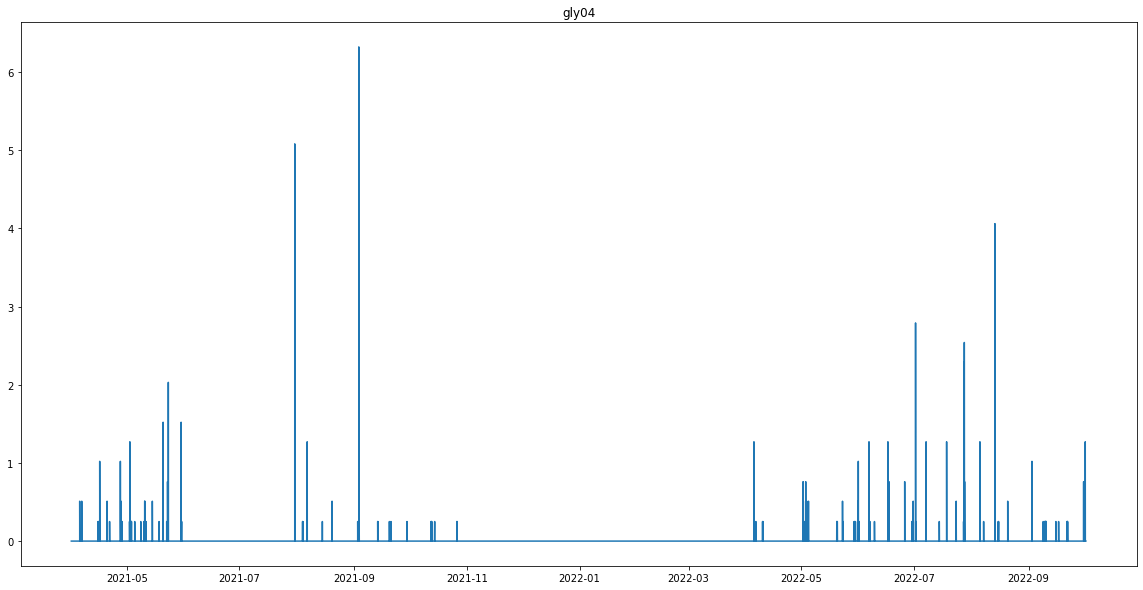

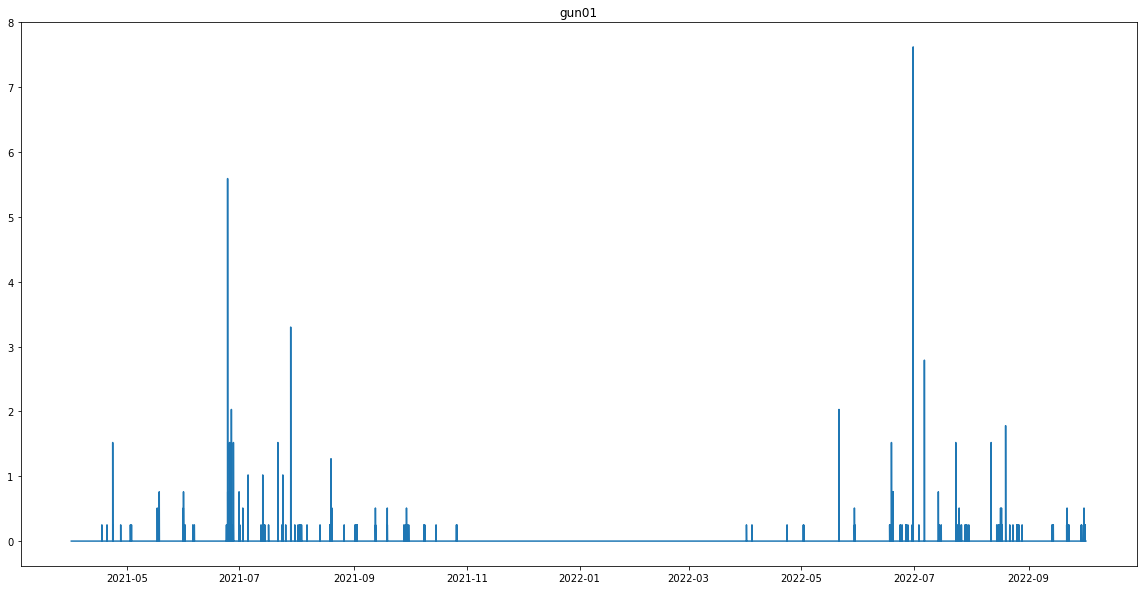

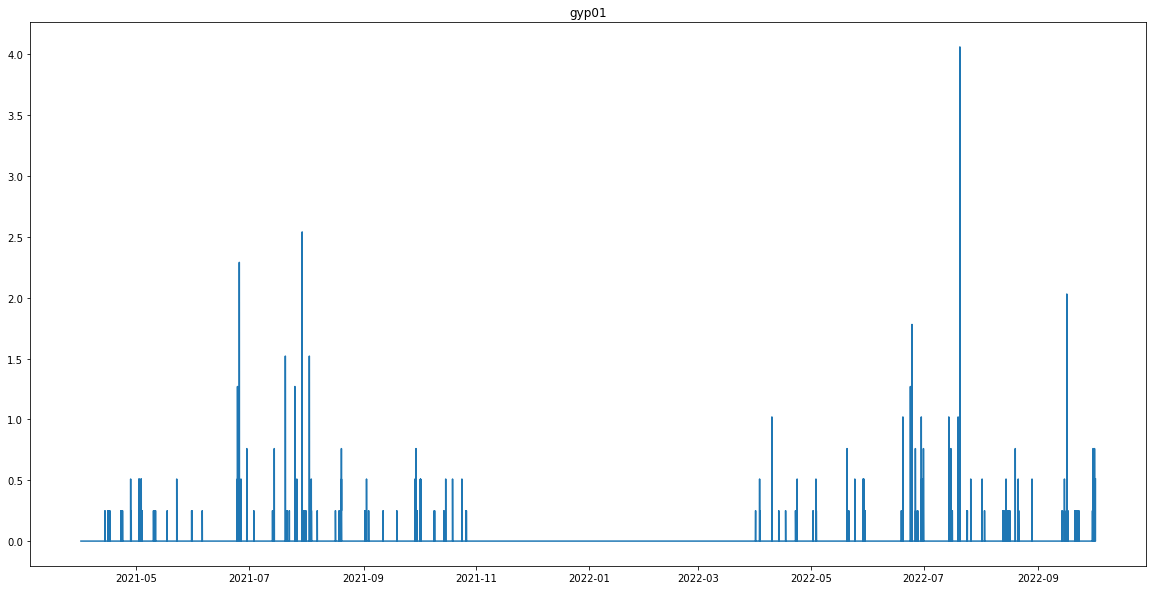

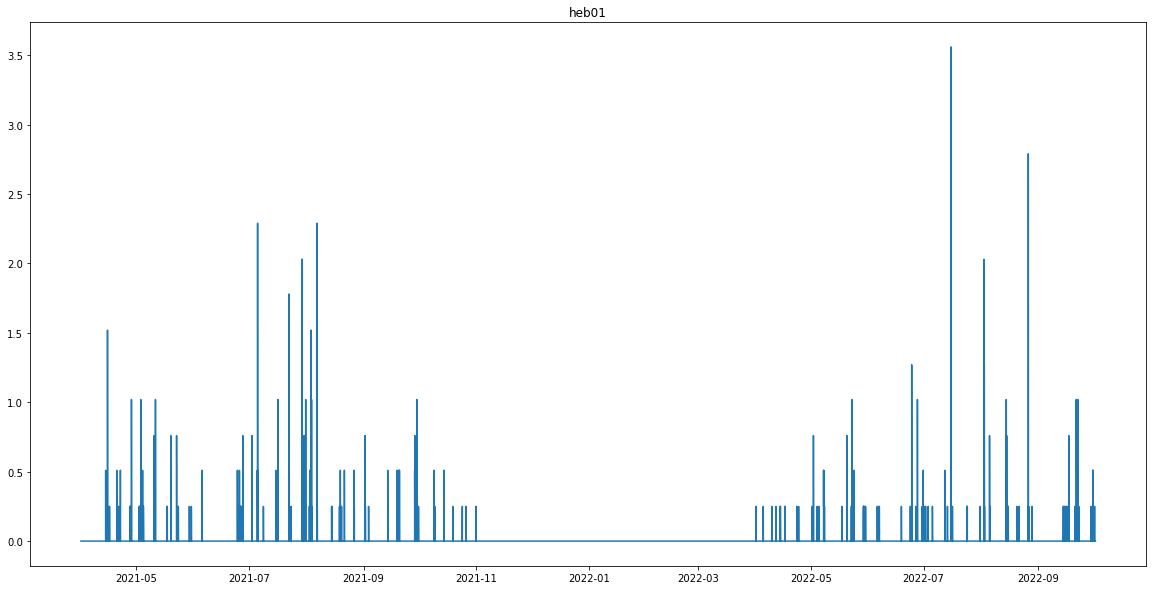

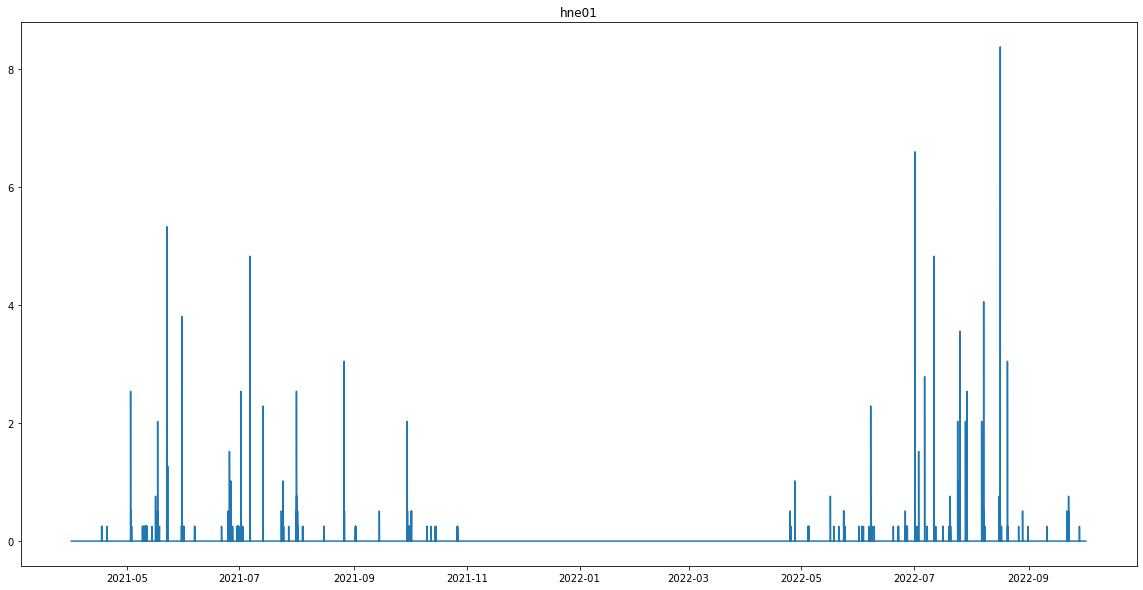

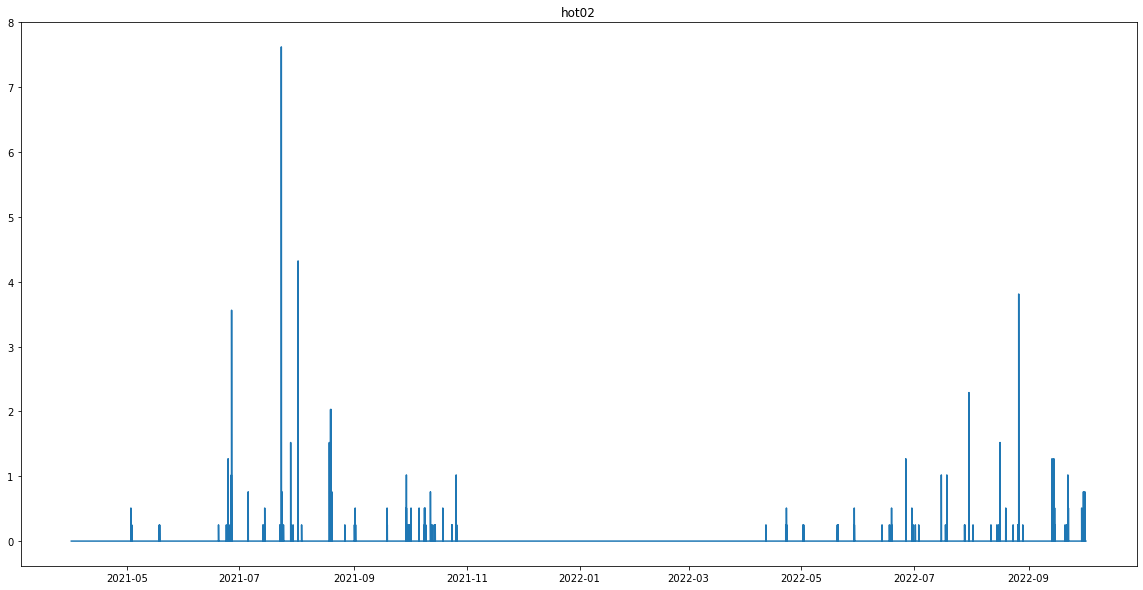

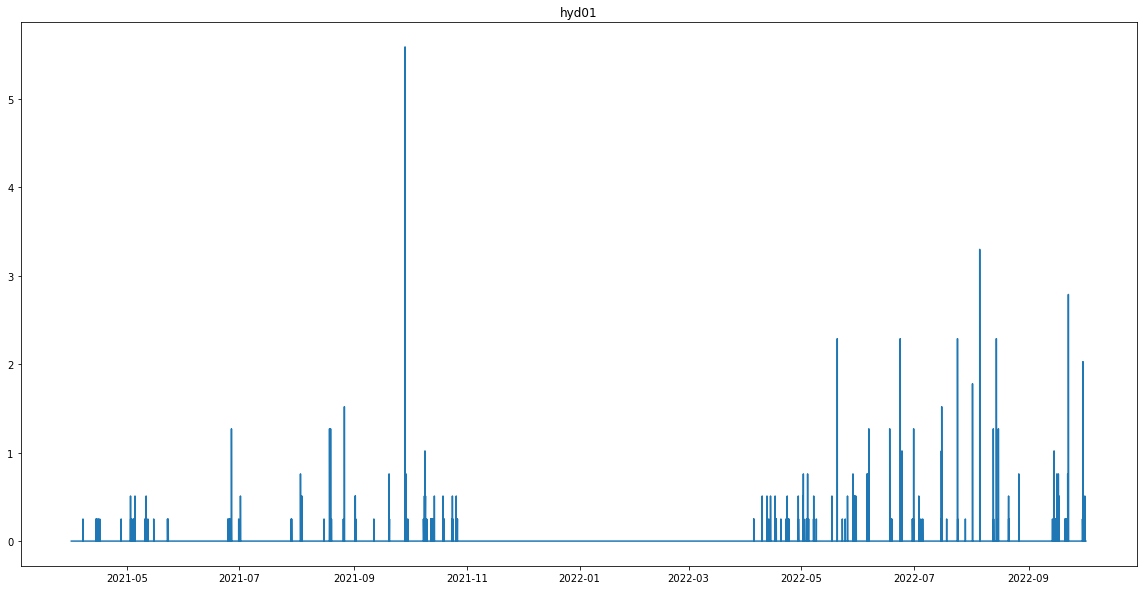

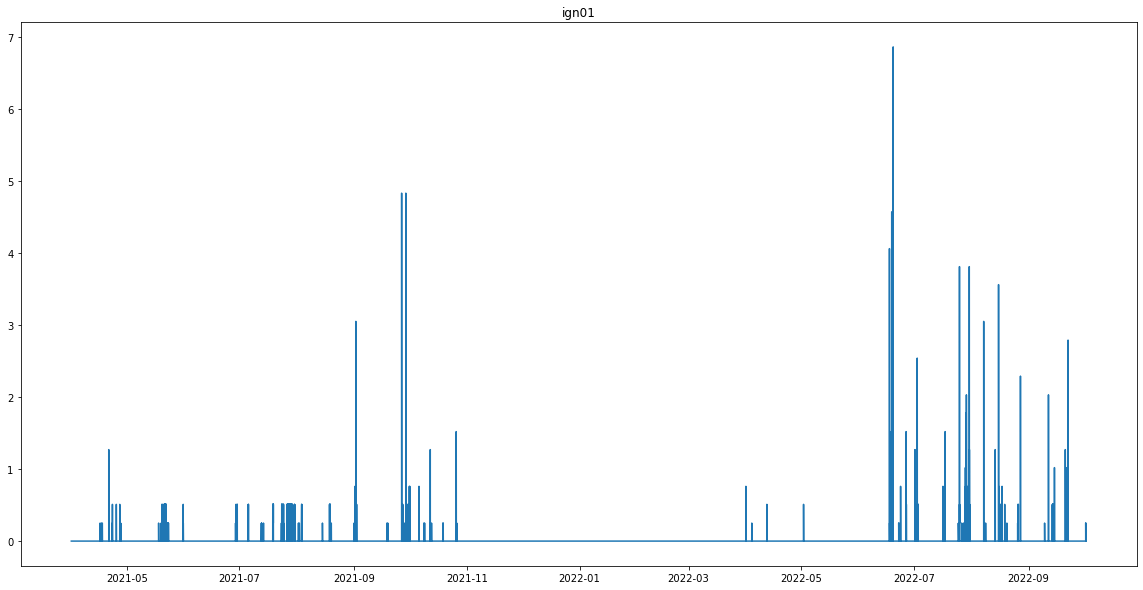

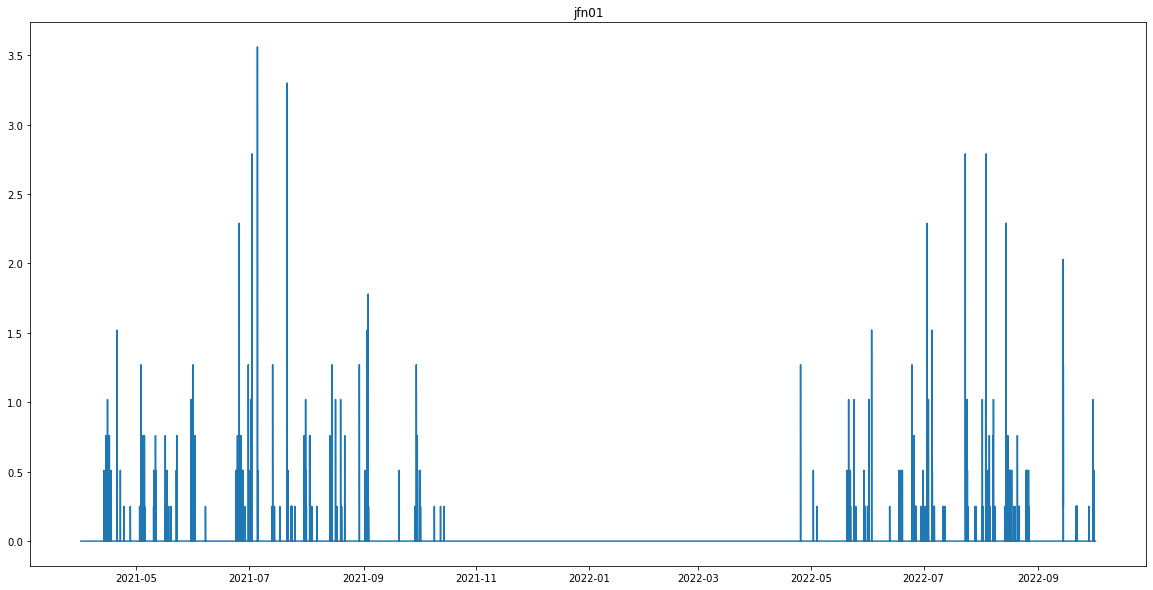

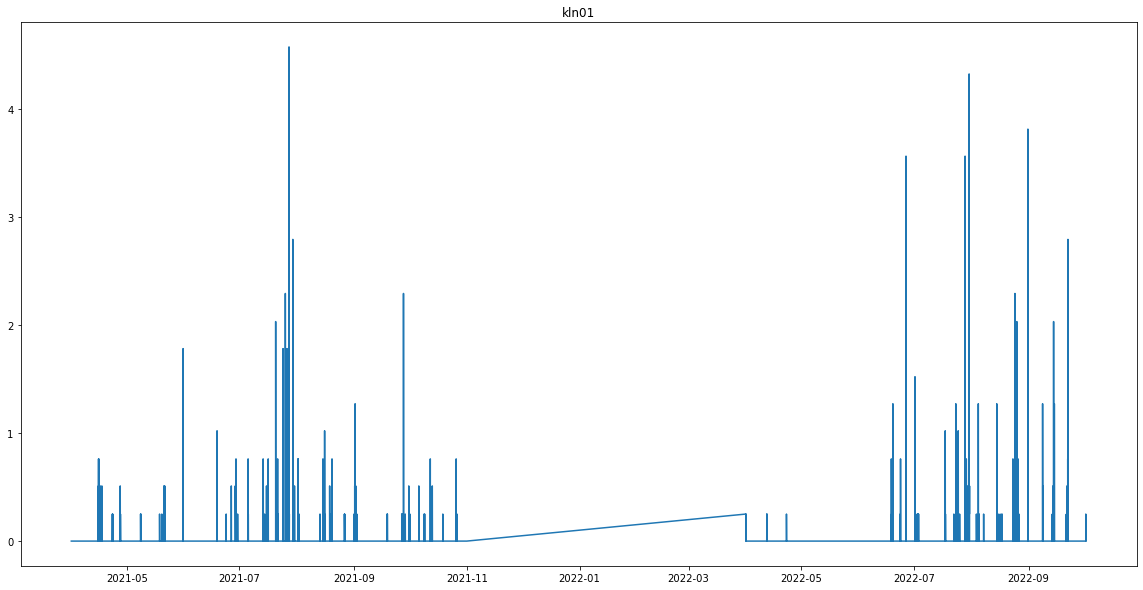

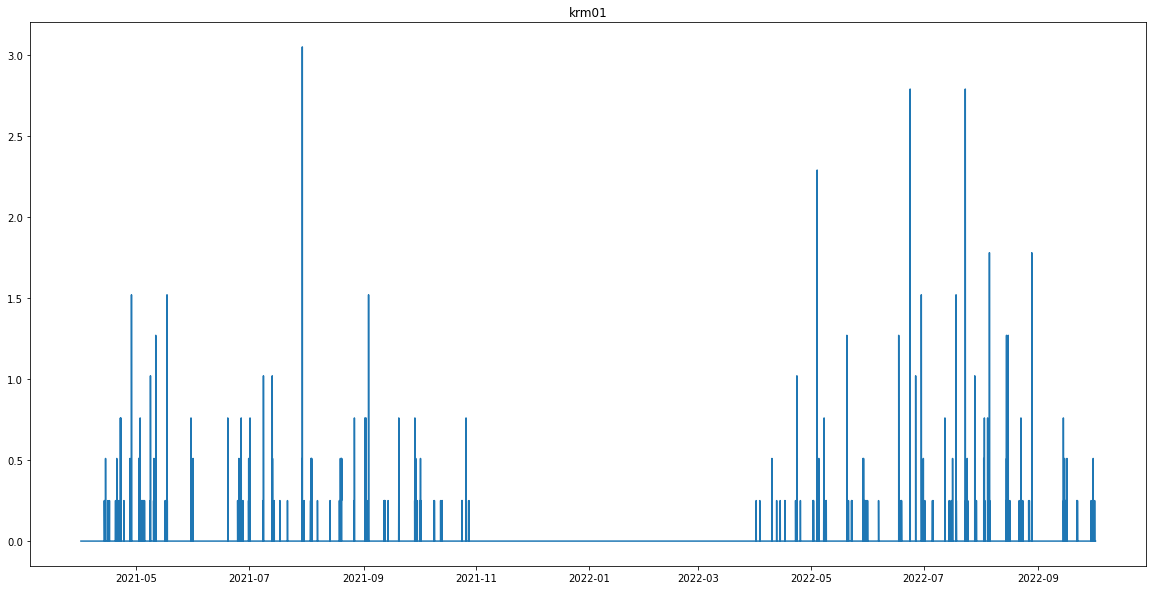

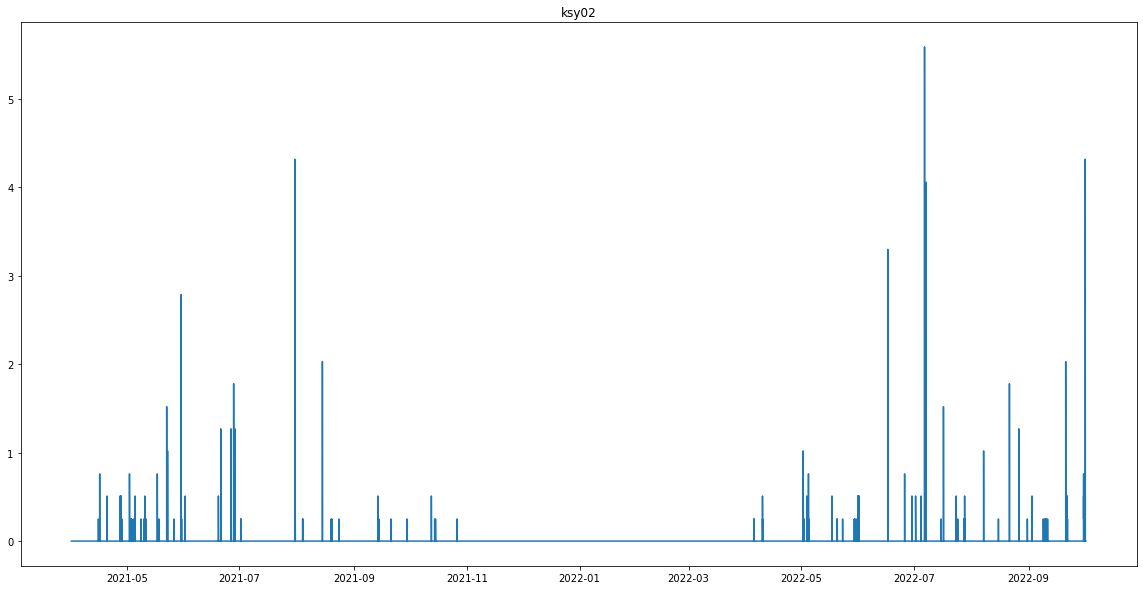

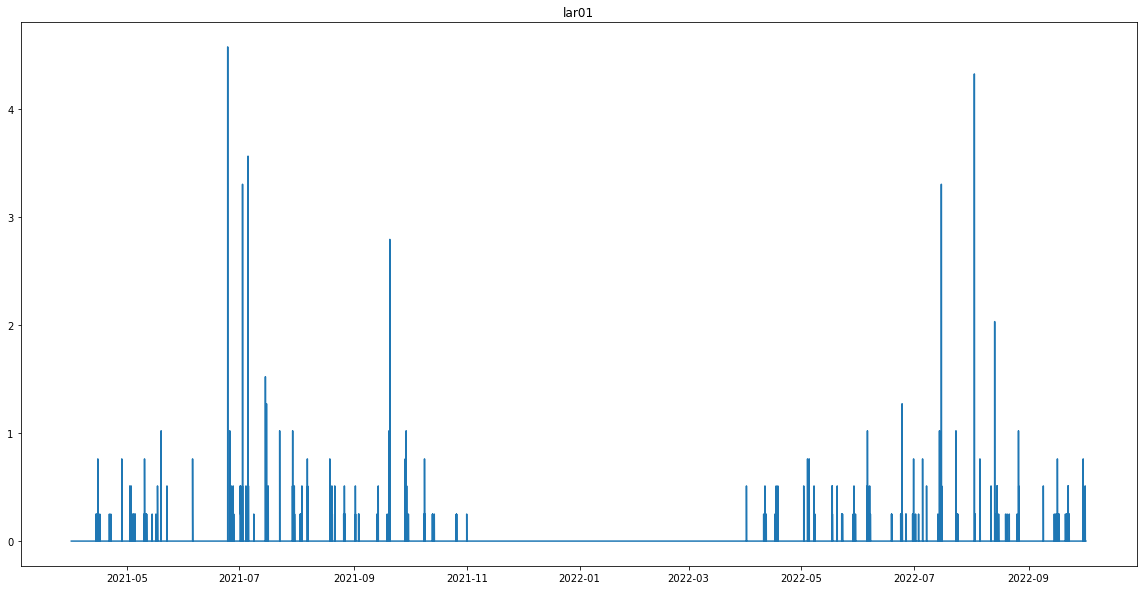

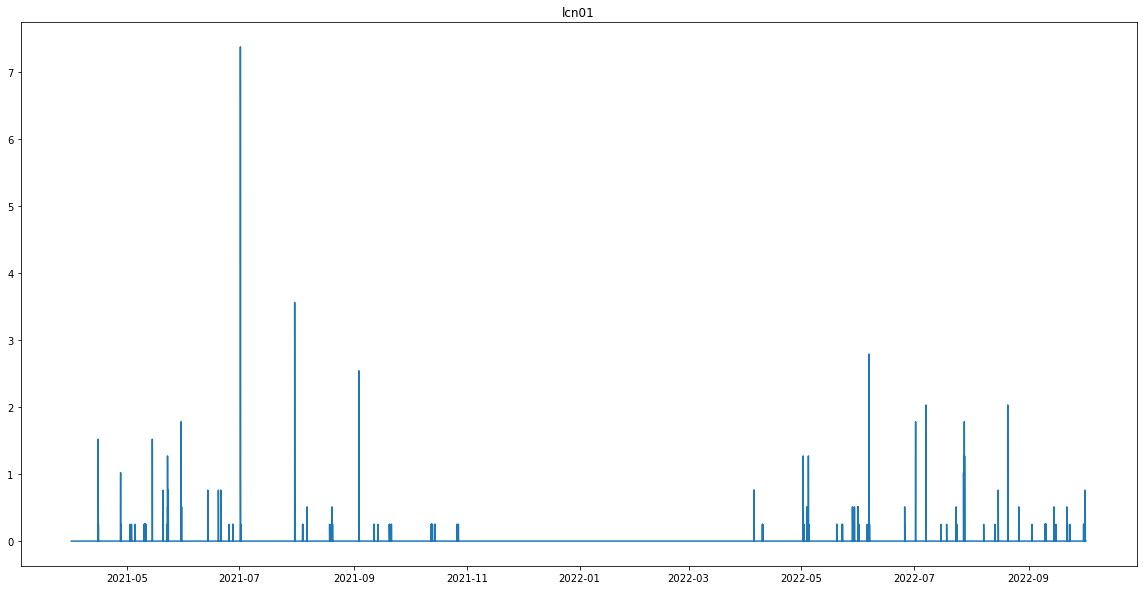

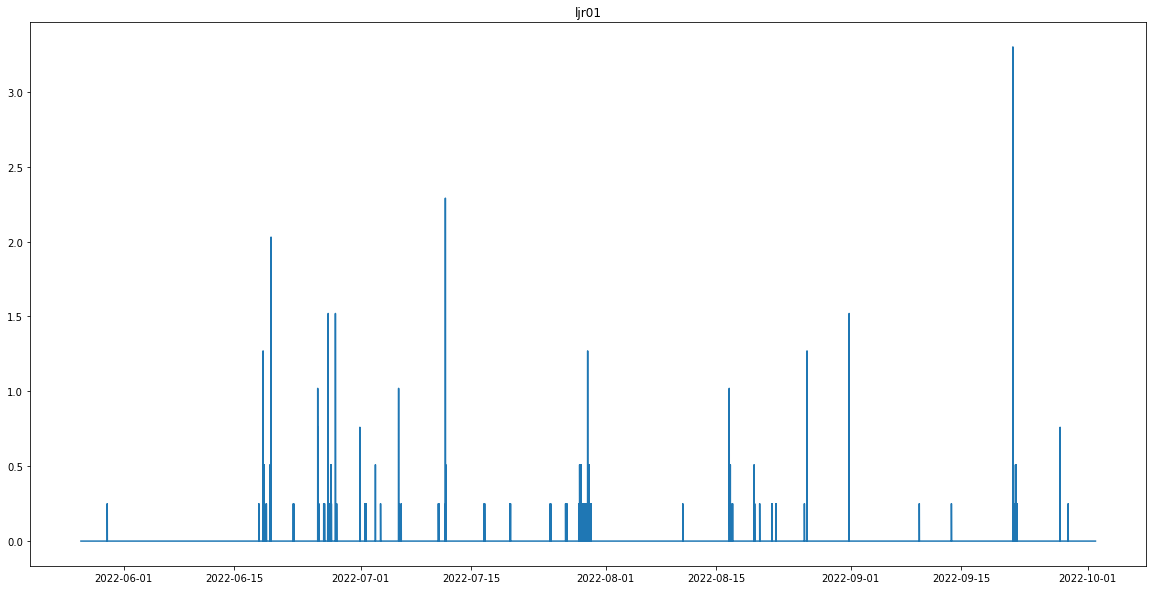

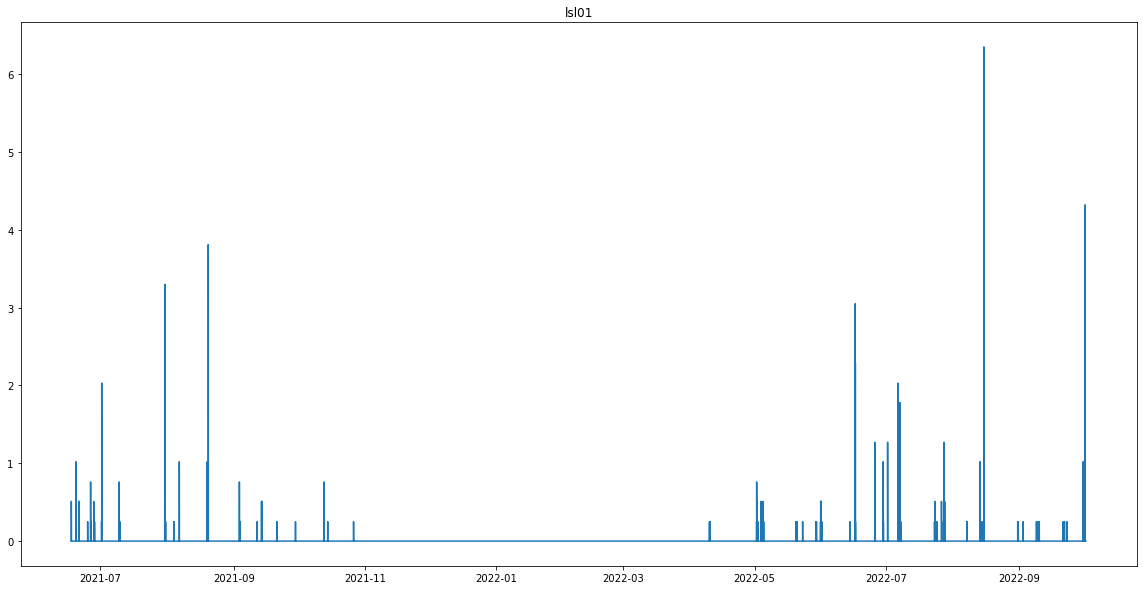

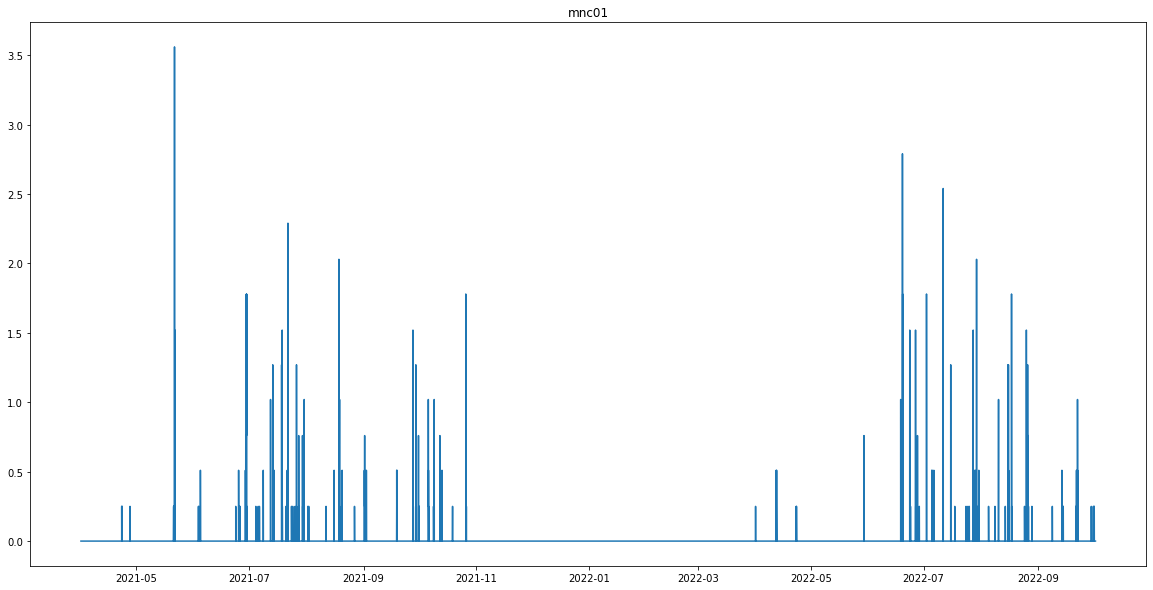

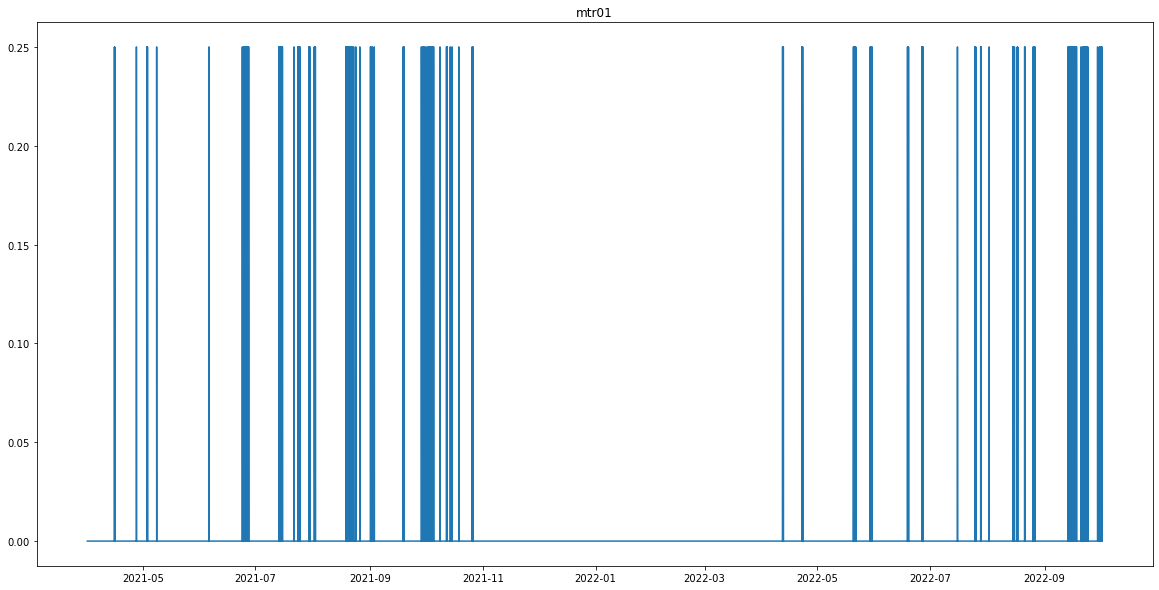

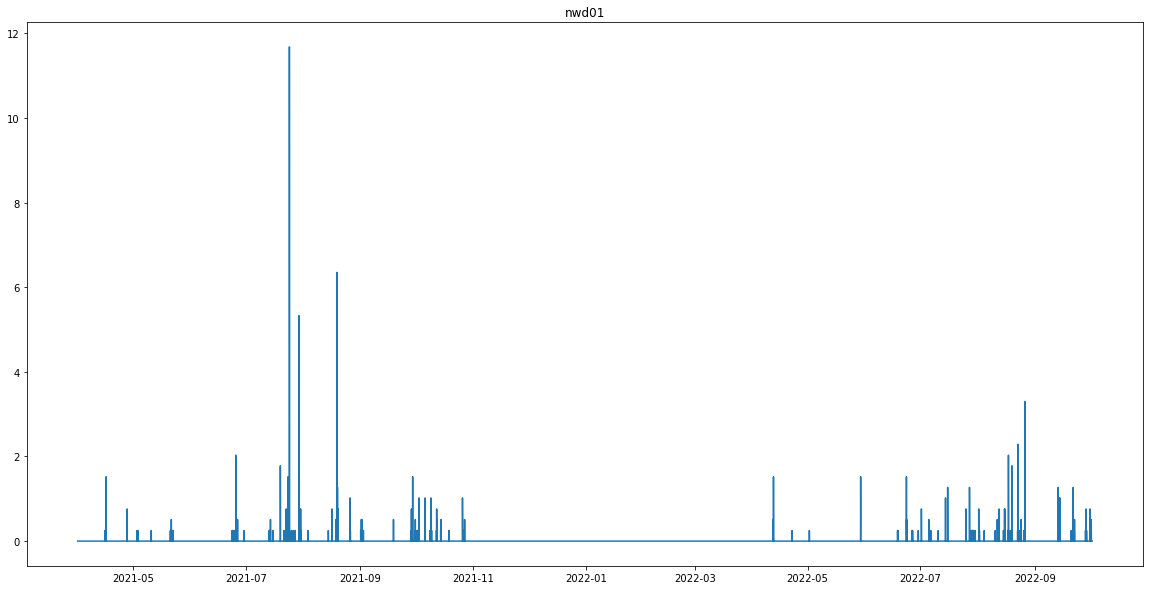

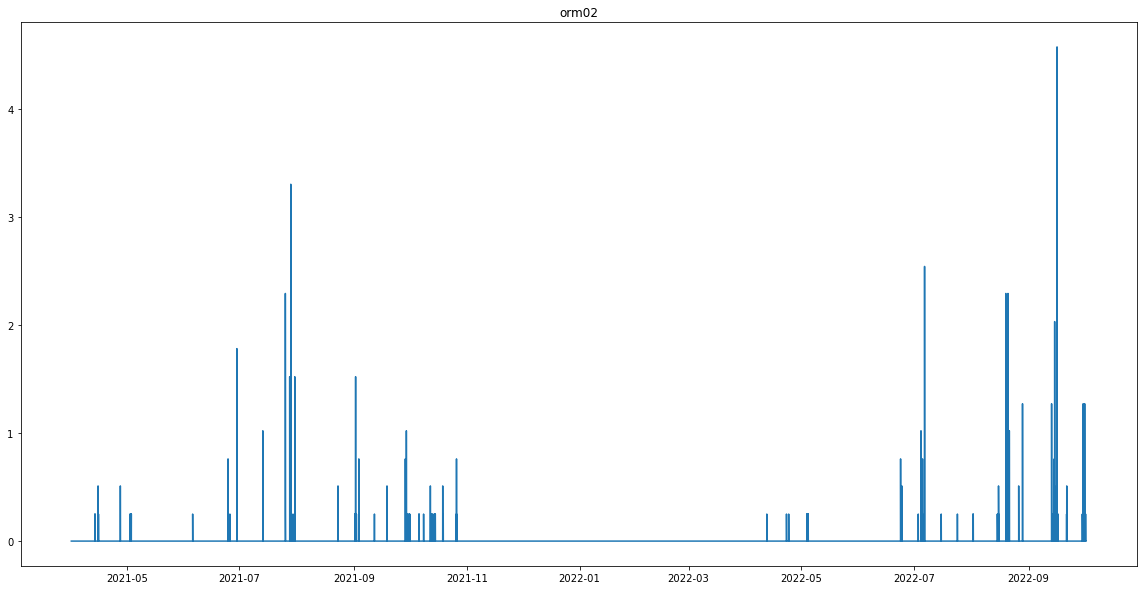

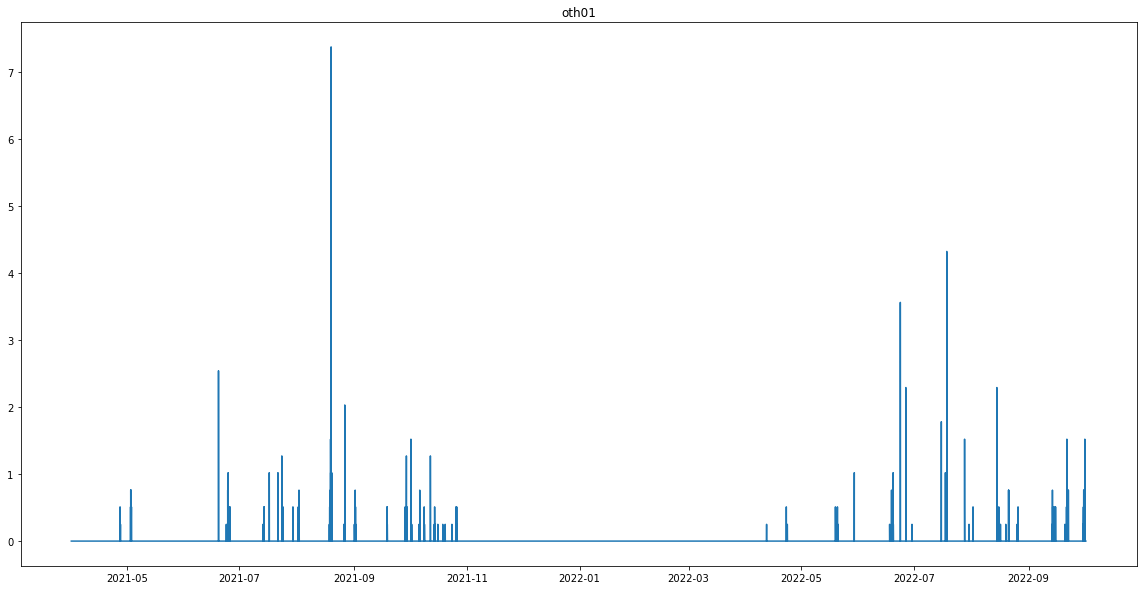

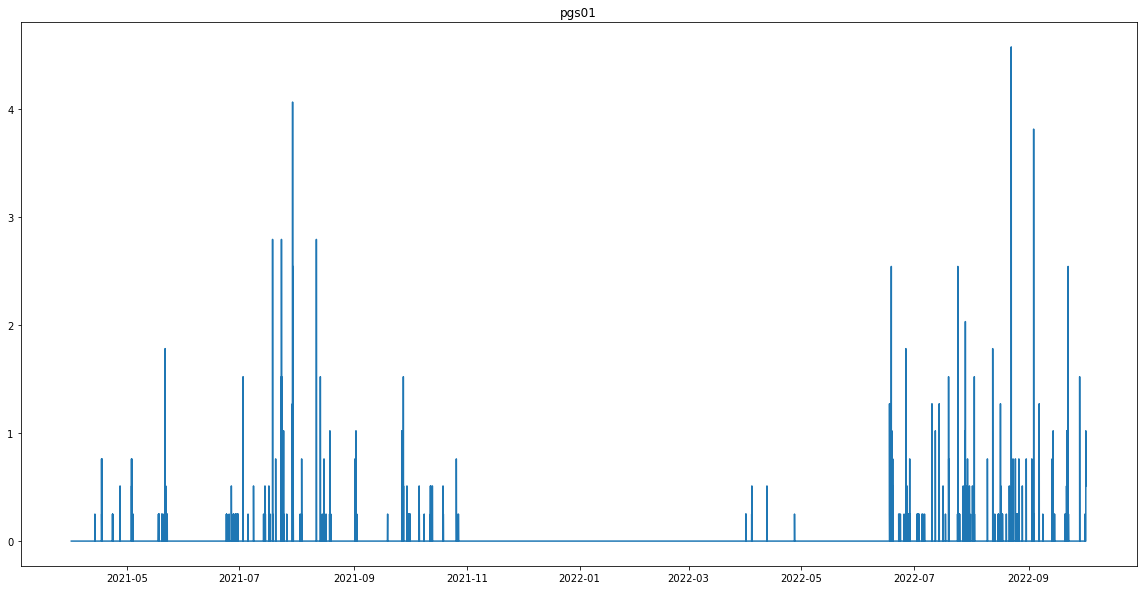

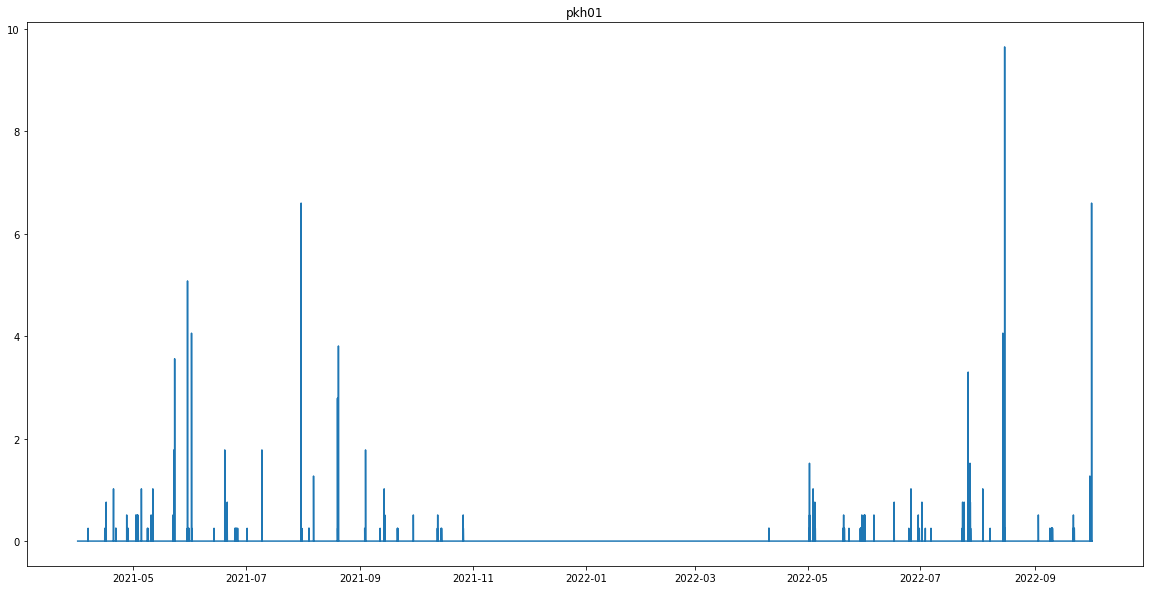

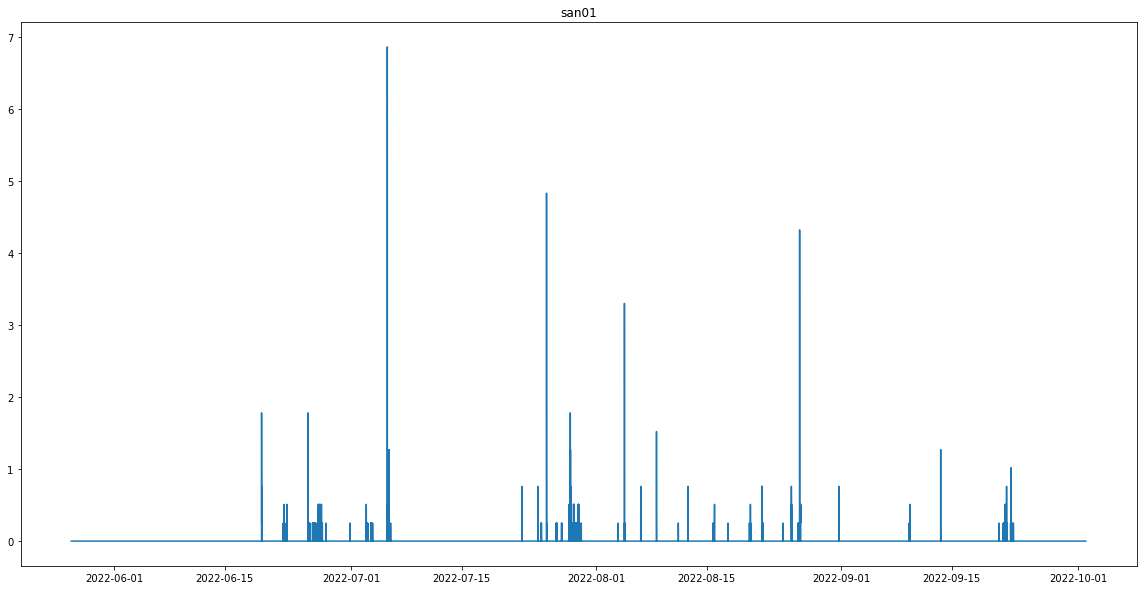

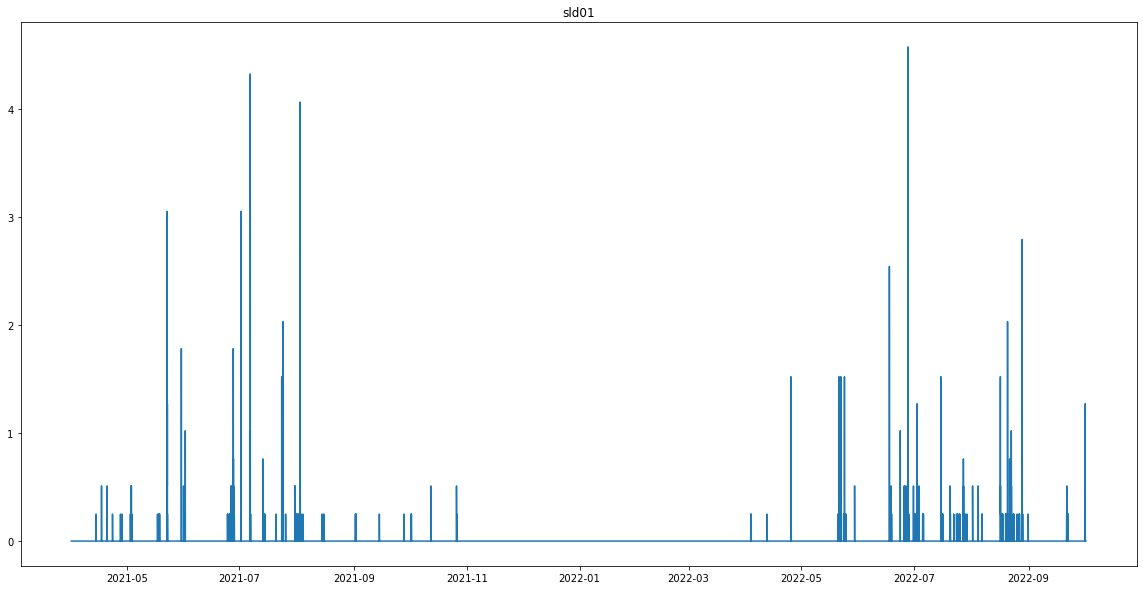

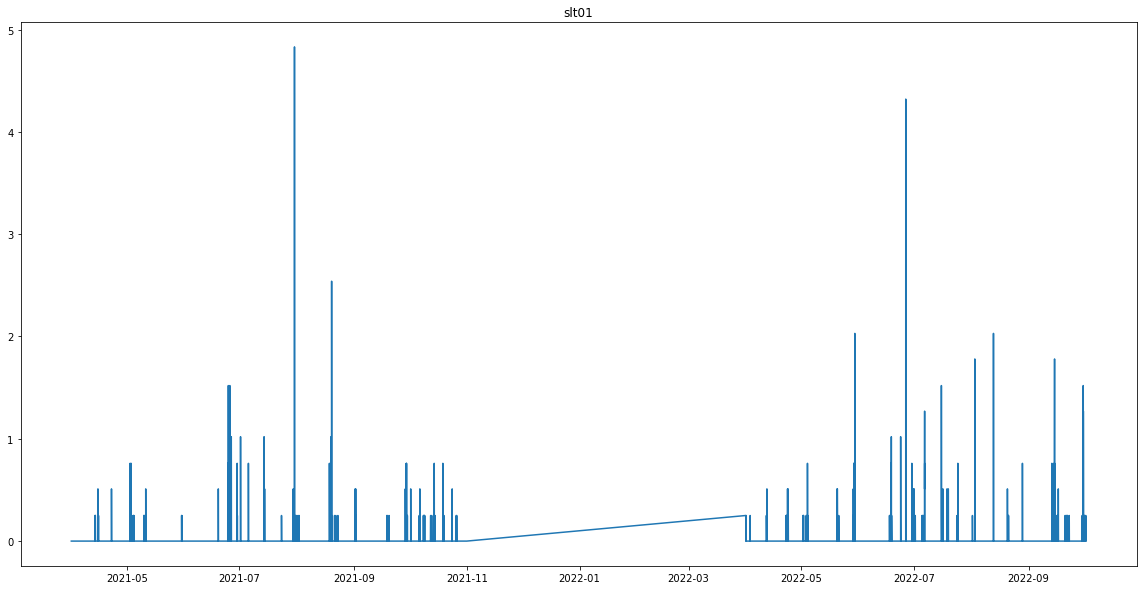

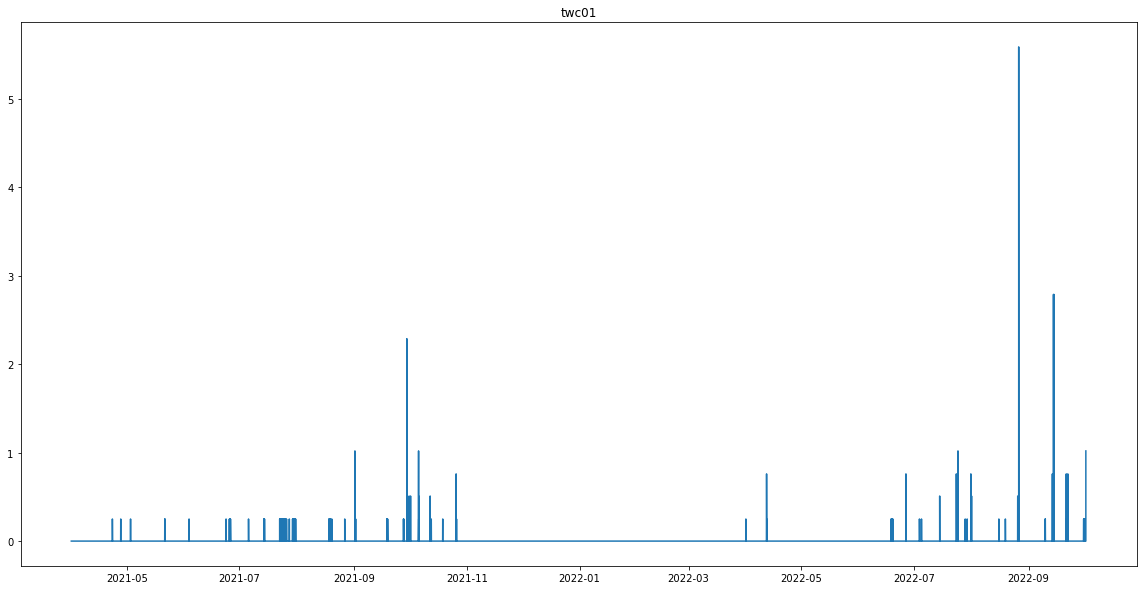

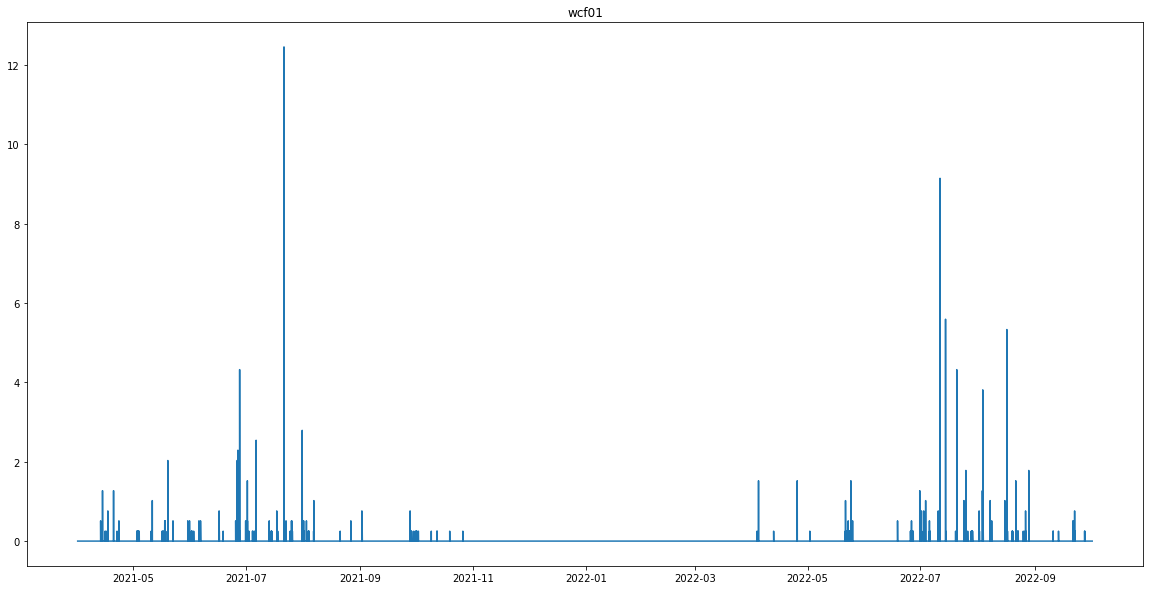

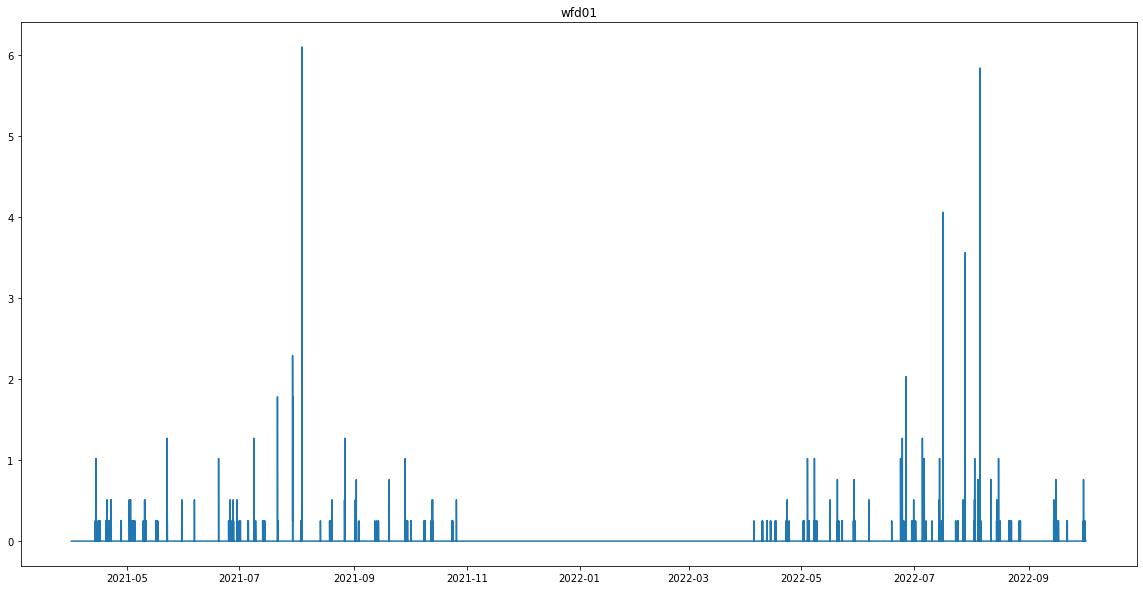

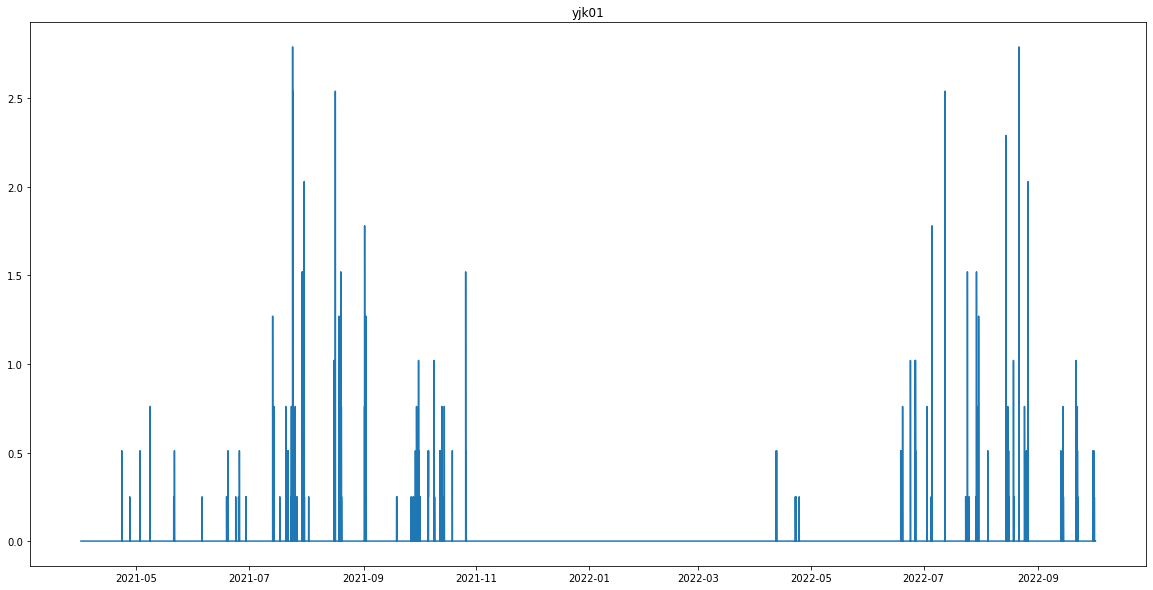

In [113]:
# look for questionable readings

for i in range(len(gage_raw)):
    fig = plt.figure(1, figsize=(20,10))
    plt.plot(gage_raw[i]['accum'])
    plt.title(gage_location.Station.values[i])
    plt.show()

In [108]:
gage_location = gage_location.loc[gage_location.Station!='mtr01']

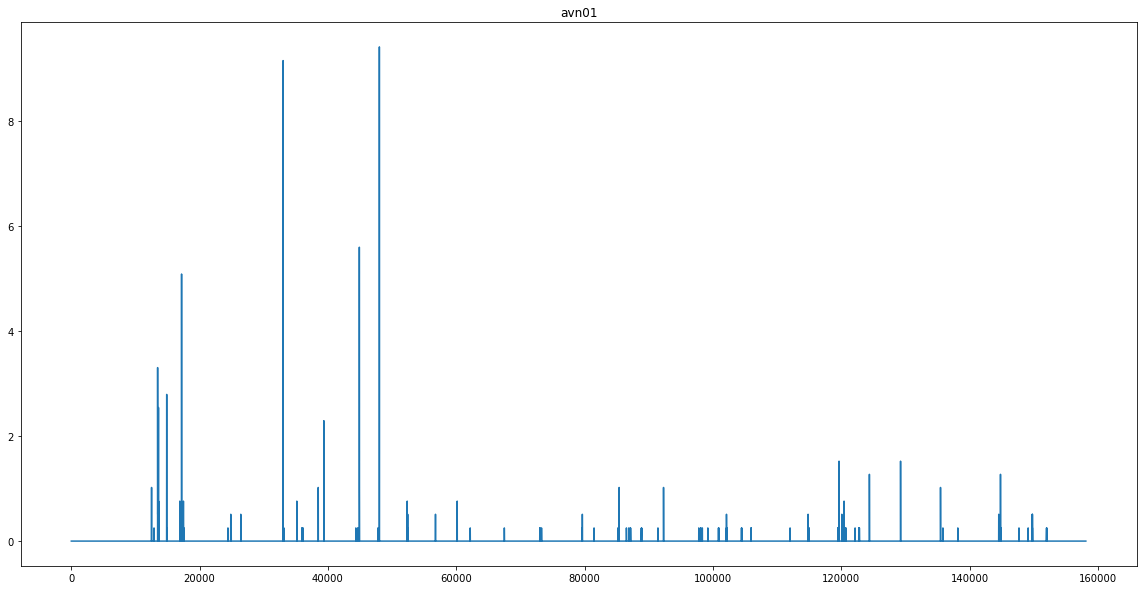

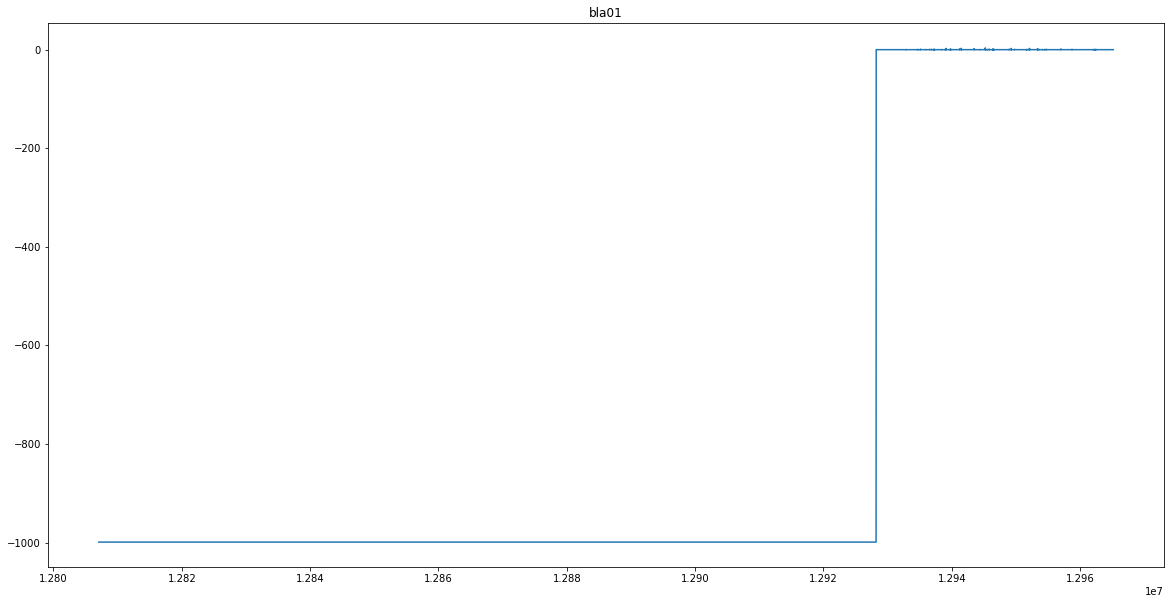

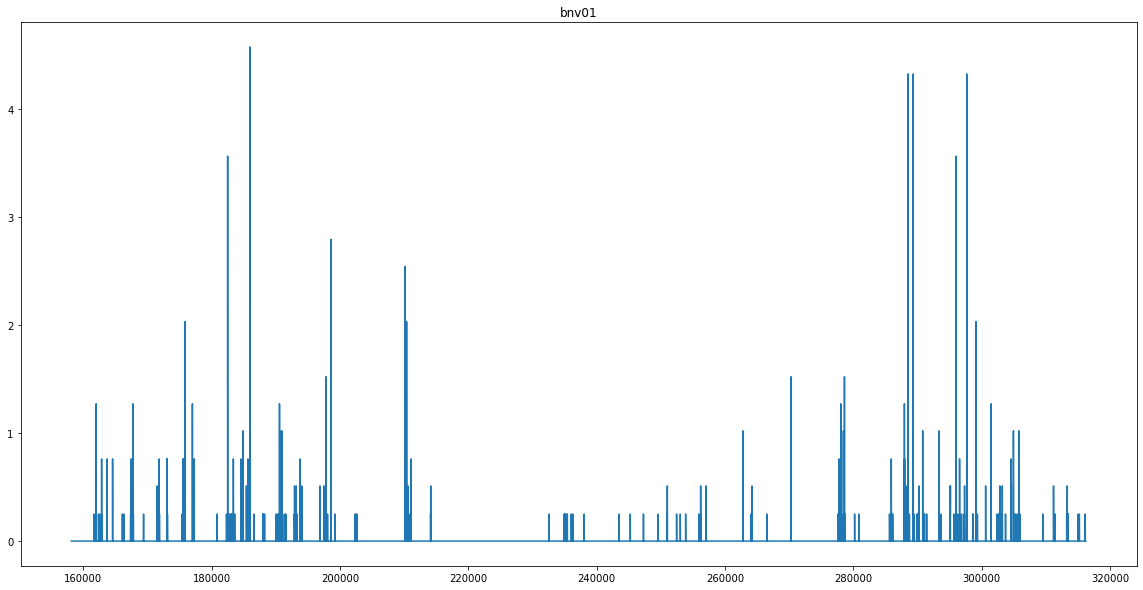

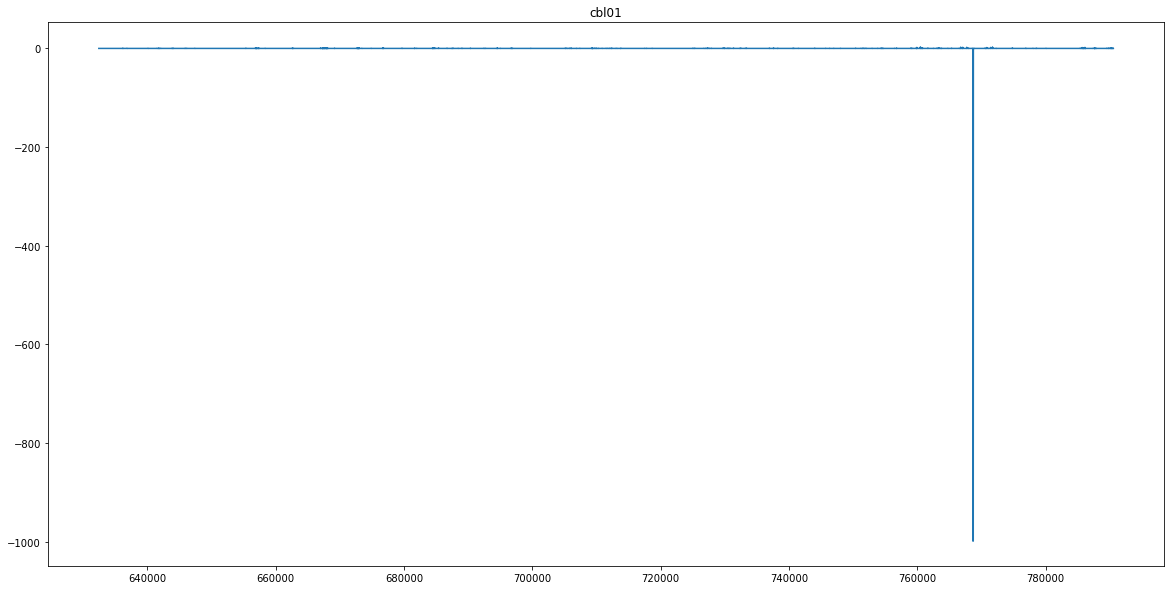

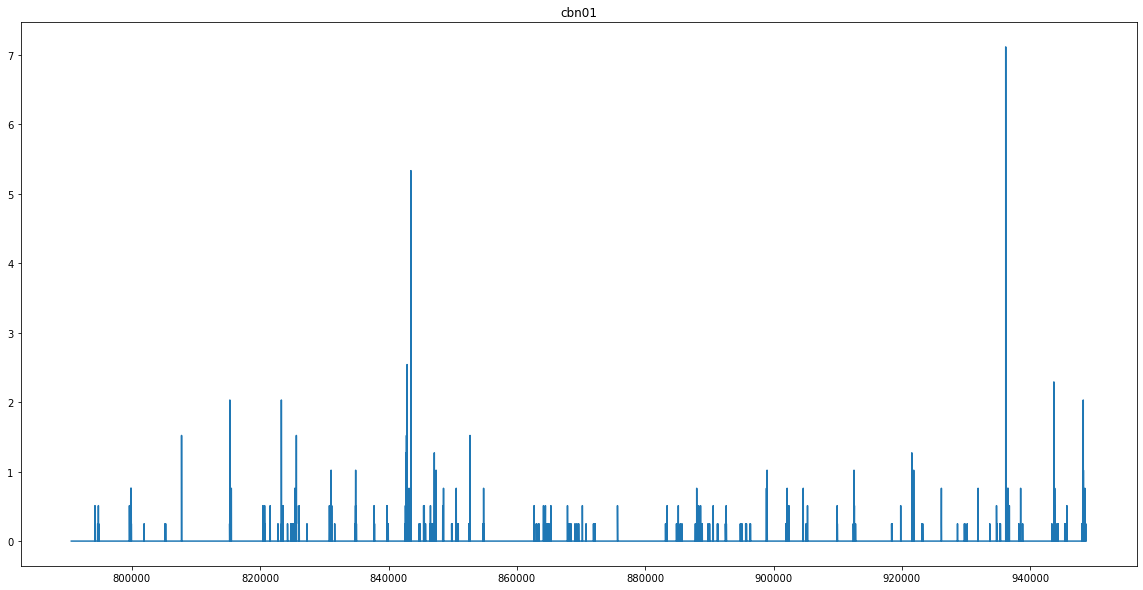

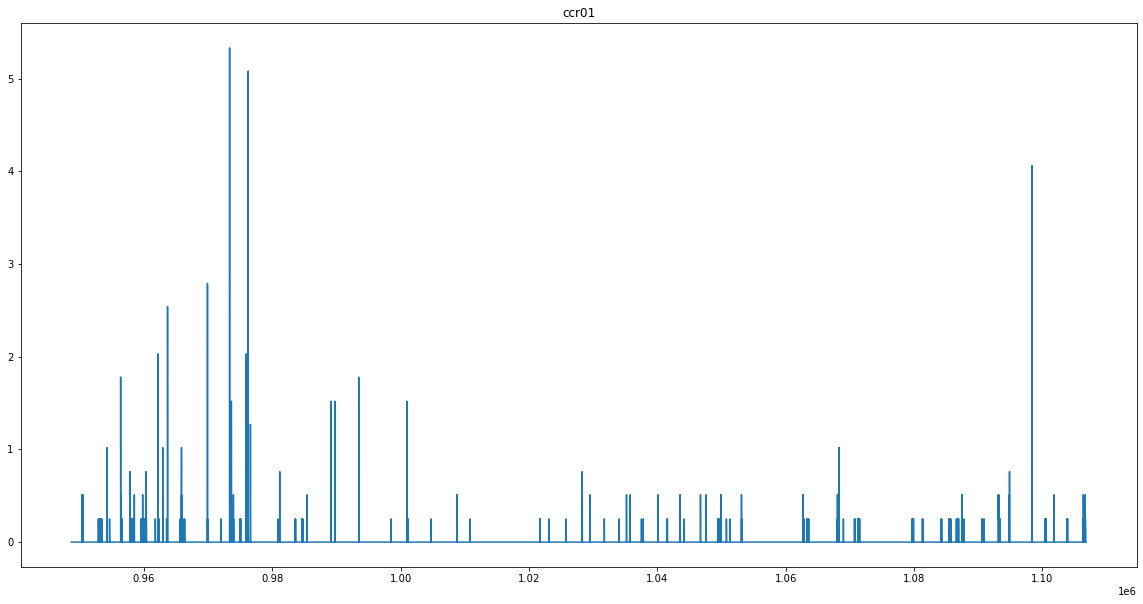

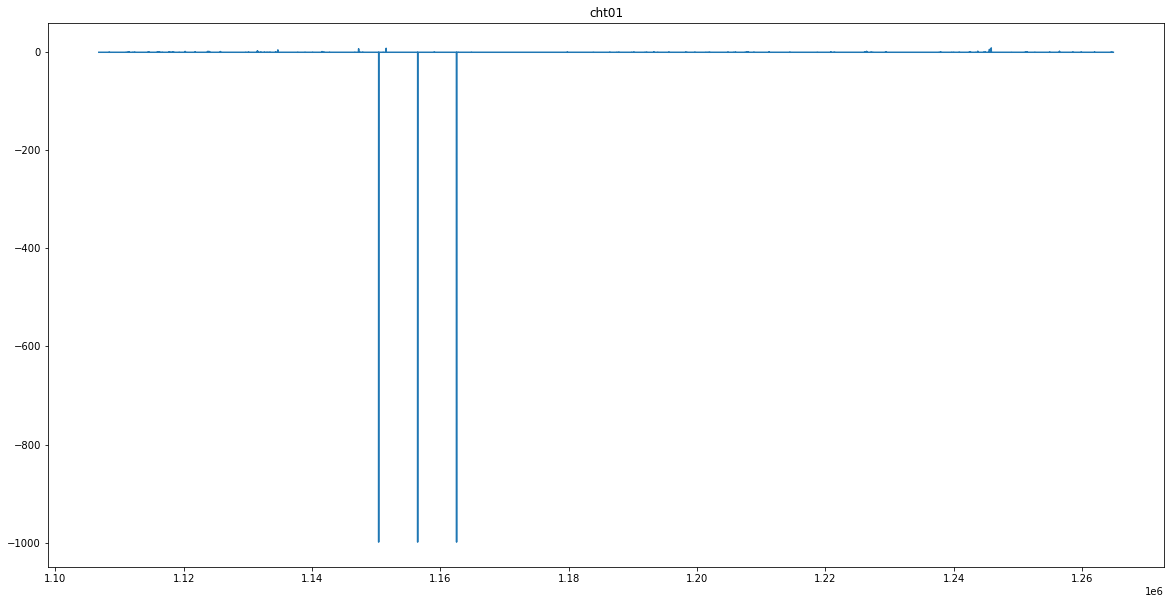

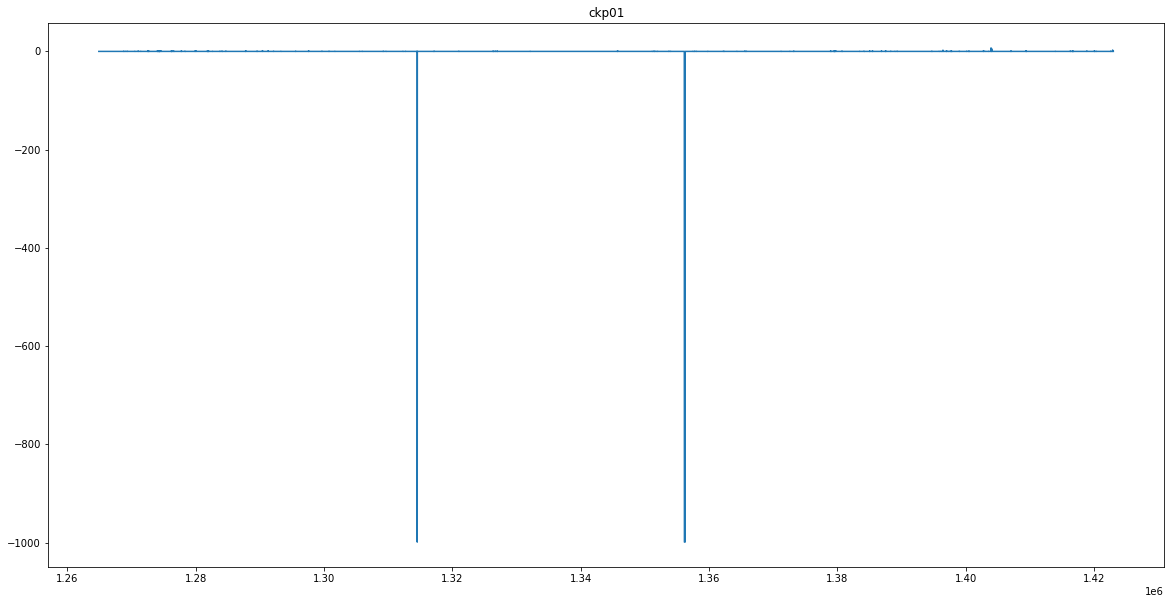

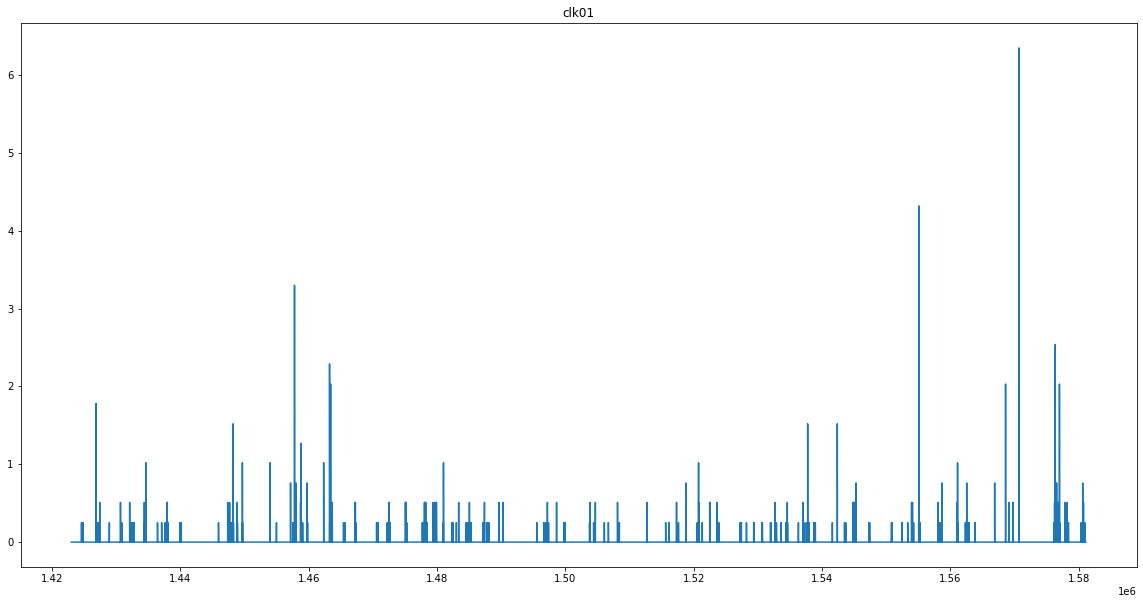

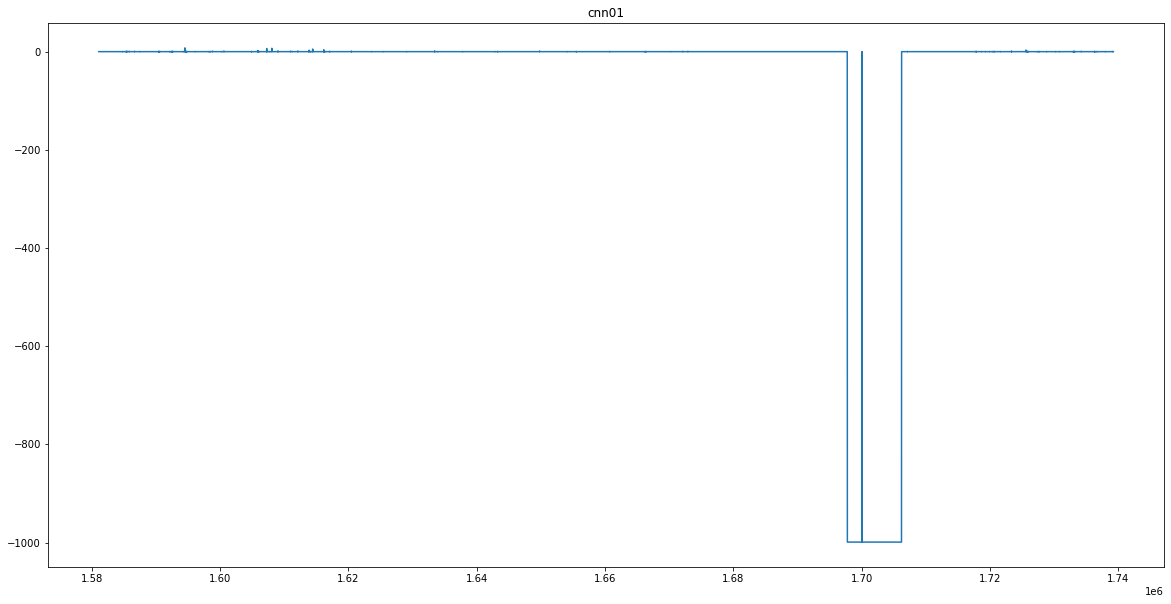

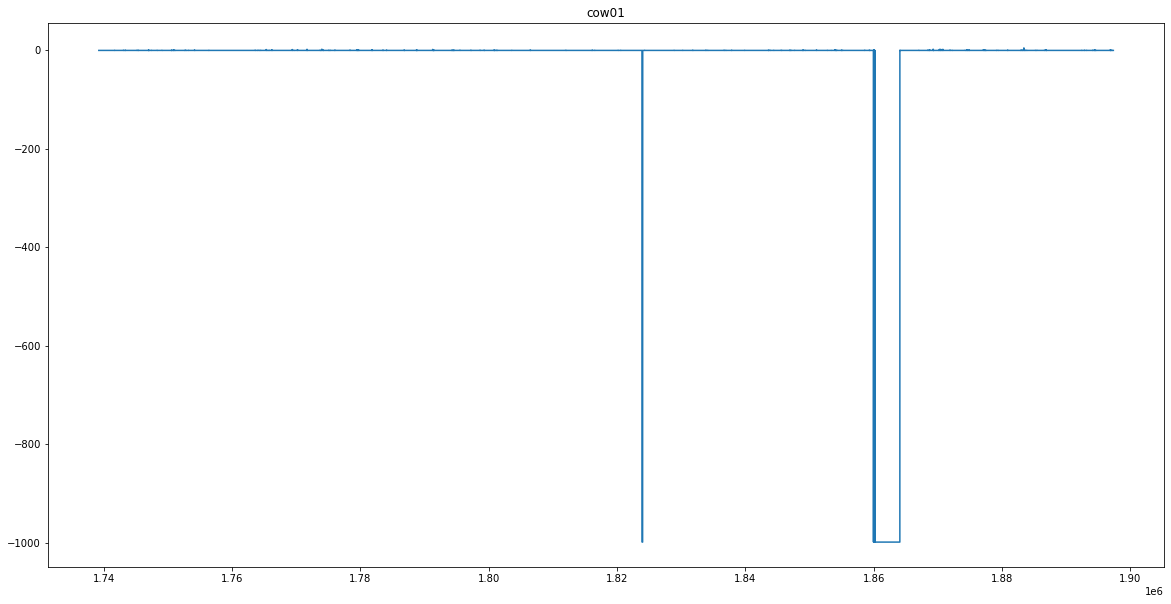

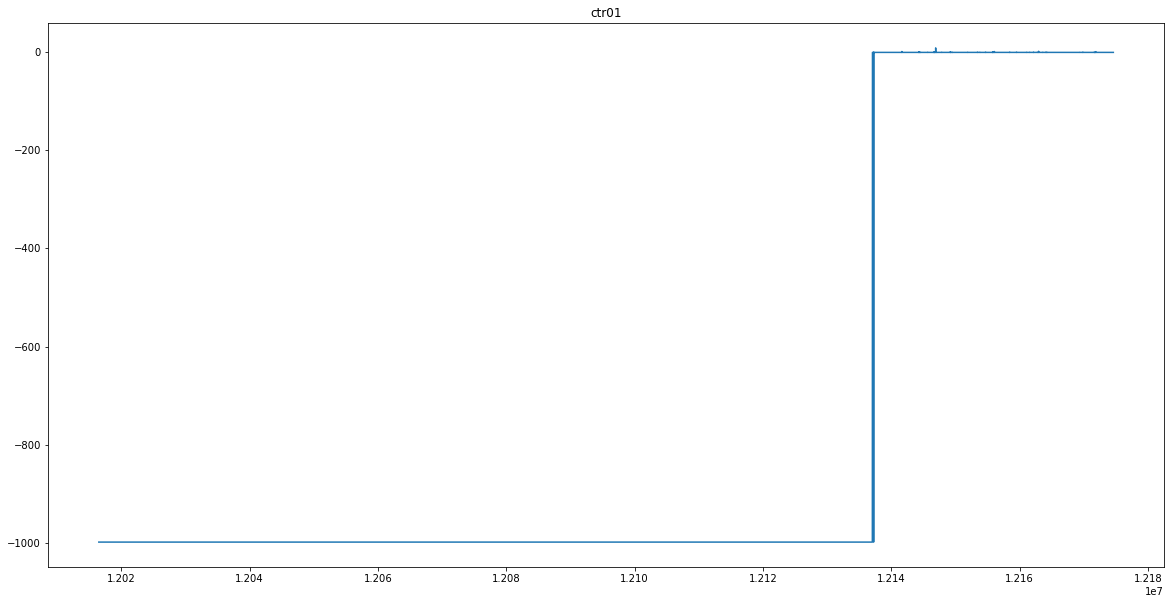

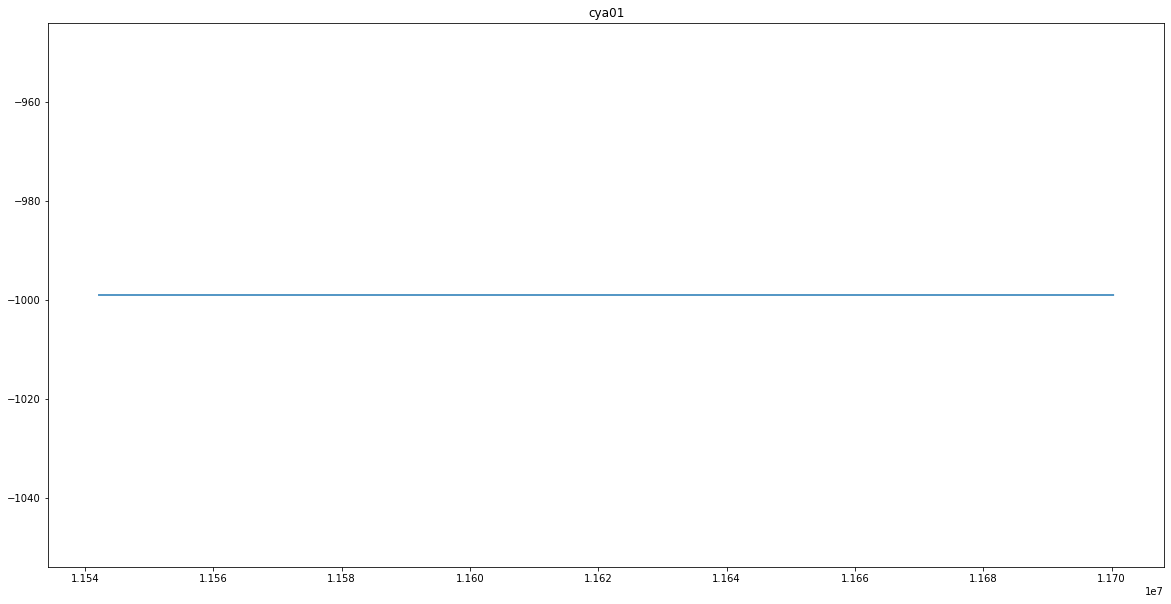

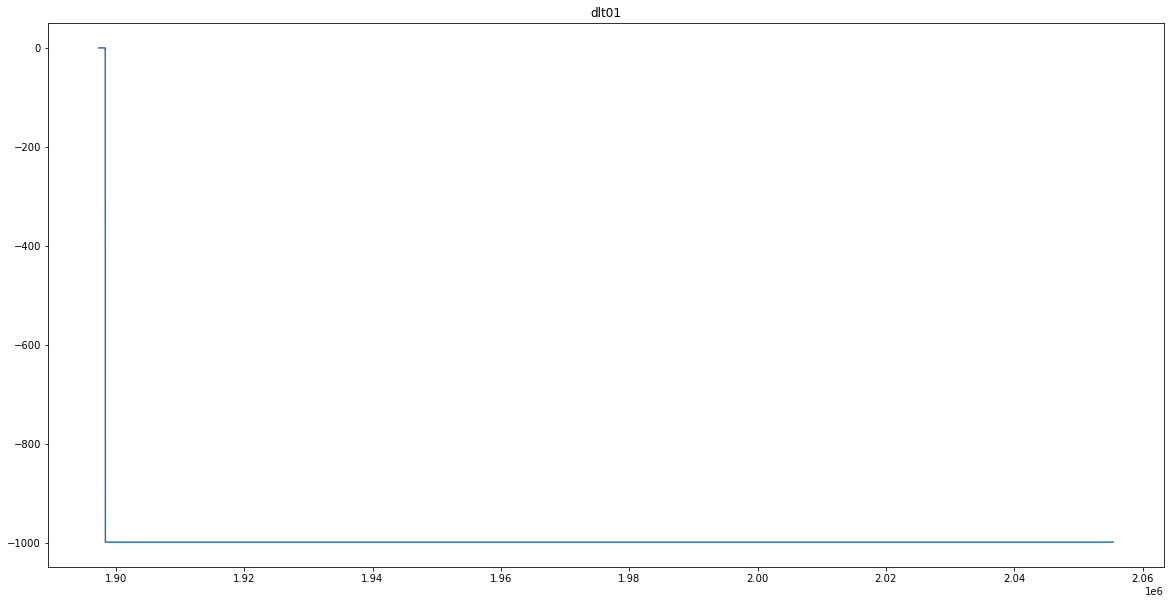

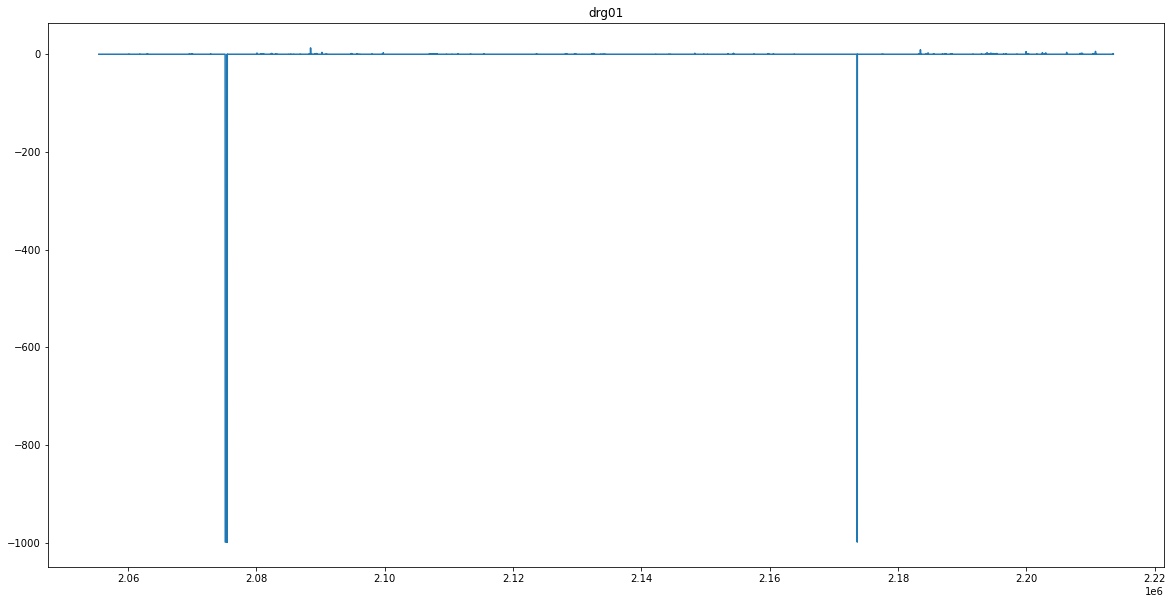

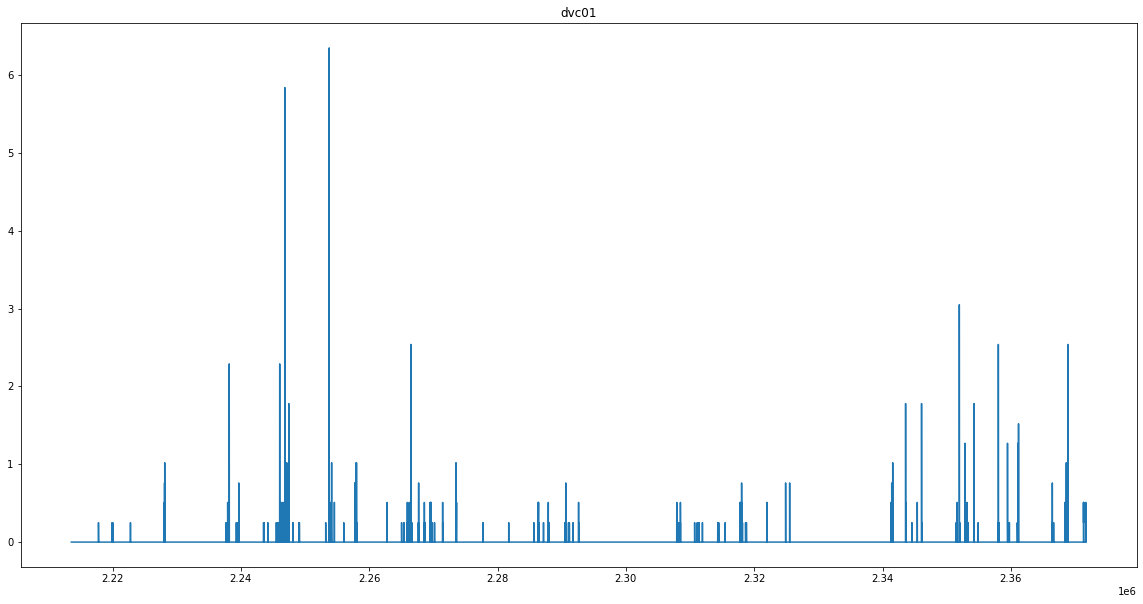

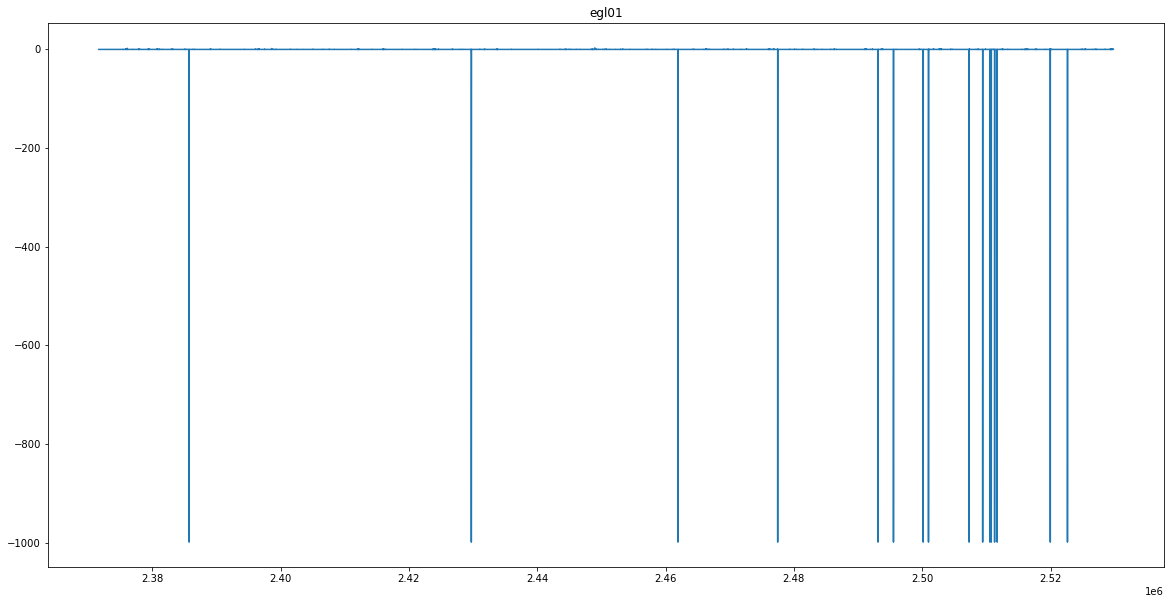

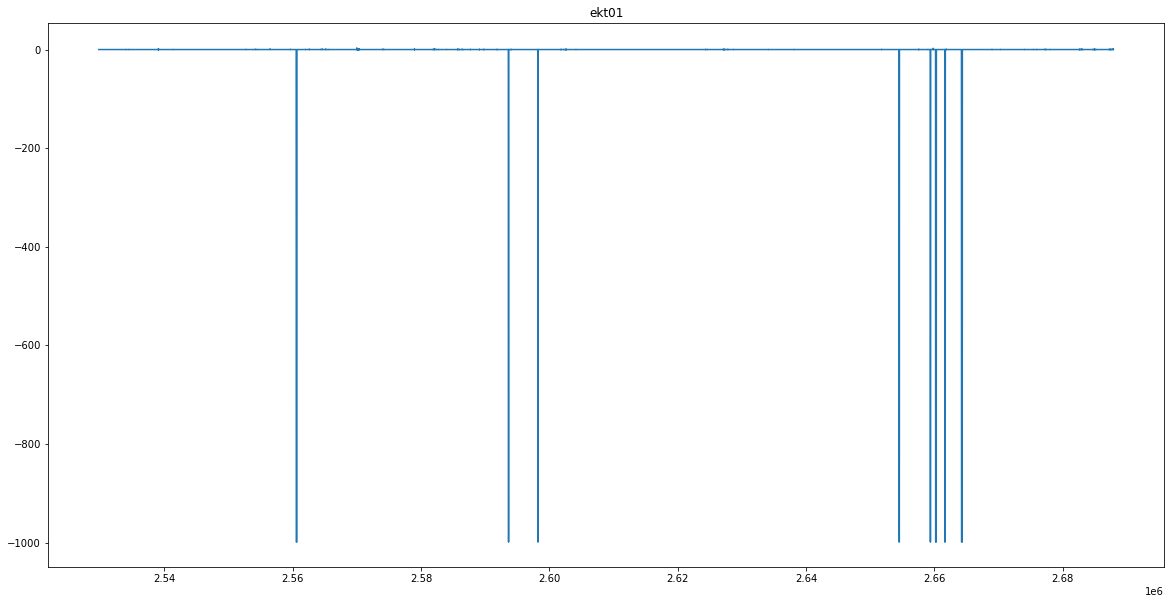

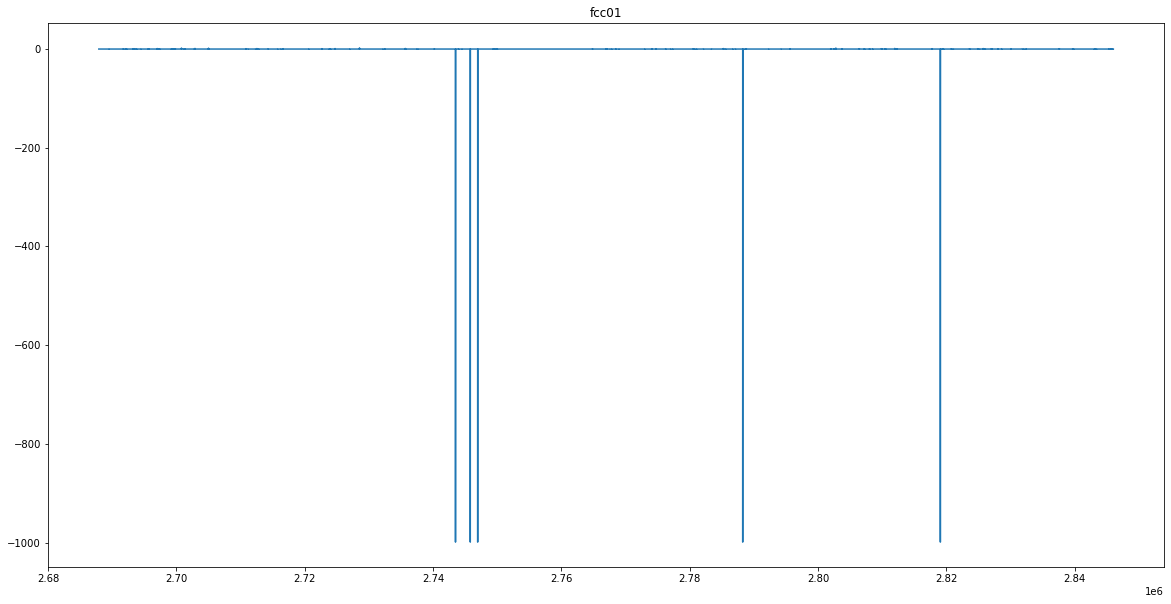

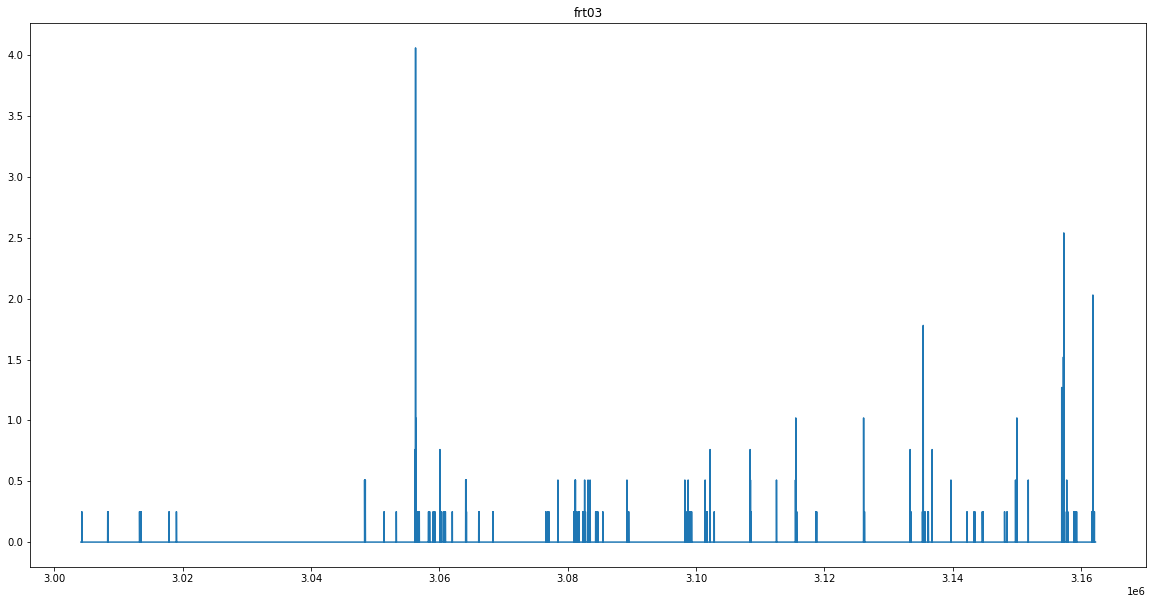

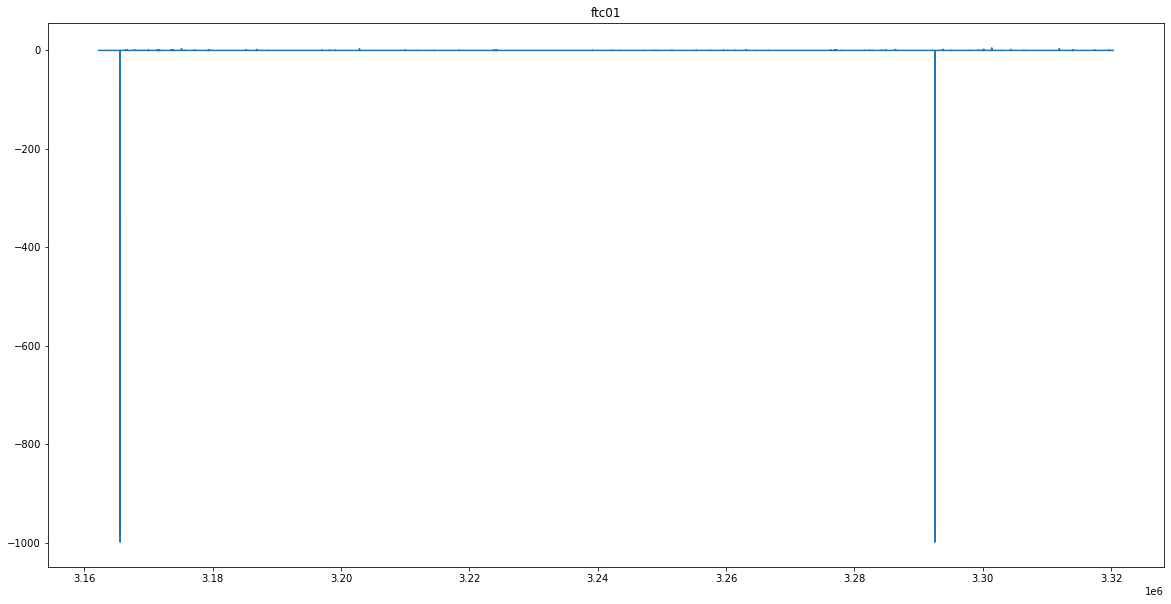

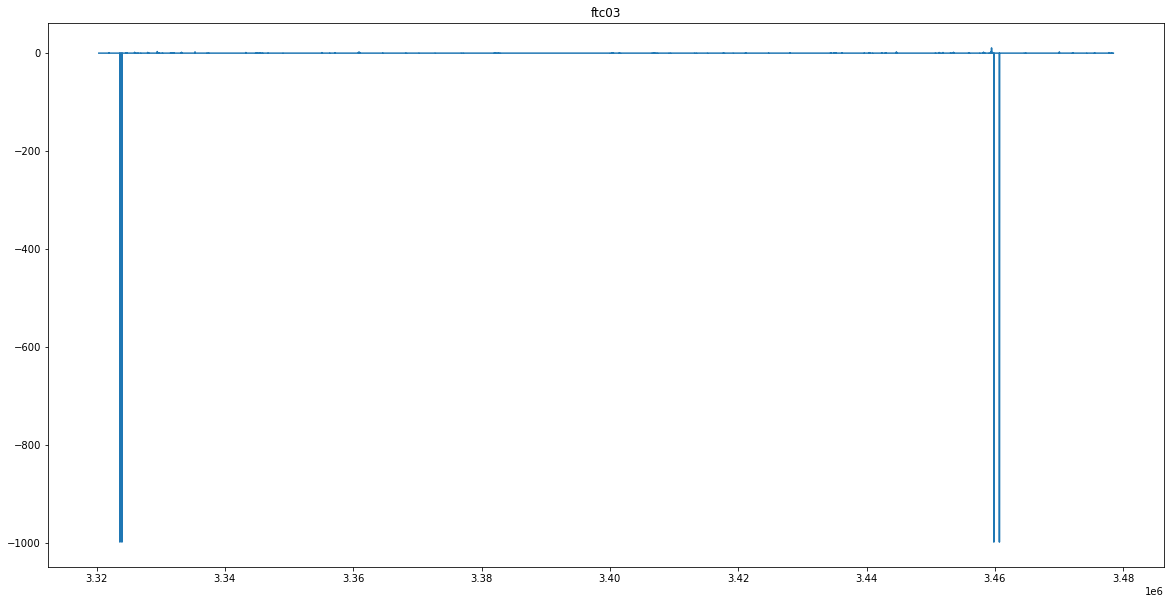

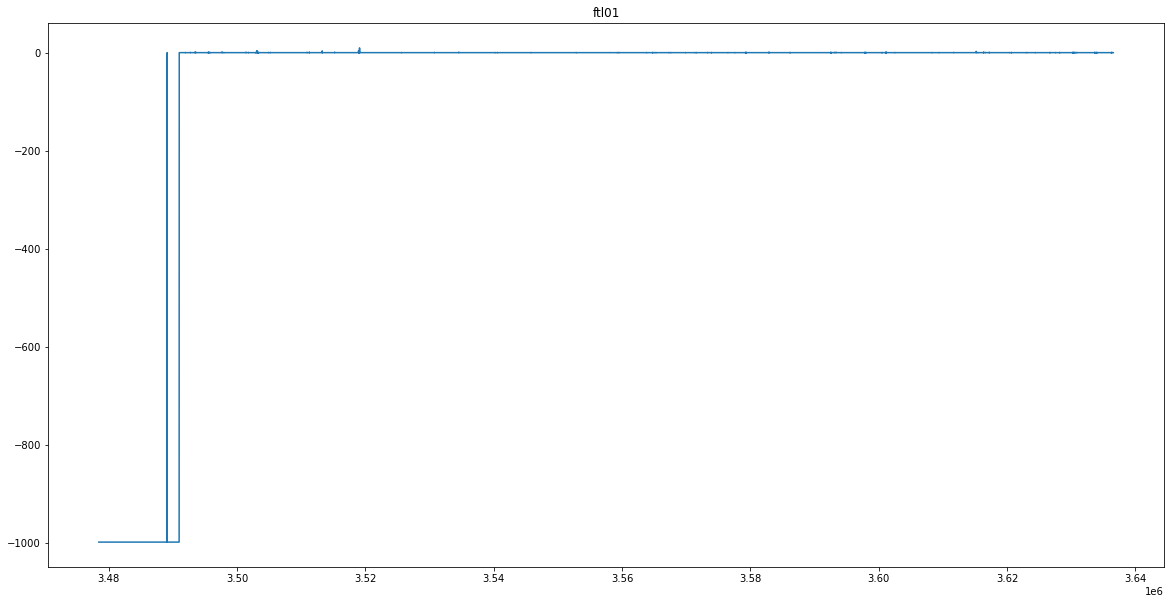

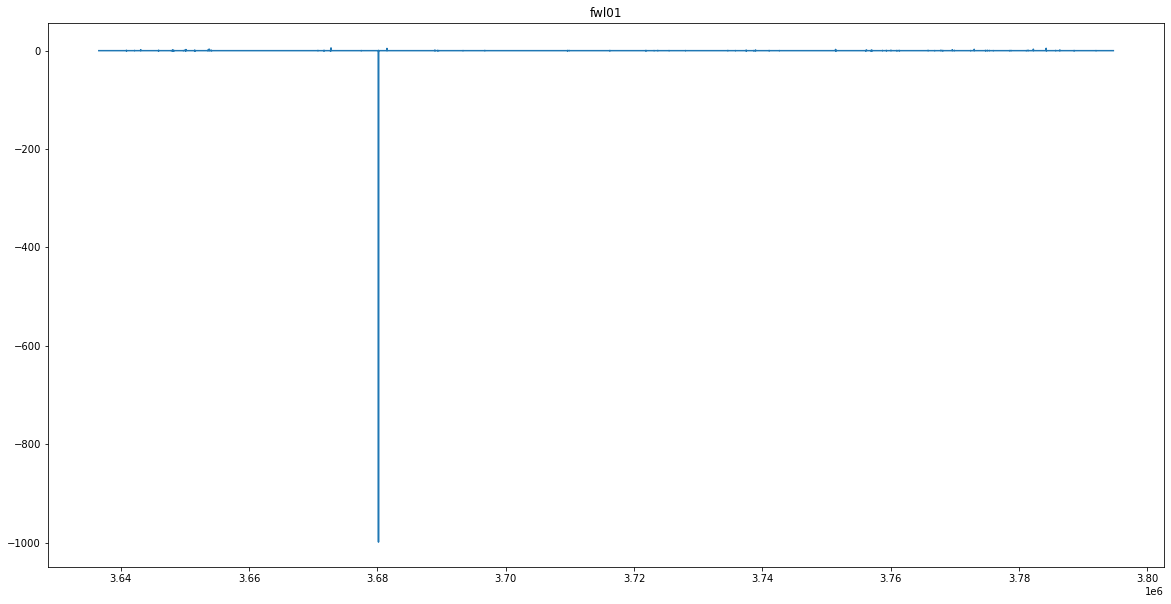

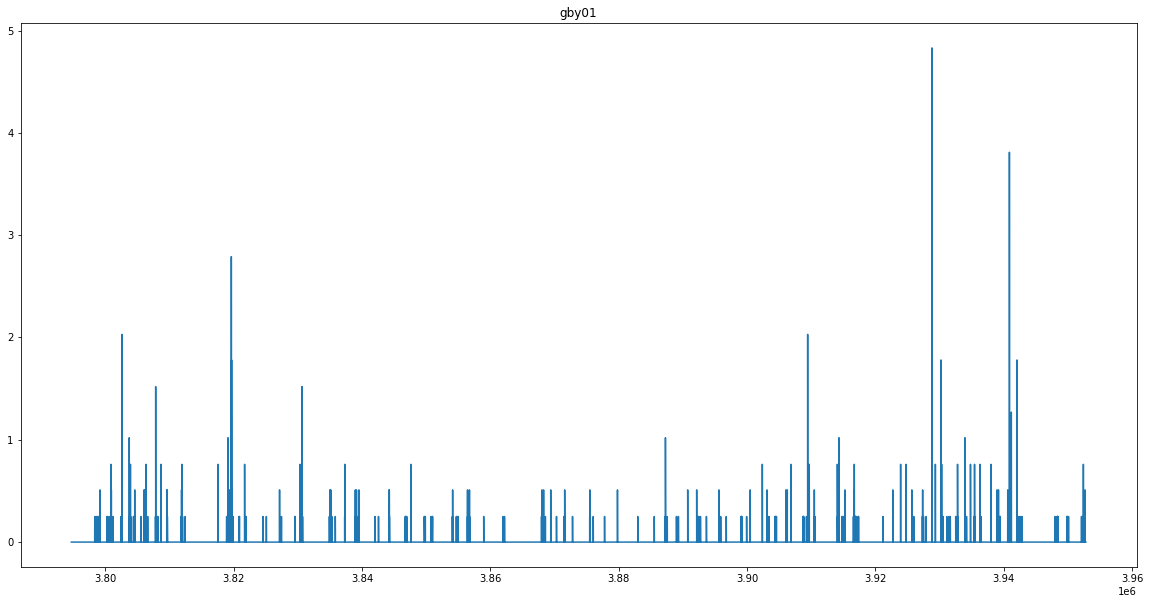

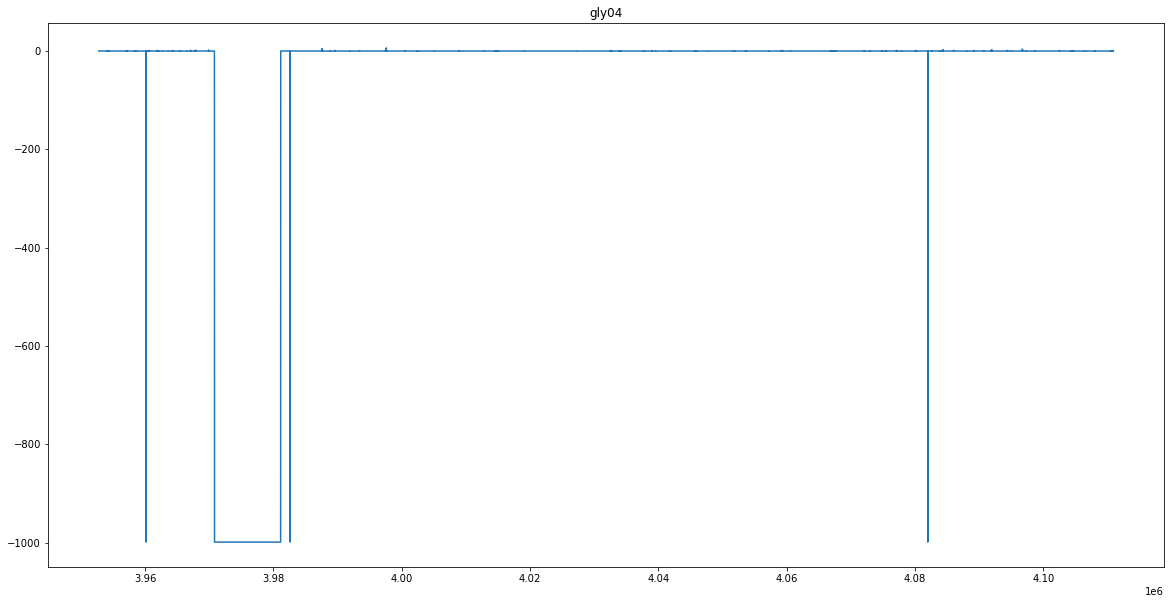

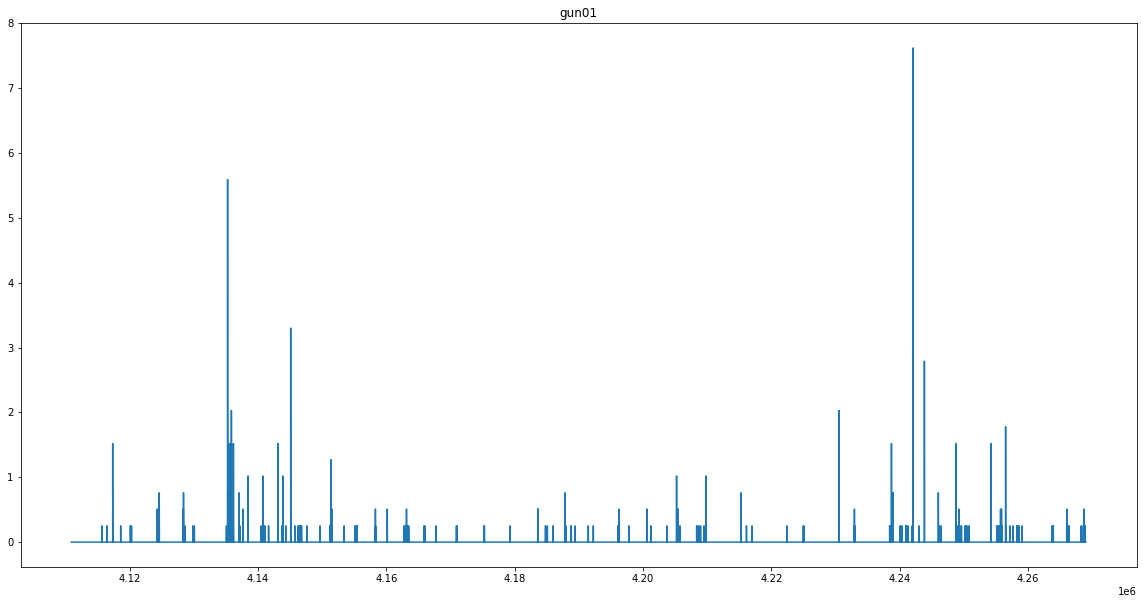

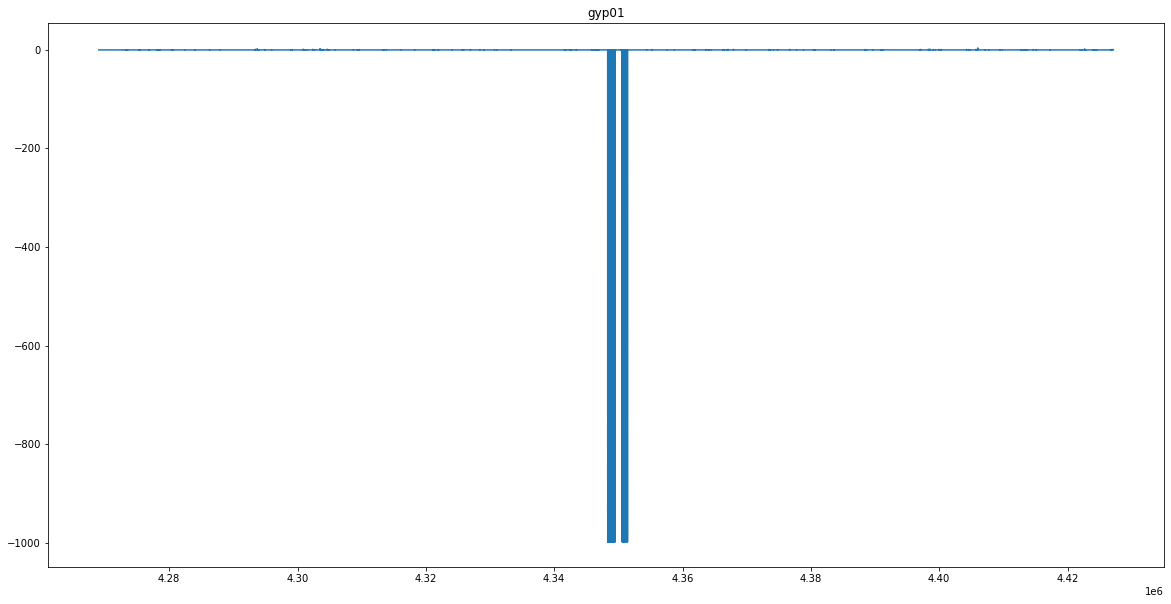

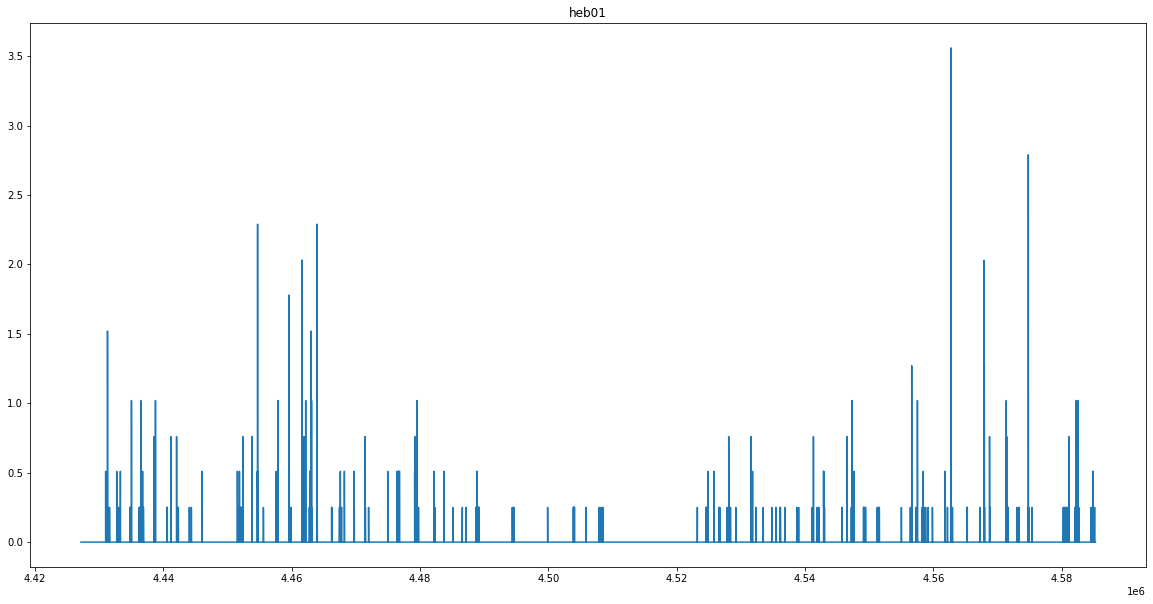

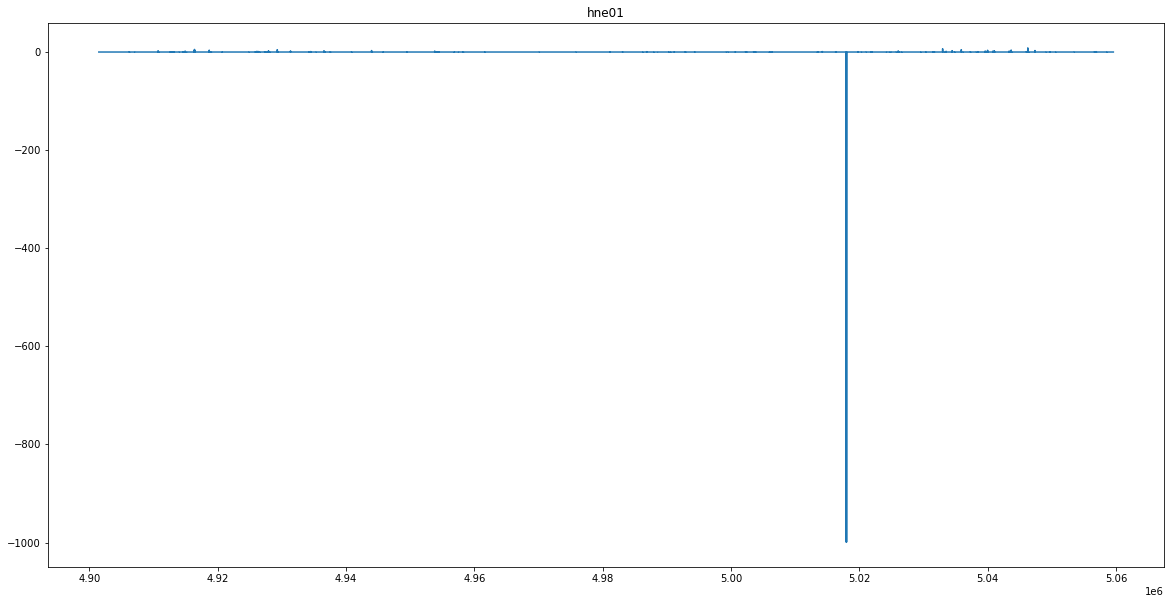

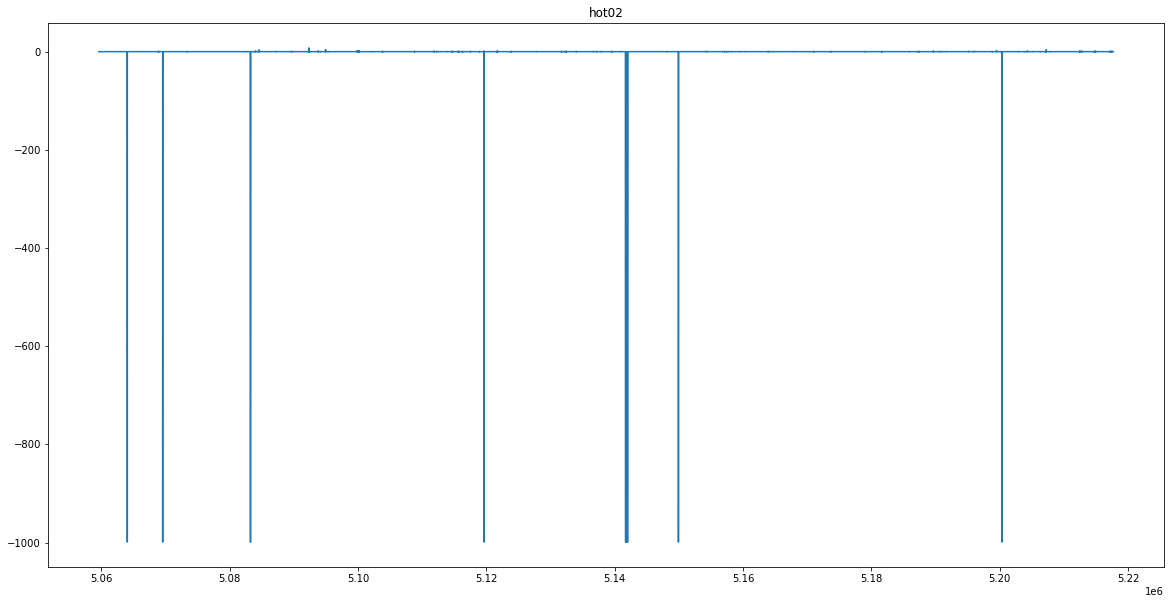

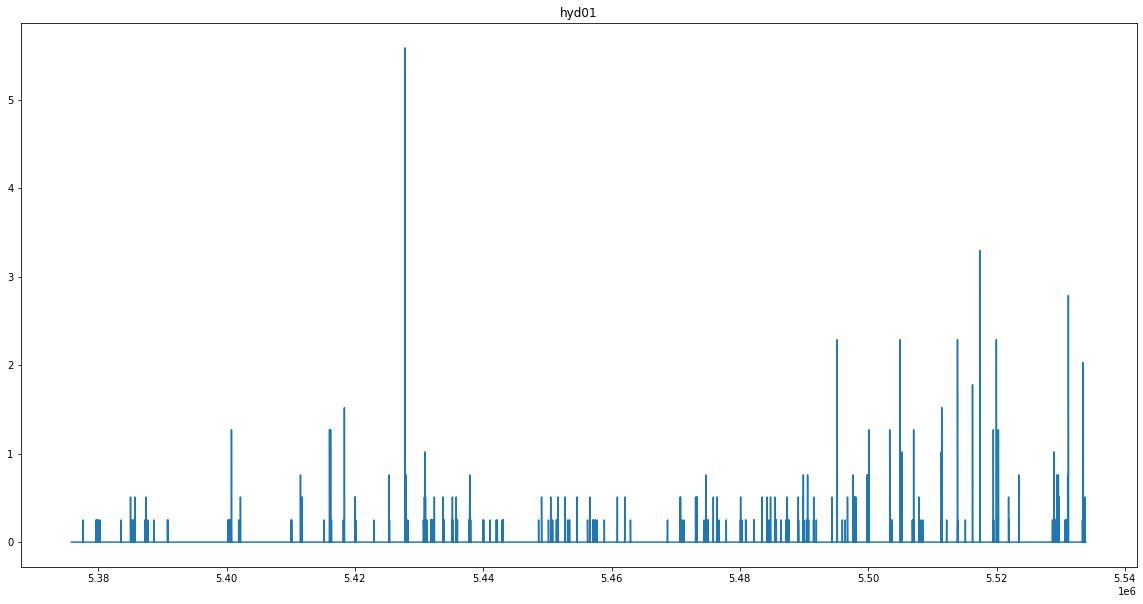

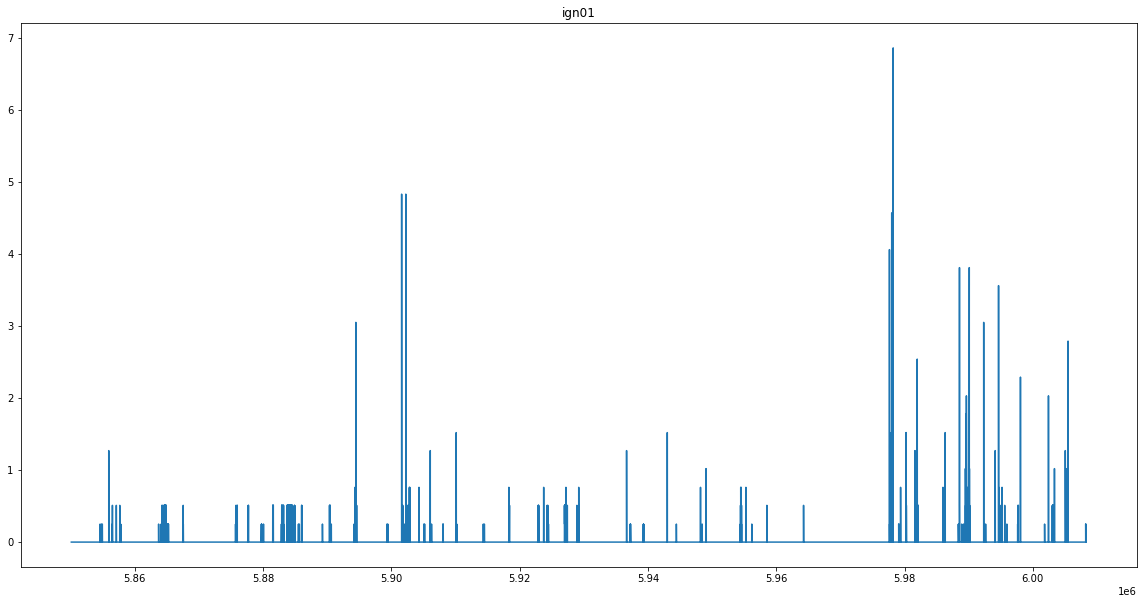

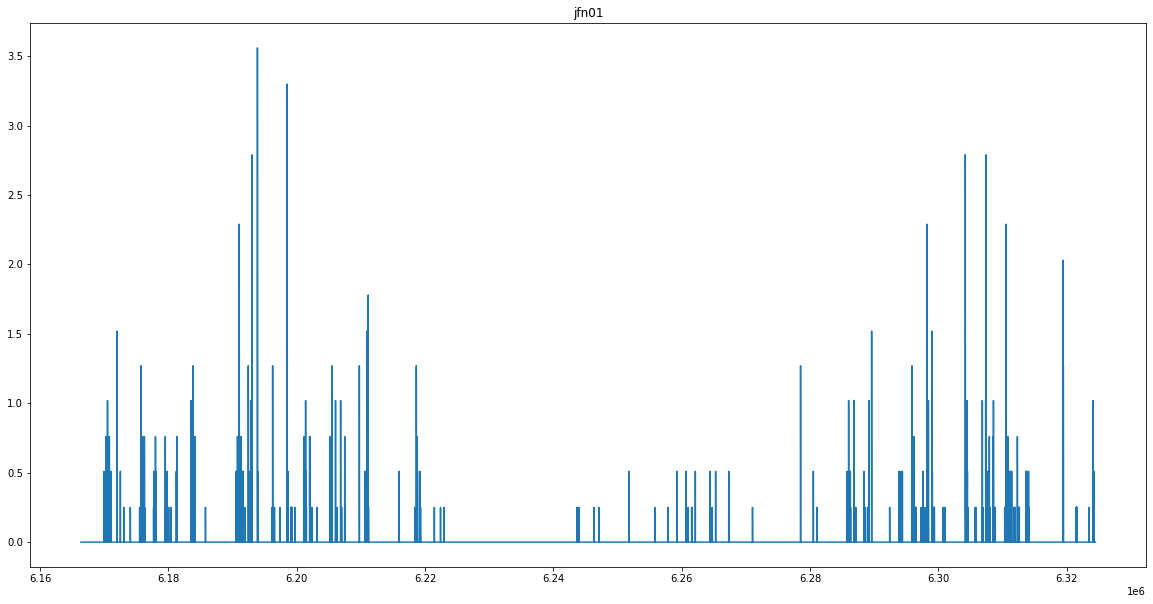

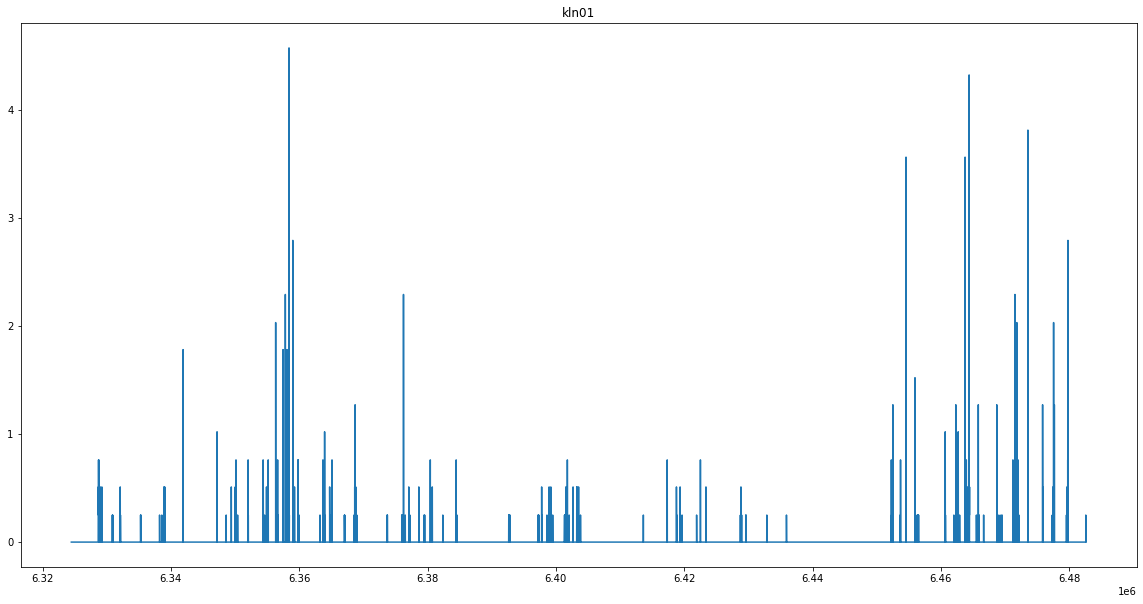

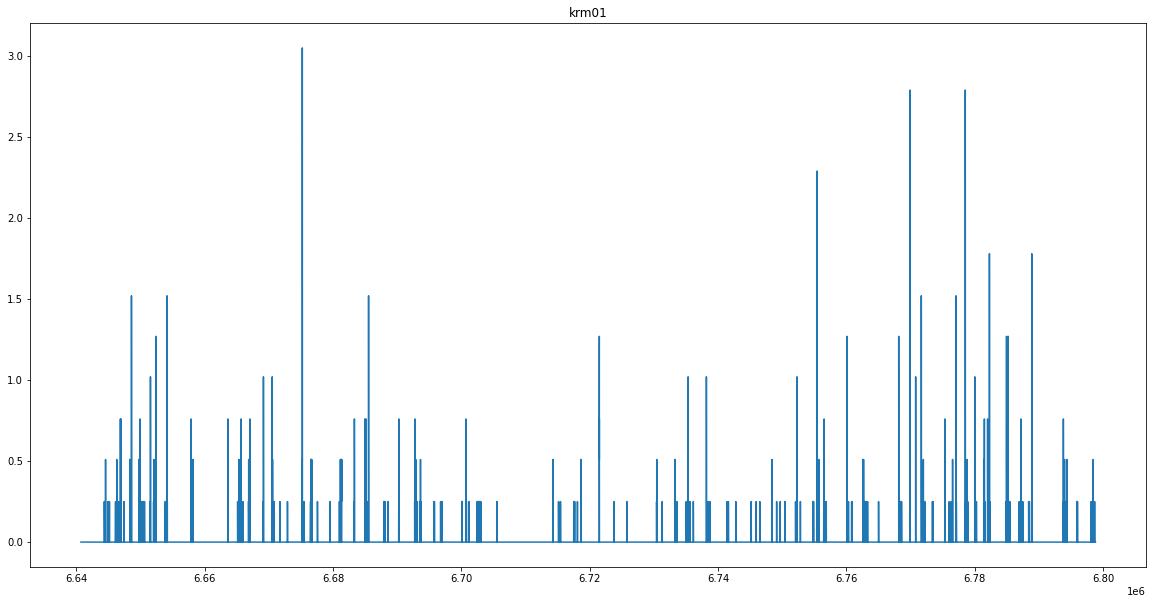

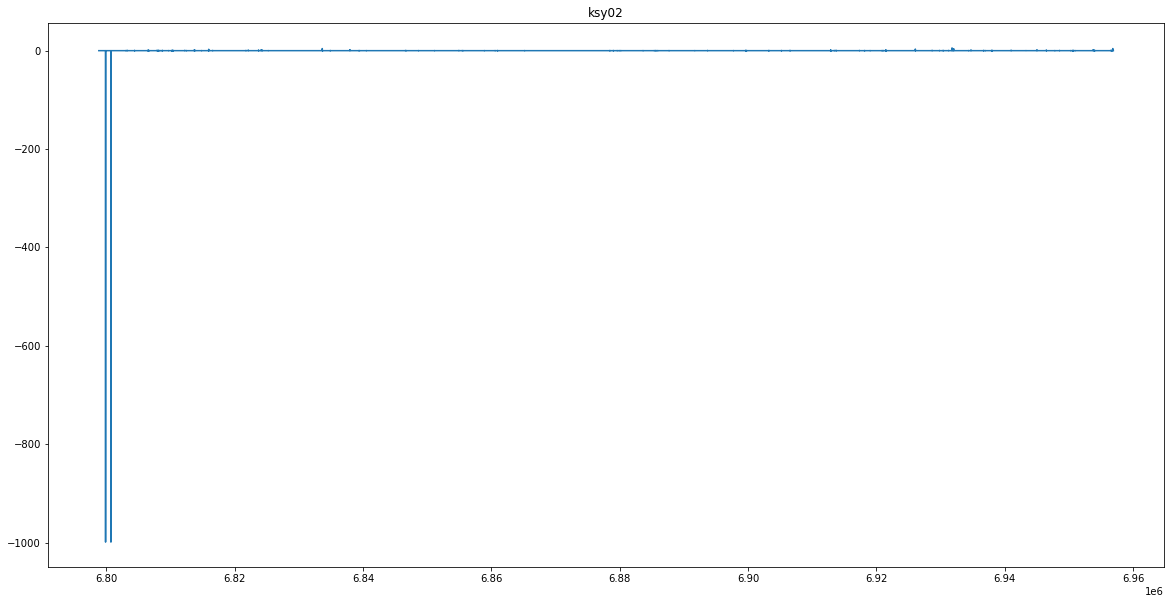

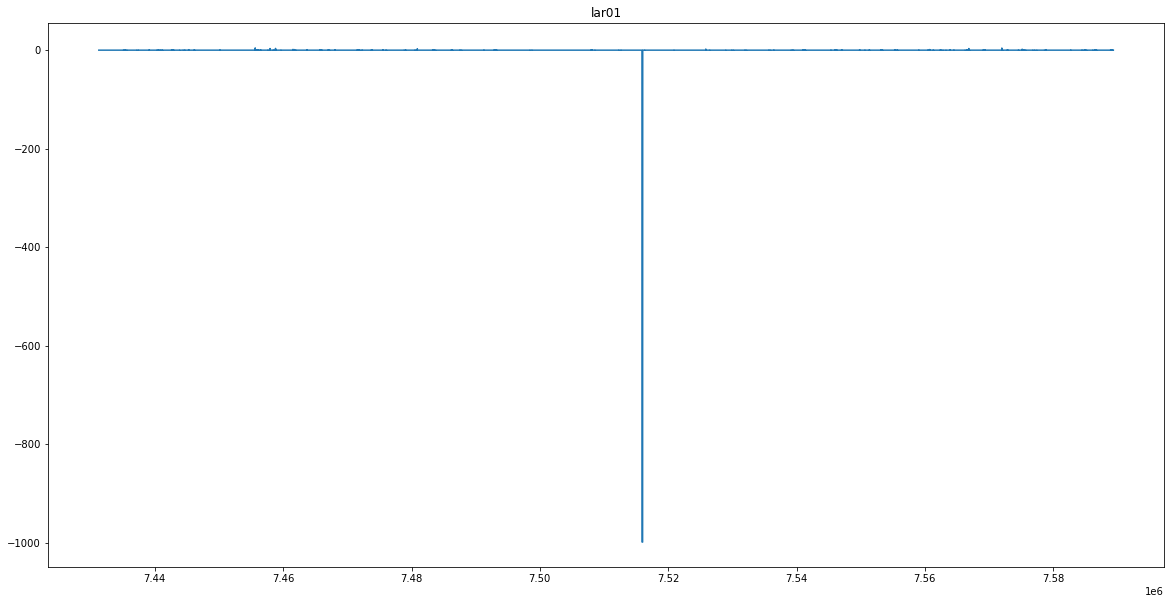

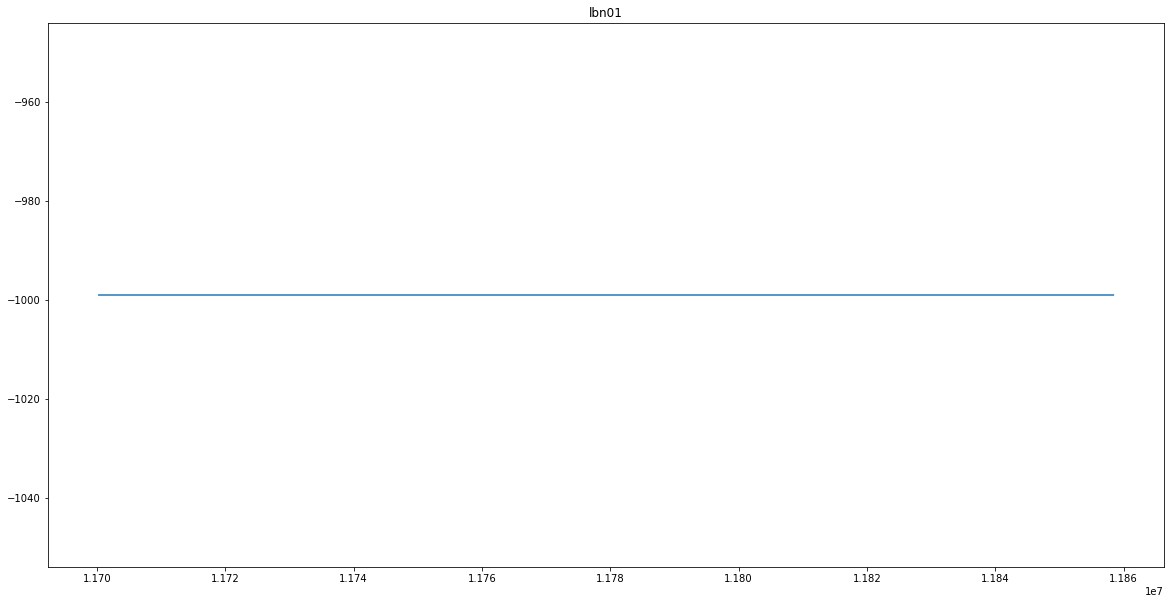

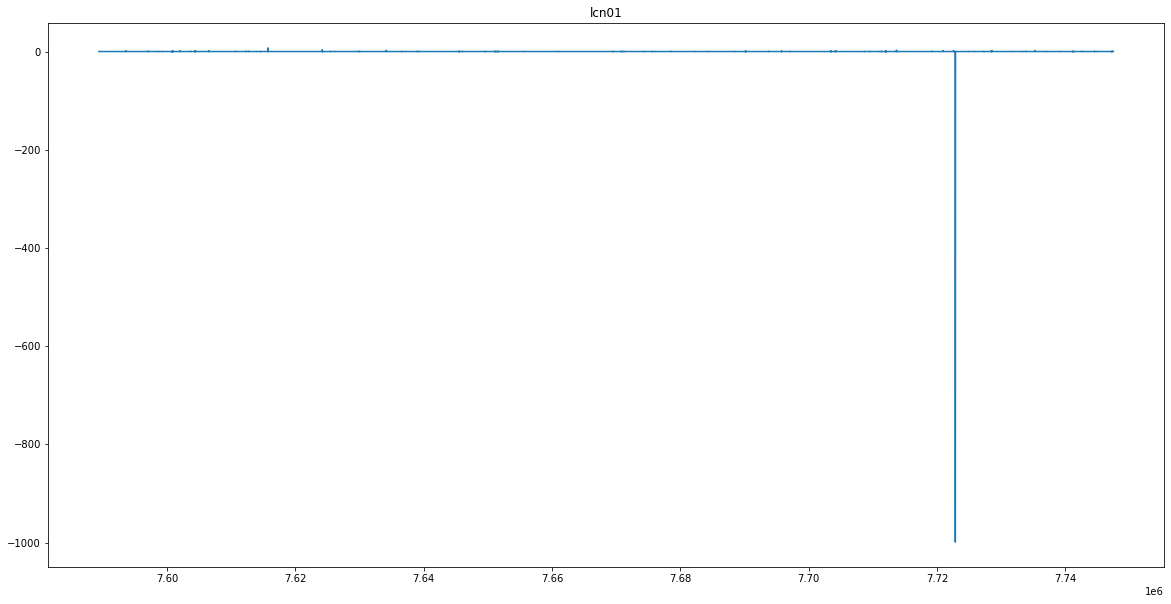

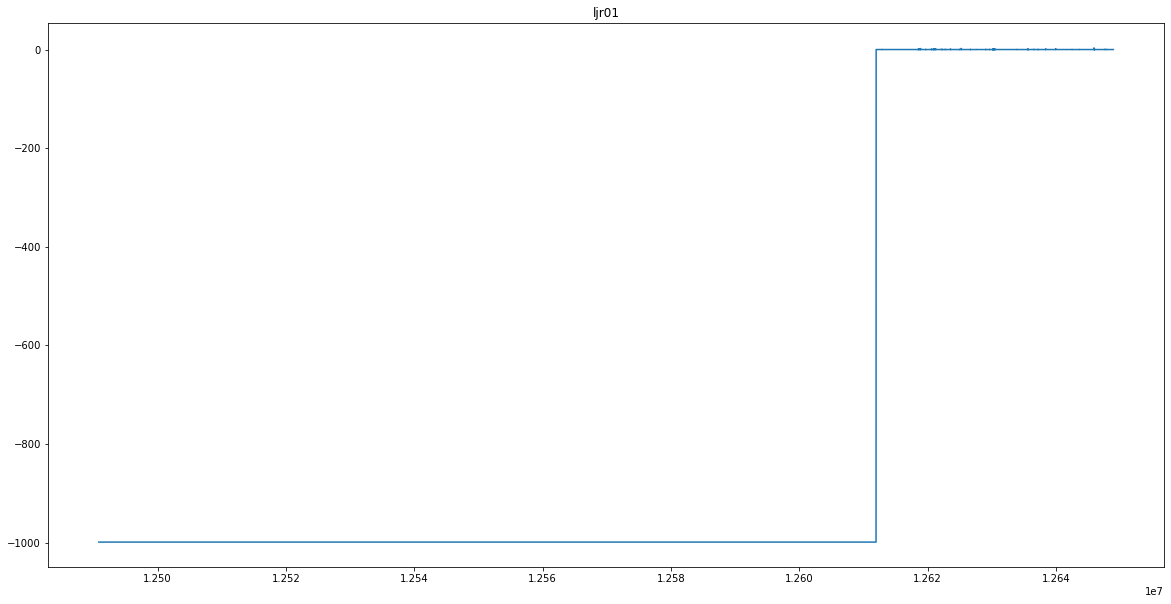

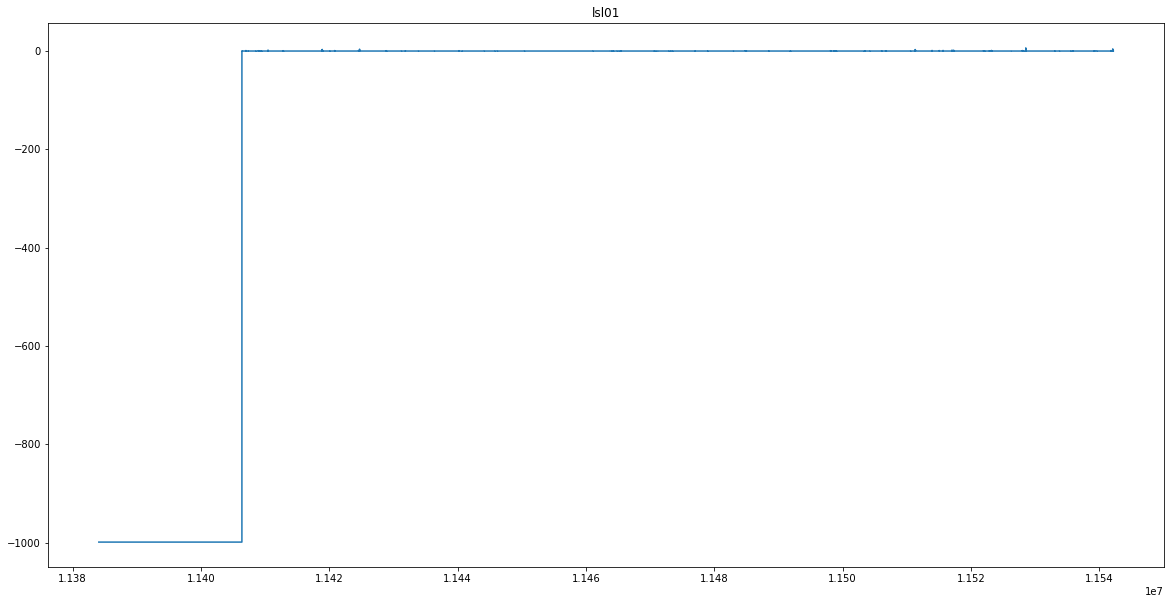

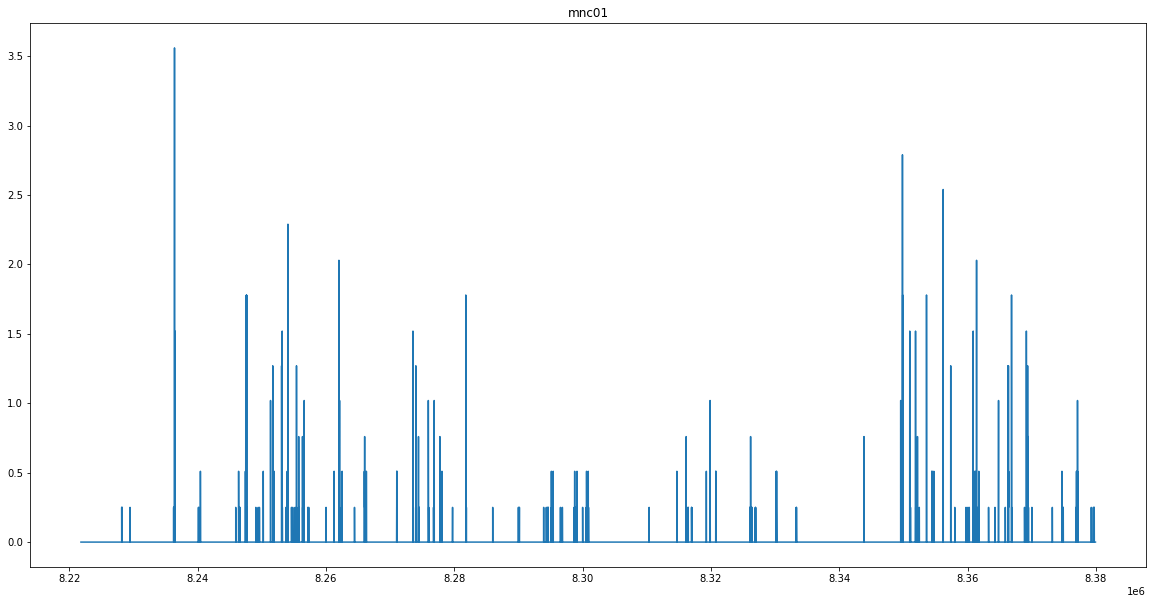

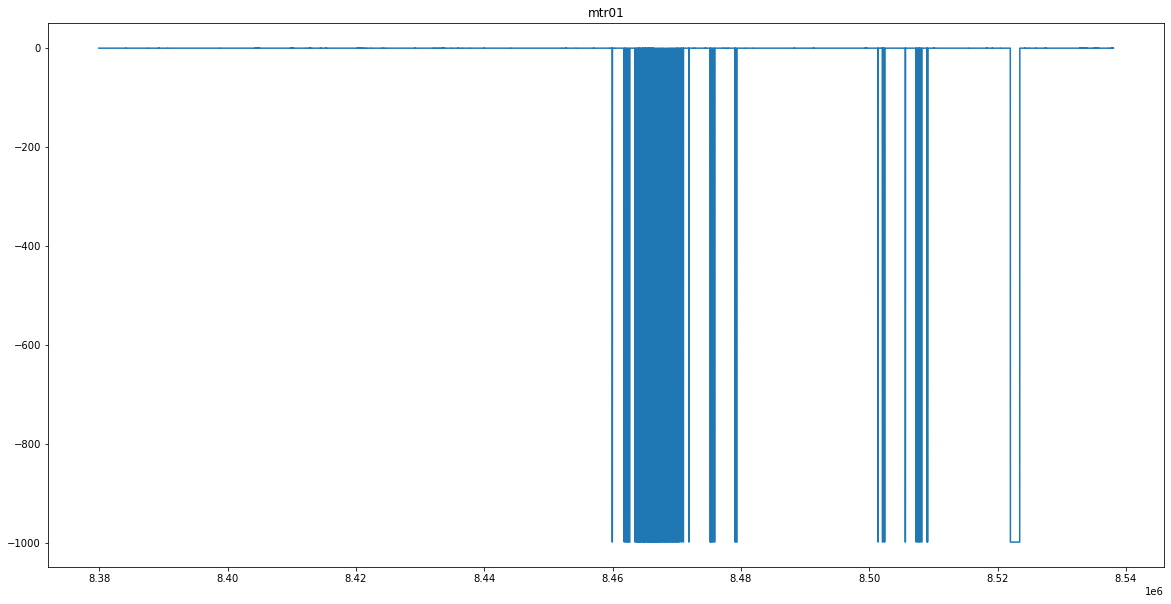

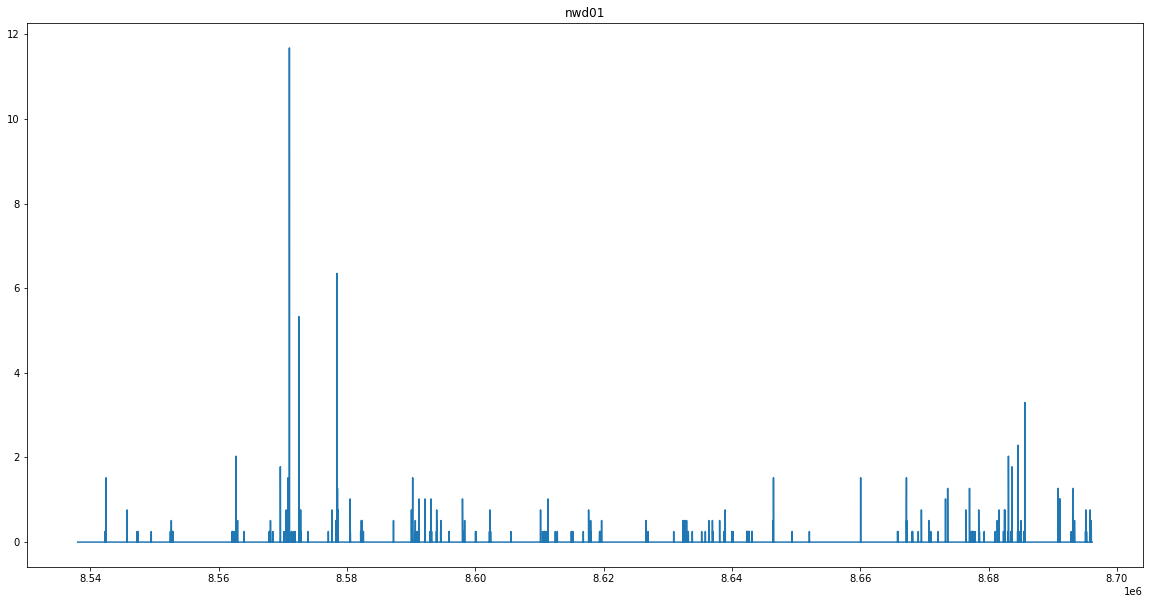

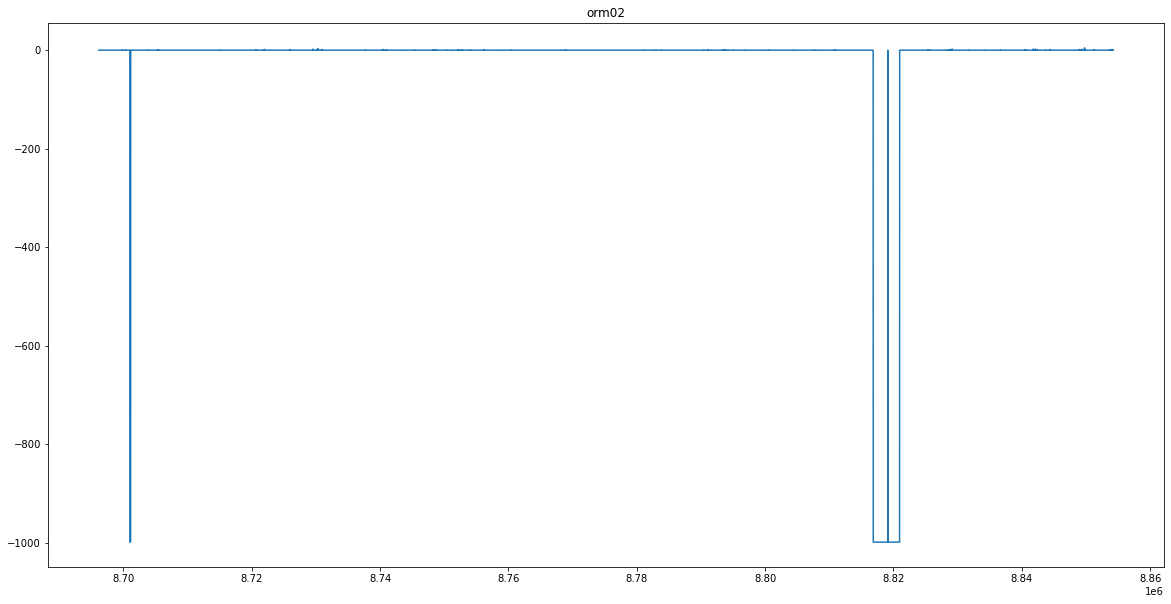

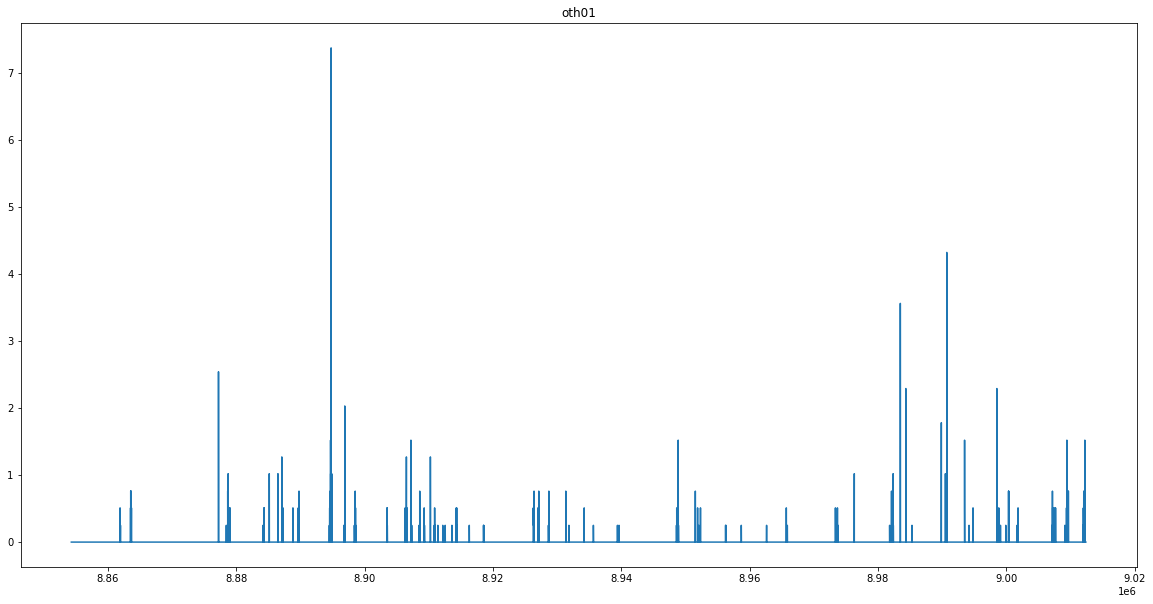

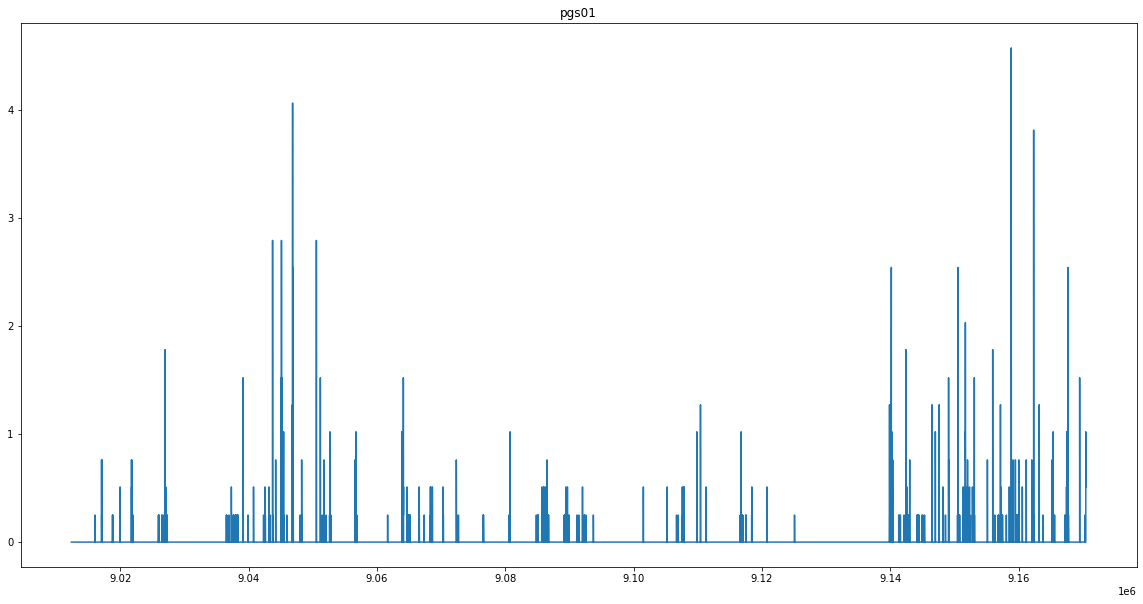

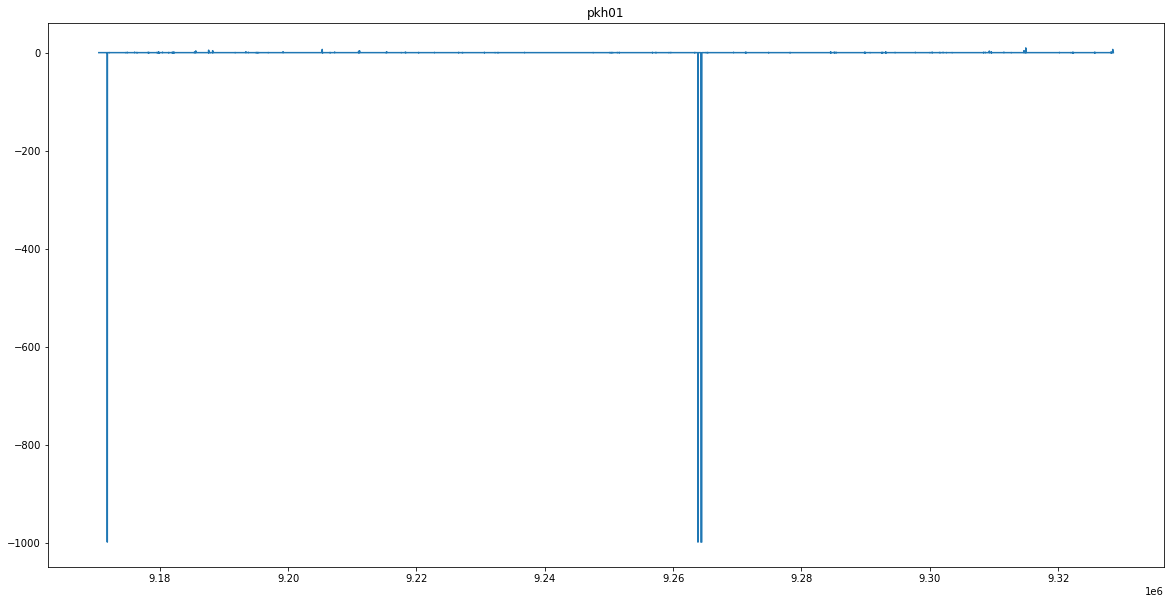

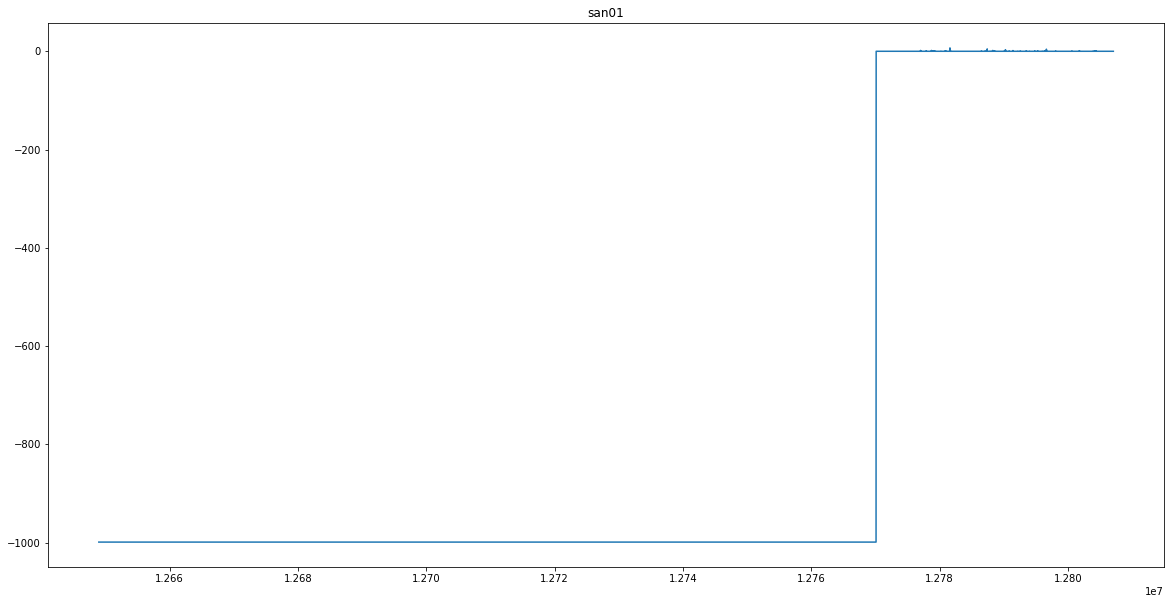

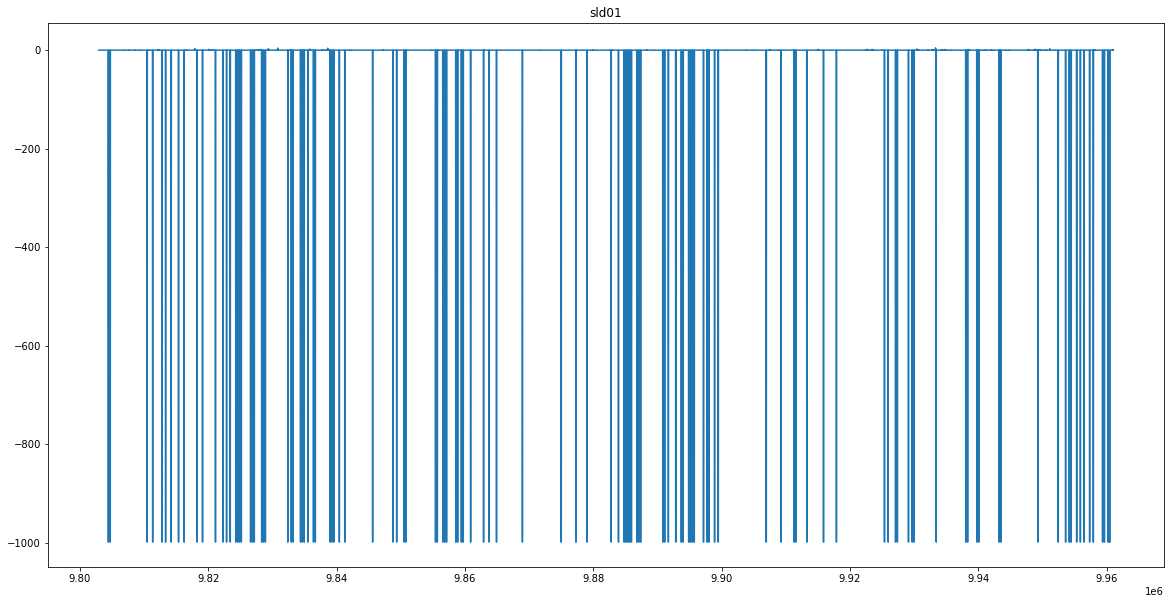

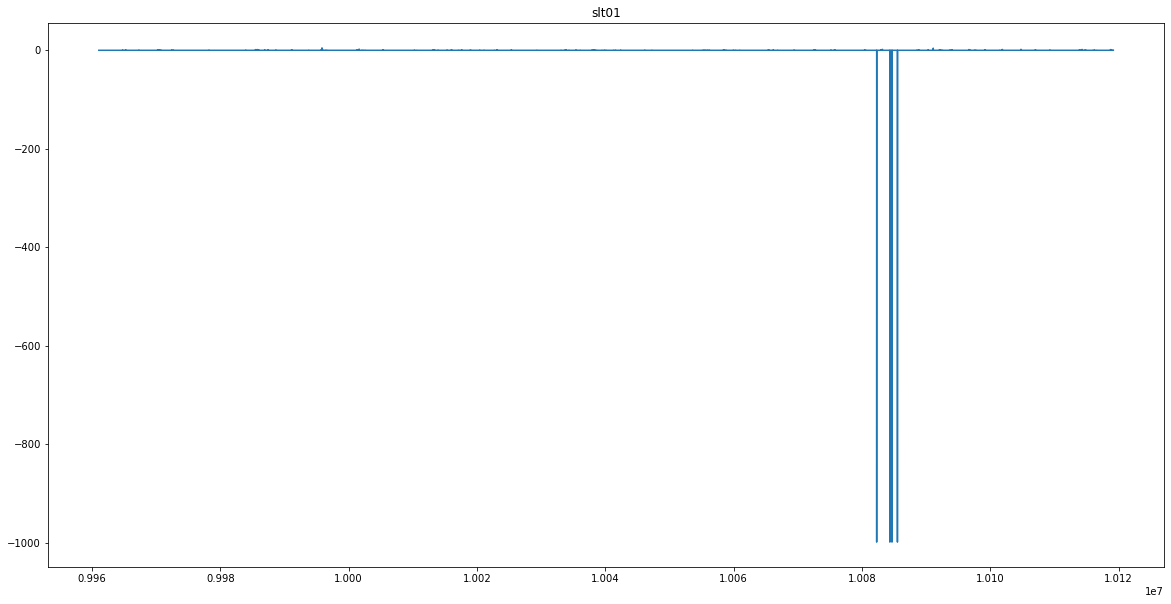

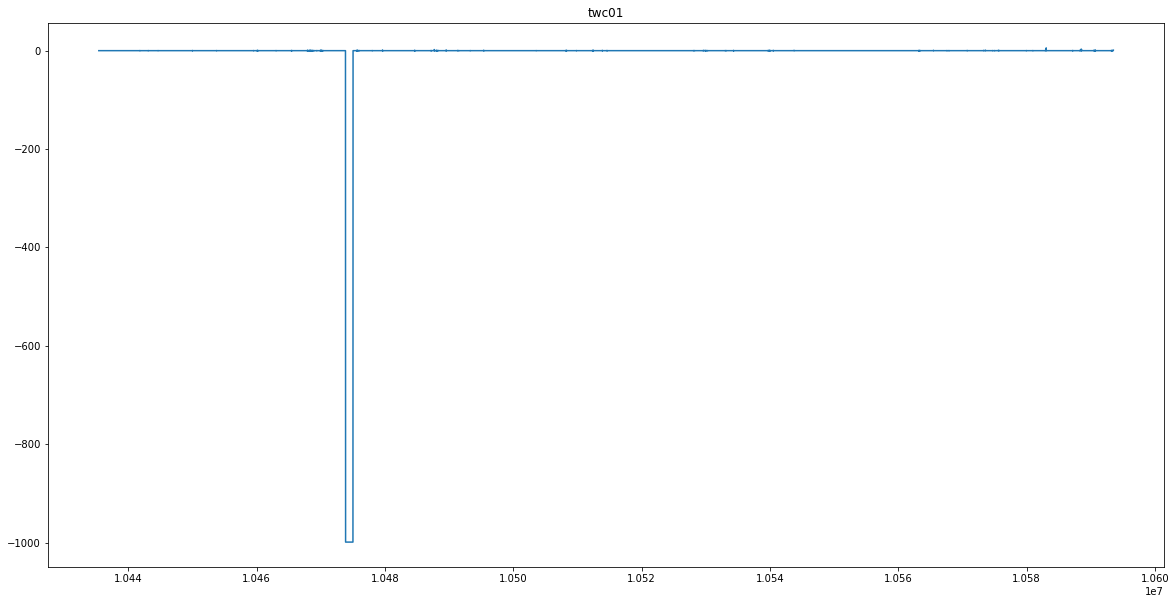

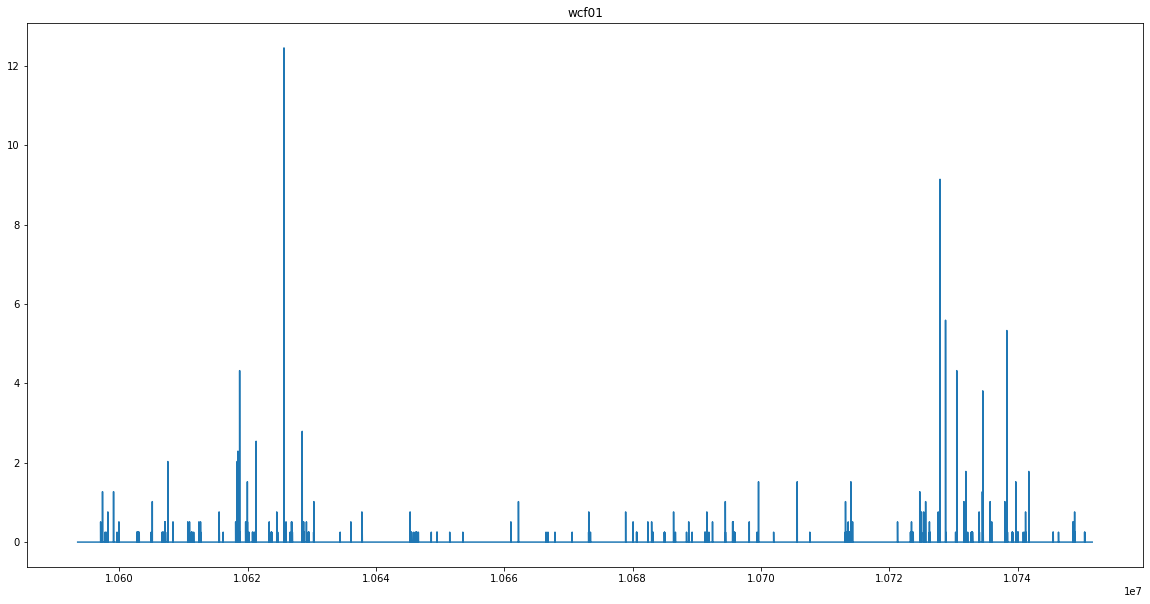

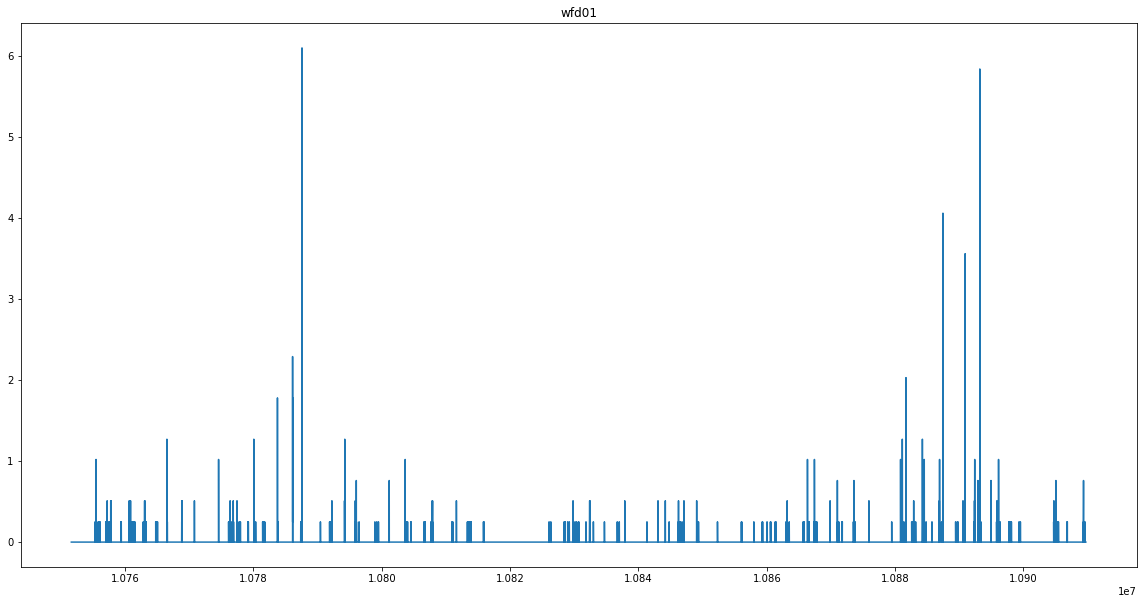

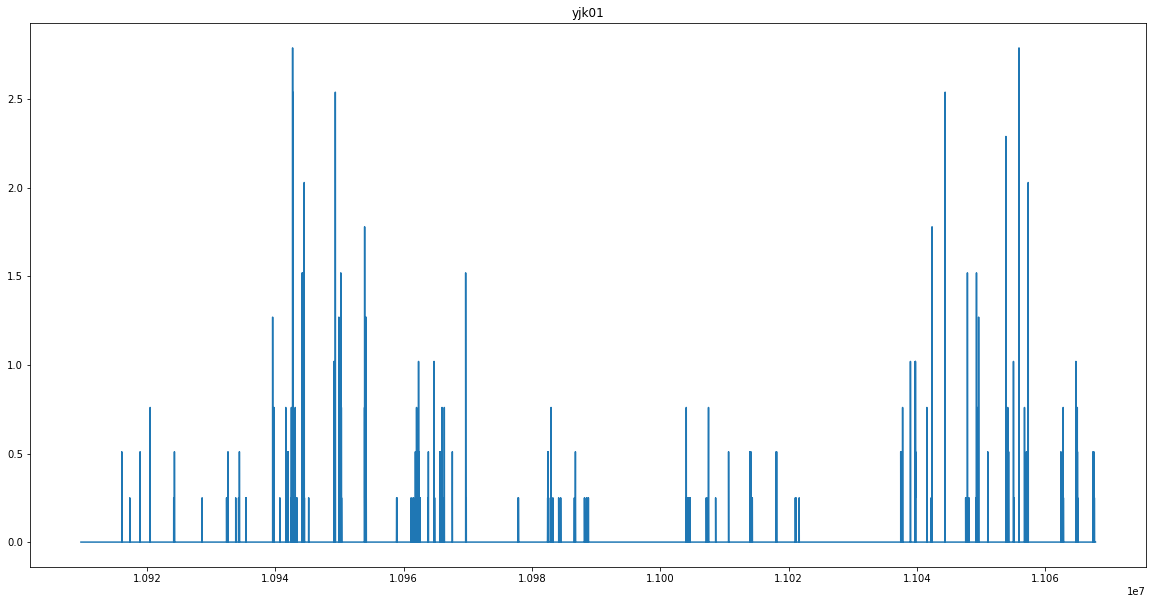

In [114]:
# look at missing data

gage_raw = pd.read_feather(data_folder+'\\coagmet_5min_01apr21_01oct22')
gage_location = pd.read_feather(data_folder+'\\coagmet_5min_metadata')
#gage_location = gage_location.drop([59])
gage_location = gage_location.loc[gage_location['Longitude (degE)']<=-104]
gage_location = gage_location.loc[gage_location.Station.isin(gage_raw.Station)]

gage_raw = [gage_raw.loc[gage_raw.Station==i] for i in gage_location.Station]

# look for questionable readings

for i in range(len(gage_raw)):
    fig = plt.figure(1, figsize=(20,10))
    plt.plot(gage_raw[i].Precip)
    plt.title(gage_location.Station.values[i])
    plt.show()

cameron peak fire

In [ ]:
import pandas as pd
from os import listdir
import numpy as np
from datetime import timedelta
#from mrms_gage import gage_storm

# open
filenames = listdir(data_folder+'\\raw')
# get names
filenames = [filenames.split('.', 1)[0].lower() for filenames in filenames]

# open
gage_location = pd.read_csv(data_folder +'\\Metadata.csv')
# get rain
gage_location = gage_location.loc[gage_location.Type=='rain']
# drop columns I don't care about
gage_location = gage_location.drop(gage_location.columns[4:11], axis=1).drop(['Type'],axis=1)
# remove _ from two letter locations
gage_location.Name = [name.replace("_","") for name in gage_location.Name]
# get locations for precip gages
gage_location = gage_location[gage_location['Name'].isin(filenames)]
# remove duplicates
gage_location = gage_location.drop_duplicates(keep='first').reset_index().drop(['index'],axis=1)
# convert to universal coords
gage_location['Longitude'] = gage_location['Longitude'].to_numpy()+360
gage_location.Latitude = gage_location.Latitude.astype(type(gage_location.Longitude[0]))

# open gage data and save as list to variable
gage_raw = [pd.read_csv(data_folder +'\\raw\\'+ gage_location.Name[i]+'.csv') for i in gage_location.index]

# change datetime type
for i in gage_location.index:
    gage_raw[i].datetime = gage_raw[i].datetime.astype('datetime64[ns]')

gage_raw = [gage_raw[i].set_index('datetime') for i in gage_location.index]

# duplicate should be added, assuming it means more than one tip in minute
gage_raw = [gage_raw[i].sort_index().groupby(gage_raw[i].index).sum() for i in gage_location.index]
gage_raw = [gage_raw[i].resample('1Min').asfreq().fillna(0) for i in range(len(gage_raw))]
#gage_raw = [gage_raw[i].resample('1Min').asfreq() for i in range(len(gage_raw))]

for i in range(len(gage_raw)):
    # multiply tips by 0.3 mm
    accum = gage_raw[i]*0.3
    # calculate desired intensity by summing 1min accum with rolling desired intensity window, 
    # then divide by desired intensity (min) and convert to mm/hr
    rate = accum.rolling(15,min_periods=1).sum()
    rate = (rate*(60/15))

    gage_raw[i]['15_int'] = rate
    gage_raw[i]['accum'] = accum


cpf = [gage_raw[i].drop(['tips'],axis=1) for i in range(len(gage_raw))]

cpf = [cpf[i].iloc[(cpf[i].index.year<=2022) & (cpf[i].index.year>=2021)&
               (cpf[i].index.month>=4) & (cpf[i].index.month<11)] for i in range(len(gage_raw))]

coord = zip(gage_location.Latitude,gage_location.Longitude)
cpf = dict(zip(coord, cpf))

In [118]:
# open
gage_location = pd.read_csv(data_folder+'\\cpf google drive' +'\\Metadata.csv')
# get rain
gage_location = gage_location.loc[gage_location.Type=='rain']

In [122]:
gage_location

,Name,Type,Latitude,Longitude,Region,Burn_status,Snow_zone,Sensor_model,Sensor_install,Sensor_remove,Comments
0,michigan,rain,40.496087,-105.863973,frontrange,unburned,persistent,TE525,12/3/2015,still running,NaN
12,montgomery,rain,40.543683,-105.881733,frontrange,unburned,persistent,NaN,NaN,still running,NaN
19,joewright,rain,40.532813,-105.887462,frontrange,unburned,persistent,TE525MM-L,4/18/2021,still running,NaN
33,bl4,rain,40.590798,-105.861091,frontrange,burned_2020,persistent,NaN,NaN,still running,NaN
36,aspen,rain,40.614592,-105.819063,frontrange,burned_2020,transitional,TE525,7/21/2017,still running,data gap 2020-11 to 2021-05; gage was tipped d...
40,tunnel,rain,40.669860,-105.809840,frontrange,burned_2020,transitional,TE525MM-L,4/18/2021,still running,NaN
57,dry,rain,40.706724,-105.639393,frontrange,burned_2020,intermittent,TE525,10/1/2016,6/23/2020,burned in Cameron Peak Fire
70,dry,rain,40.706724,-105.639393,frontrange,burned_2020,intermittent,TE525,5/18/2021,still running,NaN
80,dadd,rain,40.697364,-105.540155,frontrange,unburned,intermittent,TE525,7/19/2017,still running,NaN
82,skin,rain,40.676216,-105.388230,frontrange,burned_2012,intermittent,Rainwise,4/30/2018,still running,NaN
